**RNNS for sentiment analysis**

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding


### Dataset preprocessing utils for amazon dataset

In [2]:
# Plot accuracy and loss function
def plot(history,name):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    plt.title(f"Training and validation accuracy - {name}")
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r--o", label="Validation loss")
    plt.title(f"Training and validation loss - {name}")
    plt.legend()

    plt.show()

In [3]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()

    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))

    for i, aLine in enumerate(lines):
        if not aLine:
            break
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(aLine.removeprefix("__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(aLine.removeprefix("__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()

    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [4]:
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = tf.keras.layers.TextVectorization(max_tokens = maxFeatures,
    standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int',
    output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)


    return x_train_int, y_train, x_test_int, y_test

First of all we are going to import the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
x_train, y_train, seqLength = readData("/content/drive/My Drive/Colab Notebooks/amazon/train_small.txt")
x_test, y_test, tmp = readData("/content/drive/My Drive/Colab Notebooks/amazon/test_small.txt")

Before creating the RNNs we should do a variable distribution analysis:

<ipython-input-7-38334f6f0004>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


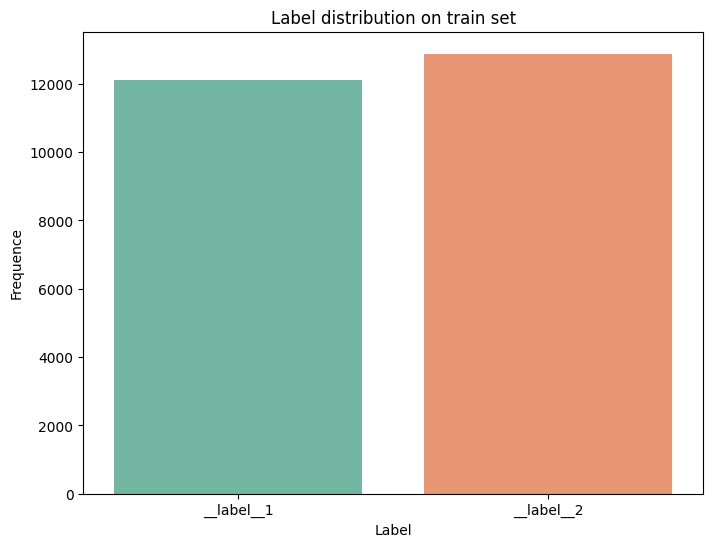

<ipython-input-7-38334f6f0004>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette='Set2')


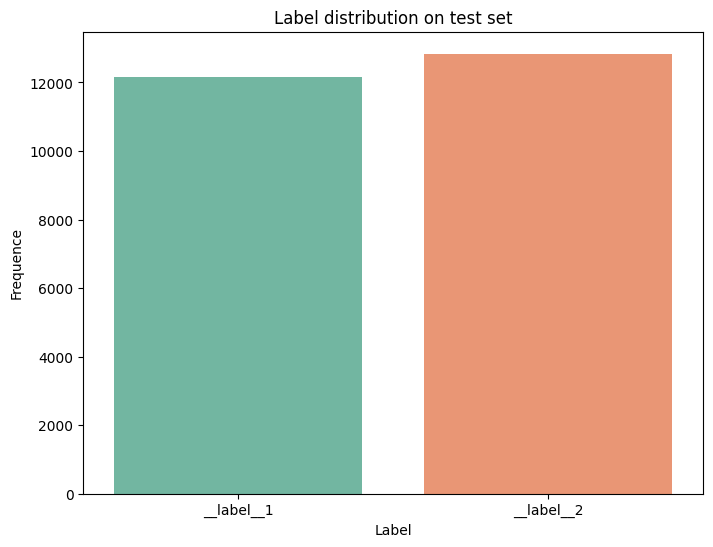

In [7]:
# Distribution for y_train
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette='Set2')
plt.title('Label distribution on train set')
plt.xlabel('Label')
plt.ylabel('Frequence')
plt.xticks([0, 1], ['__label__1', '__label__2'])
plt.show()

# Distribution for y_test
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette='Set2')
plt.title('Label distribution on test set')
plt.xlabel('Label')
plt.ylabel('Frequence')
plt.xticks([0, 1], ['__label__1', '__label__2'])
plt.show()


As we can see there are more positive reviews as label 2 refers to 4 and 5 stars reviews. We can also get some text examples:

In [ ]:
#Examples of texts
print("First 5 examples of x_train:")
for i in range(5):
    print(f"Text {i+1}: {x_train[i]} -> Label: {'__label__1' if y_train[i] == 0 else '__label__2'}")

print("\nFirst 5 examples of x_test:")
for i in range(5):
    print(f"Text {i+1}: {x_test[i]} -> Label: {'__label__1' if y_test[i] == 0 else '__label__2'}")


First 5 examples of x_train:
Text 1: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^ -> Label: __label__2
Text 2: The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penn

As part of the preprocessing analysis we can get to see the vocabulary size and the more frequent words

In [ ]:
from collections import Counter
import numpy as np

all_text = " ".join(x_train)
words = all_text.split()
word_counts = Counter(words)
num_unique_words = len(word_counts)
print(f"Unique words: {num_unique_words}")

most_common_words = word_counts.most_common(20)
print("More frequent words:", most_common_words)


Unique words: 147917
More frequent words: [('the', 85181), ('and', 51786), ('I', 47423), ('a', 47105), ('to', 46268), ('of', 40950), ('is', 34549), ('this', 27124), ('it', 26047), ('in', 21885), ('for', 19304), ('that', 18986), ('was', 17263), ('with', 13283), ('you', 13119), ('not', 12601), ('on', 12580), ('but', 12317), ('have', 12209), ('The', 12063)]


### **EXPERIMENTS AND RNNS TRAINING**

In this section, we will conduct several experiments to evaluate the performance of different Recurrent Neural Networks (RNNs) in the context of our project. These experiments are designed to explore the impact of various hyperparameters, such as sequence length, embedding size, and batch size, on the accuracy of the models. The purpose is to understand how these parameters influence the model's ability to generalize and optimize performance.

The primary experiments include:

* Impact of sequence length: We will evaluate how varying the sequence length affects the accuracy of the models. Sequence length plays a crucial role in the capacity of the RNNs to capture temporal dependencies in data. By testing different sequence lengths, we aim to identify the optimal length.

* Impact of embedding size: We will test different embedding sizes (e.g., 100, 500, 1000) to observe how the dimensionality of the input representation influences the model's ability to learn.

* Impact of batch size: By experimenting with various batch sizes, we aim to find a balance between computational efficiency and model performance.

The fundamental objective is to find different configurations that obtain more than 84% of accuracy and decide which one is the best model and hyperparameter configuration.

In [8]:
# Lists for experiments
seq_length_list = [50, 100, 150, 300]
embedding_dim_list = [100, 500, 1000, 5000]
batch_size_list = [32, 128, 256]


median_seq_length = 100
median_embedding_dim = 1000
median_batch_size = 32
max_sequence_length = max(len(seq) for seq in x_train)

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test,
max_sequence_length, seqLength)





Experiment setup:
In each experiment, we will set certain hyperparameters to fixed values. These fixed parameters will include the model type (SimpleRNN, LSTM, or GRU) and potentially some other constants, such as the learning rate or the number of epochs for training.
For each experiment, we will change only one hyperparameter at a time. For example:
We will vary the sequence length across different values (e.g., 50, 100, 150, 300) to see how it impacts the model's accuracy. While the rest of the values would be:

* median_embedding_dim = 1000
* median_batch_size = 32
* max_sequence_length = max(len(seq) for seq in x_train)


In [9]:
# Define model configurations
def get_configurations():
    return {
        "SimpleRNN_Small": {"Type": "SimpleRNN", "Depth": 2, "Units": 64, "DenseLayers": 1},
        "SimpleRNN_Medium": {"Type": "SimpleRNN", "Depth": 4, "Units": 64, "DenseLayers": 1},

        "LSTM_Small": {"Type": "LSTM", "Depth": 2, "Units": 64, "DenseLayers": 1},
        "LSTM_Medium": {"Type": "LSTM", "Depth": 2, "Units": 64, "DenseLayers": 1},

        "GRU_Small": {"Type": "GRU", "Depth": 2, "Units": 64, "DenseLayers": 1},
        "GRU_Medium": {"Type": "GRU", "Depth": 4, "Units": 64, "DenseLayers": 1},
    }


These model configurations are important because they allow us to explore the effects of different RNN architectures (SimpleRNN, LSTM, and GRU) on performance. By testing shallow (2 layers) and deeper (4 layers) networks, we can understand how depth impacts. Using 64 units provides a balanced model capacity.

In [10]:
# Fuctions to build different configurations
def build_rnn(config, max_sequence_length, median_seq_length, median_embedding_dim):
    model = Sequential()

    # Add an Embedding layer to transform input sequences (integers) into dense vectors.
    model.add(Embedding(
        input_dim=max_sequence_length,  # The size of the input vocabulary
        output_dim=median_embedding_dim,  # The size of the vector for each element
        input_length=median_seq_length   # The length of each sequence
    ))

    # Add RNN layers (SimpleRNN, GRU, or LSTM) based on the configuration.
    for i in range(config["Depth"]):
        # Decide whether to return the full sequence of outputs or just the final output at each step
        return_sequences = i < config["Depth"] - 1
        if config["Type"] == 'SimpleRNN':
            model.add(SimpleRNN(config["Units"], return_sequences=return_sequences))
        elif config["Type"] == 'GRU':
            model.add(GRU(config["Units"], return_sequences=return_sequences))
        elif config["Type"] == 'LSTM':
            model.add(LSTM(config["Units"], return_sequences=return_sequences))
        else:
            raise ValueError(f"Non supported type: {config['Type']}")

        # Add a Dropout layer to reduce overfitting
        model.add(Dropout(0.5))

    # Add intermediate Dense layers
    for _ in range(config["DenseLayers"] - 1):
        model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))  # Sigmoid output for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model





Testing SimpleRNN_Small with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5199 - loss: 0.7474

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5199 - loss: 0.7474 - val_accuracy: 0.5598 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5726 - loss: 0.6812

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5727 - loss: 0.6812 - val_accuracy: 0.6546 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 3/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6890 - loss: 0.6205

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6891 - loss: 0.6203 - val_accuracy: 0.6812 - val_loss: 0.5991 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6675 - loss: 0.6229 - val_accuracy: 0.6950 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6613 - loss: 0.6180 - val_accuracy: 0.5200 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5456 - loss: 0.6871 - val_accuracy: 0.5376 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6175 - loss: 0.6568 - val_accuracy: 0.6558 - val_loss: 0.6271 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6358 - loss: 0.6400 - val_accuracy: 0.6196 - val_loss: 0.6535 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6188 - loss: 

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7257 - loss: 0.5612 - val_accuracy: 0.7126 - val_loss: 0.5834 - learning_rate: 1.2500e-04
Epoch 15/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7421 - loss: 0.5362

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7421 - loss: 0.5362 - val_accuracy: 0.7322 - val_loss: 0.5586 - learning_rate: 1.2500e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7101 - loss: 0.5803 - val_accuracy: 0.6972 - val_loss: 0.5875 - learning_rate: 1.2500e-04
Epoch 17/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7323 - loss: 0.5564

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7324 - loss: 0.5563 - val_accuracy: 0.7326 - val_loss: 0.5545 - learning_rate: 1.2500e-04
Epoch 18/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7503 - loss: 0.5284

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7503 - loss: 0.5284 - val_accuracy: 0.7402 - val_loss: 0.5431 - learning_rate: 1.2500e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7333 - loss: 0.5609 - val_accuracy: 0.7036 - val_loss: 0.5733 - learning_rate: 1.2500e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7412 - loss: 0.5400 - val_accuracy: 0.7216 - val_loss: 0.5539 - learning_rate: 1.2500e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7143 - loss: 0.5641


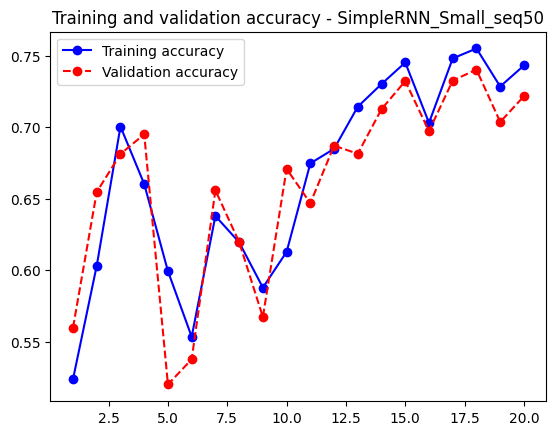

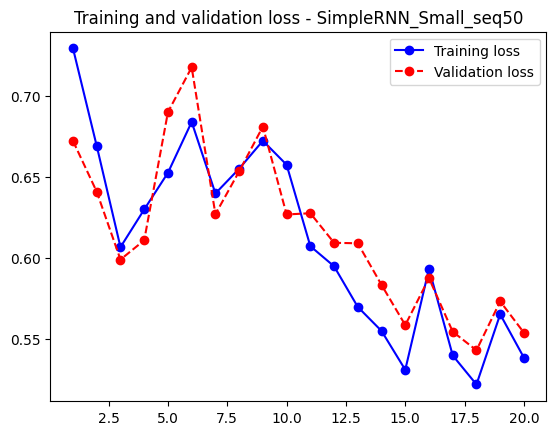


Testing SimpleRNN_Small with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5141 - loss: 0.7557

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5141 - loss: 0.7556 - val_accuracy: 0.5272 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5186 - loss: 0.7023

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5186 - loss: 0.7023 - val_accuracy: 0.5302 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5236 - loss: 0.6927 - val_accuracy: 0.5096 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5069 - loss: 0.6962

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5069 - loss: 0.6962 - val_accuracy: 0.5188 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5163 - loss: 0.6931

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5163 - loss: 0.6931 - val_accuracy: 0.5266 - val_loss: 0.6915 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5155 - loss: 0.6921

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5155 - loss: 0.6921 - val_accuracy: 0.5366 - val_loss: 0.6886 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5297 - loss: 0.6906 - val_accuracy: 0.5508 - val_loss: 0.6898 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5340 - loss: 0.6901 - val_accuracy: 0.5404 - val_loss: 0.6901 - learning_rate: 5.0000e-04
Epoch 9/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5281 - loss: 0.6916

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5282 - loss: 0.6916 - val_accuracy: 0.6156 - val_loss: 0.6667 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6311 - loss: 0.6589 - val_accuracy: 0.6074 - val_loss: 0.6703 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6073 - loss: 0.6696 - val_accuracy: 0.5968 - val_loss: 0.6790 - learning_rate: 5.0000e-04
Epoch 12/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5583 - loss: 0.6870

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5583 - loss: 0.6870 - val_accuracy: 0.6434 - val_loss: 0.6510 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6206 - loss: 0.6649 - val_accuracy: 0.6302 - val_loss: 0.6573 - learning_rate: 5.0000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6280 - loss: 0.6592 - val_accuracy: 0.6362 - val_loss: 0.6532 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6151 - loss: 0.6593 - val_accuracy: 0.5360 - val_loss: 0.6899 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5461 - loss: 0.6884 - val_accuracy: 0.5452 - val_loss: 0.6883 - learning_rate: 2.5000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5473 - loss: 0.6872 - val_accuracy: 0.5478 - val_loss: 0.6874 - learning_rate: 2.5000e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - a

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5943 - loss: 0.6659 - val_accuracy: 0.7160 - val_loss: 0.5933 - learning_rate: 1.2500e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7016 - loss: 0.6053


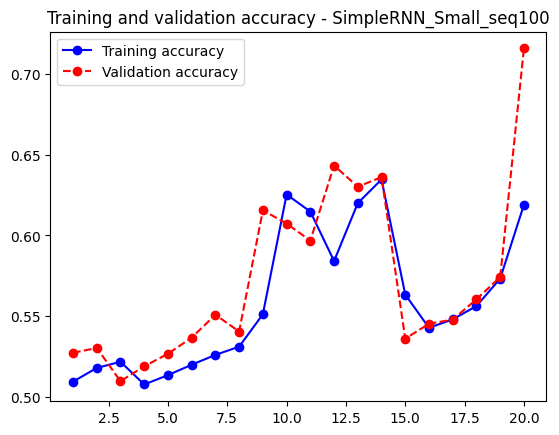

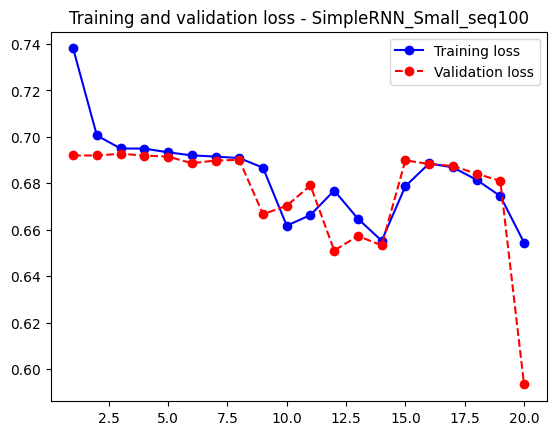


Testing SimpleRNN_Small with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4997 - loss: 0.7508

625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.4997 - loss: 0.7508 - val_accuracy: 0.5206 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5036 - loss: 0.7081 - val_accuracy: 0.4928 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5139 - loss: 0.6952 - val_accuracy: 0.5078 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5019 - loss: 0.6952 - val_accuracy: 0.5118 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5092 - loss: 0.6932 - val_accuracy: 0.5176 - val_loss: 0.6921 - learning_rate: 5.0000e-04
Epoch 6/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5113 - loss: 0.6930

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5113 - loss: 0.6930 - val_accuracy: 0.5194 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.4976 - loss: 0.6941 - val_accuracy: 0.5246 - val_loss: 0.6925 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5069 - loss: 0.6933 - val_accuracy: 0.5230 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5057 - loss: 0.6937 - val_accuracy: 0.5260 - val_loss: 0.6922 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5151 - loss: 0.6929 - val_accuracy: 0.5254 - val_loss: 0.6922 - learning_rate: 2.5000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5064 - loss: 0.6933 - val_accuracy: 0.5156 - val_loss: 0.6924 - learning_rate: 2.5000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accu

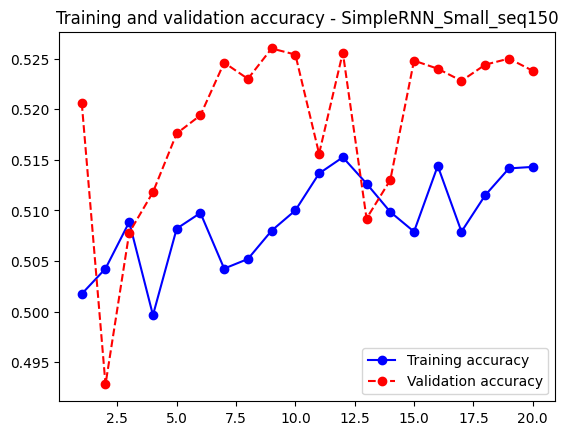

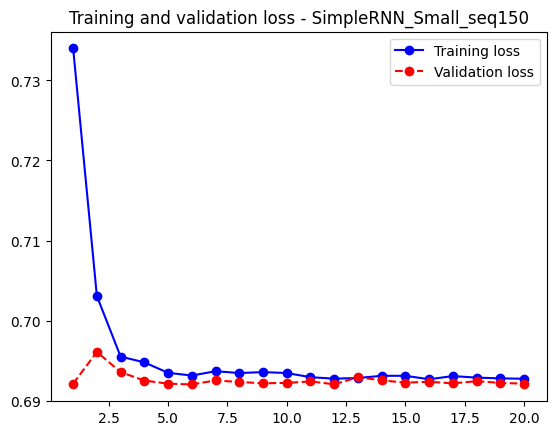


Testing SimpleRNN_Small with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_28 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4978 - loss: 0.7654

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.4978 - loss: 0.7653 - val_accuracy: 0.5272 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5011 - loss: 0.7094 - val_accuracy: 0.5108 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5014 - loss: 0.6976 - val_accuracy: 0.5062 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4997 - loss: 0.6951 - val_accuracy: 0.4876 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.5035 - loss: 0.6946 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5106 - loss: 0.6933 - val_accuracy: 0.5124 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4967 - loss

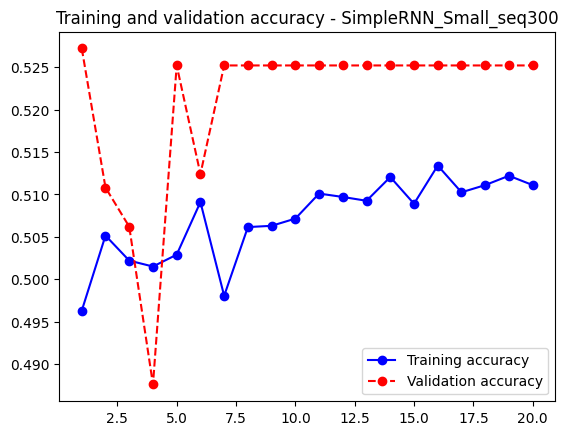

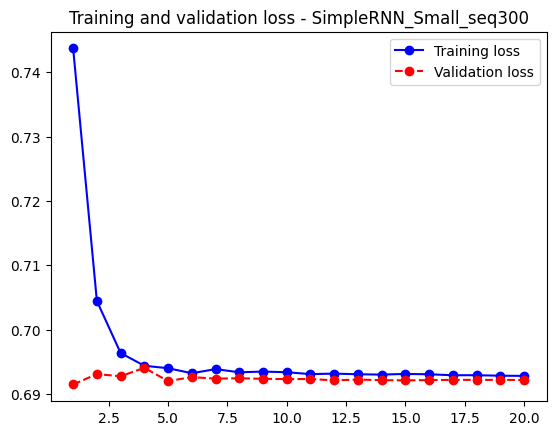


Testing SimpleRNN_Small with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_29 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_30 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5023 - loss: 0.7419

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.5023 - loss: 0.7419 - val_accuracy: 0.4762 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 2/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5022 - loss: 0.7049

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5022 - loss: 0.7049 - val_accuracy: 0.5480 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 3/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5143 - loss: 0.6954

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5144 - loss: 0.6953 - val_accuracy: 0.5702 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5758 - loss: 0.6810

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5758 - loss: 0.6810 - val_accuracy: 0.5856 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6460 - loss: 0.6352

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6460 - loss: 0.6352 - val_accuracy: 0.6694 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 6/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6852 - loss: 0.6022

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6852 - loss: 0.6022 - val_accuracy: 0.6708 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 7/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6865 - loss: 0.5988

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6865 - loss: 0.5988 - val_accuracy: 0.6568 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6739 - loss: 0.5980 - val_accuracy: 0.6548 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6720 - loss: 0.5950 - val_accuracy: 0.6568 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6802 - loss: 0.5874 - val_accuracy: 0.6542 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6736 - loss: 0.5908 - val_accuracy: 0.6578 - val_loss: 0.6132 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6762 - loss: 0.5858 - val_accuracy: 0.6562 - val_loss: 0.6121 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6610 - 

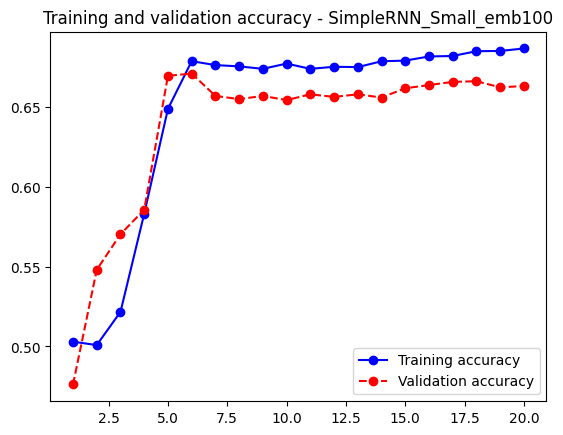

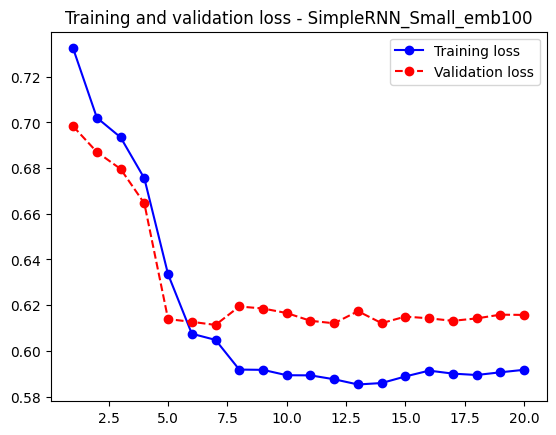


Testing SimpleRNN_Small with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_31 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_32 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5036 - loss: 0.7456

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5036 - loss: 0.7455 - val_accuracy: 0.5124 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5066 - loss: 0.7052

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5066 - loss: 0.7052 - val_accuracy: 0.4966 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5124 - loss: 0.6949

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5124 - loss: 0.6949 - val_accuracy: 0.5190 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5103 - loss: 0.6940

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5103 - loss: 0.6940 - val_accuracy: 0.5382 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5298 - loss: 0.6911

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5298 - loss: 0.6911 - val_accuracy: 0.5724 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5437 - loss: 0.6889 - val_accuracy: 0.5256 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5401 - loss: 0.6854 - val_accuracy: 0.5388 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 8/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5417 - loss: 0.6853

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5417 - loss: 0.6853 - val_accuracy: 0.5556 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5602 - loss: 0.6805 - val_accuracy: 0.5488 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5411 - loss: 0.6858 - val_accuracy: 0.4994 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5715 - loss: 0.6743

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5715 - loss: 0.6743 - val_accuracy: 0.6516 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6689 - loss: 0.6381 - val_accuracy: 0.5658 - val_loss: 0.6846 - learning_rate: 0.0010
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5948 - loss: 0.6750 - val_accuracy: 0.6166 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6187 - loss: 0.6629 - val_accuracy: 0.5994 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5976 - loss: 0.6730 - val_accuracy: 0.5584 - val_loss: 0.6827 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5507 - loss: 0.6851 - val_accuracy: 0.5576 - val_loss: 0.6850 - learning_rate: 5.0000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6147 

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6376 - loss: 0.6313 - val_accuracy: 0.6716 - val_loss: 0.6246 - learning_rate: 2.5000e-04
Epoch 19/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 0.6213

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6667 - loss: 0.6213 - val_accuracy: 0.6912 - val_loss: 0.6186 - learning_rate: 2.5000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6903 - loss: 0.6141 - val_accuracy: 0.6606 - val_loss: 0.6191 - learning_rate: 2.5000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6539 - loss: 0.6231


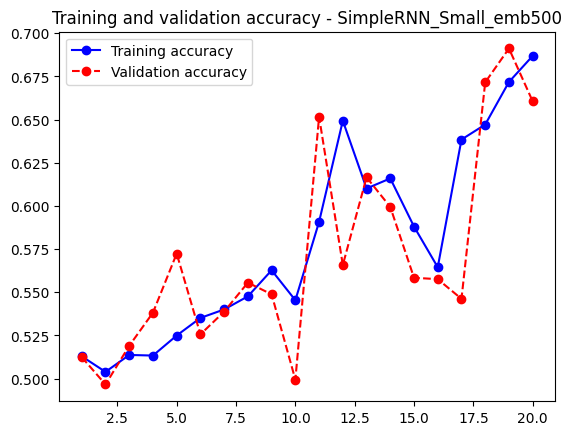

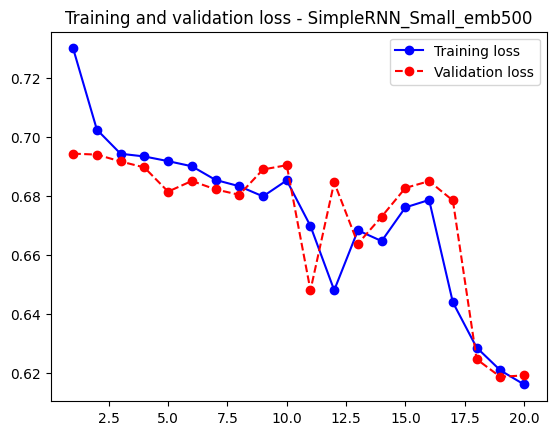


Testing SimpleRNN_Small with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_33 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_34 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5114 - loss: 0.7539

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5114 - loss: 0.7539 - val_accuracy: 0.5406 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5096 - loss: 0.7042

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5096 - loss: 0.7042 - val_accuracy: 0.5330 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5173 - loss: 0.6946

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5173 - loss: 0.6946 - val_accuracy: 0.5316 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5291 - loss: 0.6917

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5291 - loss: 0.6917 - val_accuracy: 0.5378 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5222 - loss: 0.6929

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5222 - loss: 0.6929 - val_accuracy: 0.5348 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5428 - loss: 0.6890

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5428 - loss: 0.6890 - val_accuracy: 0.5422 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5505 - loss: 0.6858 - val_accuracy: 0.4868 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5465 - loss: 0.6829 - val_accuracy: 0.4888 - val_loss: 0.7023 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5634 - loss: 0.6657 - val_accuracy: 0.5504 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5982 - loss: 0.6482 - val_accuracy: 0.5376 - val_loss: 0.7017 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5783 - loss: 0.6658 - val_accuracy: 0.5442 - val_loss: 0.7070 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6015 - l

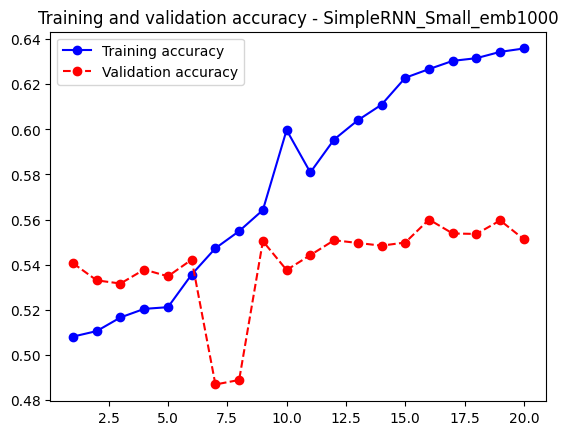

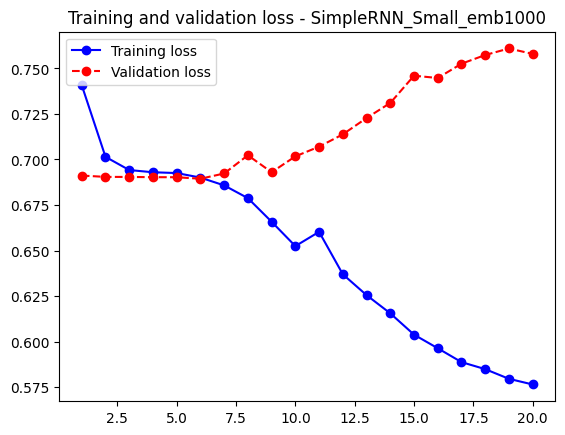


Testing SimpleRNN_Small with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_35 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_36 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5040 - loss: 0.7931

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.5040 - loss: 0.7931 - val_accuracy: 0.5318 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5205 - loss: 0.7067

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5205 - loss: 0.7067 - val_accuracy: 0.5314 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5444 - loss: 0.6870

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5444 - loss: 0.6870 - val_accuracy: 0.5620 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5741 - loss: 0.6704

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5741 - loss: 0.6704 - val_accuracy: 0.5402 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5736 - loss: 0.6720 - val_accuracy: 0.5342 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5684 - loss: 0.6731 - val_accuracy: 0.5420 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.5749 - loss: 0.6578 - val_accuracy: 0.5442 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5878 - loss: 0.6465 - val_accuracy: 0.5504 - val_loss: 0.7127 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5970 - loss: 0.6360 - val_accuracy: 0.5496 - val_loss: 0.7198 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.6097 - los

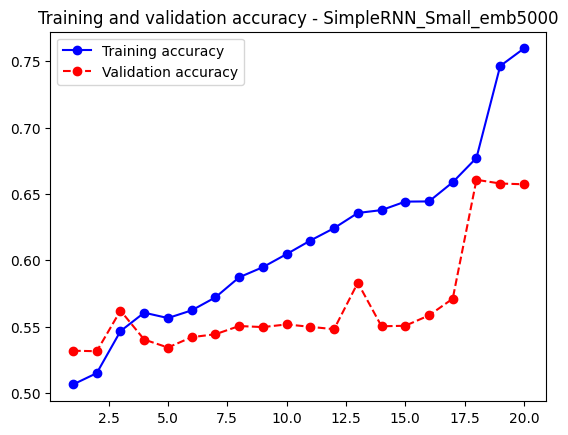

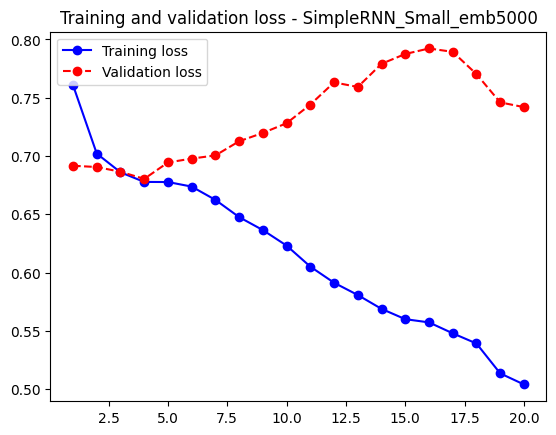


Testing SimpleRNN_Small with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_37 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_38 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4999 - loss: 0.7610

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4999 - loss: 0.7609 - val_accuracy: 0.5290 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5135 - loss: 0.7057

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5135 - loss: 0.7057 - val_accuracy: 0.5502 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5382 - loss: 0.6909 - val_accuracy: 0.5494 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5600 - loss: 0.6803

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5600 - loss: 0.6803 - val_accuracy: 0.6716 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6759 - loss: 0.6271 - val_accuracy: 0.6582 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6566 - loss: 0.6367 - val_accuracy: 0.4722 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5586 - loss: 0.6772 - val_accuracy: 0.5470 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6707 - loss: 0.6183 - val_accuracy: 0.6342 - val_loss: 0.6644 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6919 - loss: 0.6038 - val_accuracy: 0.6494 - val_loss: 0.6542 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6905 - los

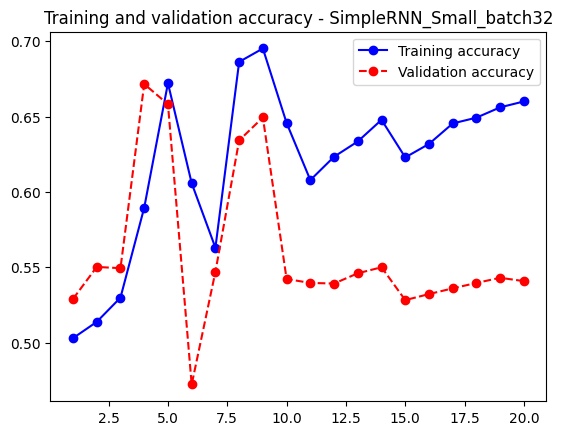

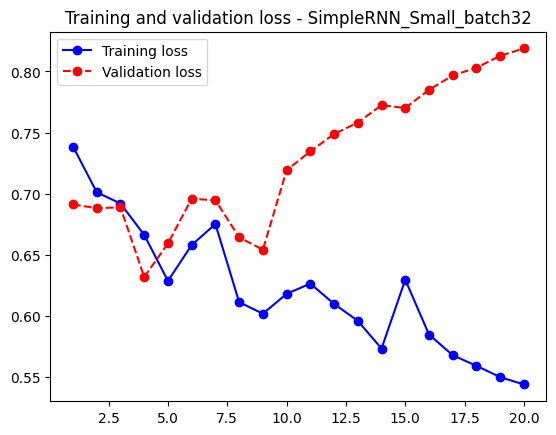


Testing SimpleRNN_Small with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_39 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_40 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5095 - loss: 0.7543

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.5095 - loss: 0.7542 - val_accuracy: 0.5354 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5315 - loss: 0.7012 - val_accuracy: 0.5160 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5585 - loss: 0.6790 - val_accuracy: 0.5374 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6039 - loss: 0.6432 - val_accuracy: 0.5218 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6024 - loss: 0.6512 - val_accuracy: 0.5294 - val_loss: 0.7516 - learning_rate: 5.0000e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6459 - loss: 0.5833 - val_accuracy: 0.5232 - val_loss: 0.8132 - learning_rate: 5.0000e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6770 - loss: 0.53

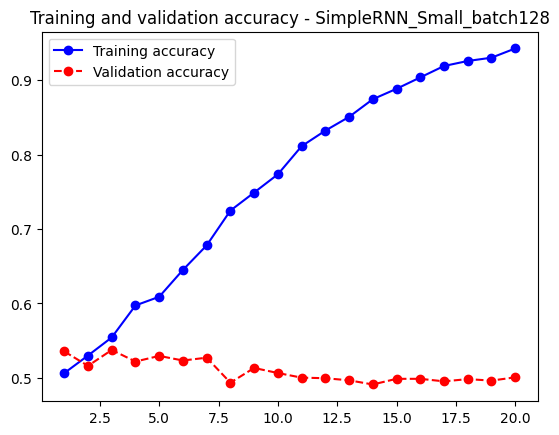

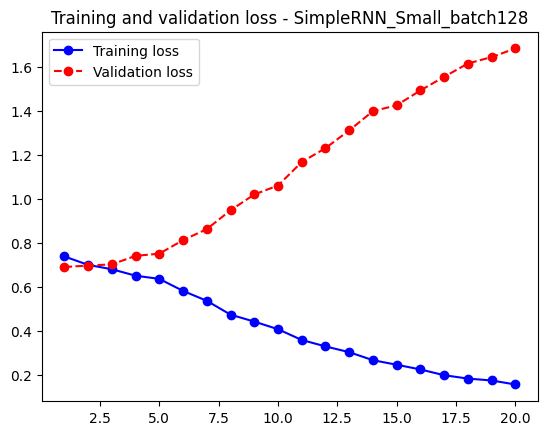


Testing SimpleRNN_Small with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_41 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4951 - loss: 0.7676

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.4952 - loss: 0.7674 - val_accuracy: 0.5030 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 2/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5167 - loss: 0.7171

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5168 - loss: 0.7169 - val_accuracy: 0.5254 - val_loss: 0.6954 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5495 - loss: 0.6895 - val_accuracy: 0.5266 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6011 - loss: 0.6507 - val_accuracy: 0.5022 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6483 - loss: 0.6004 - val_accuracy: 0.5202 - val_loss: 0.7776 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7180 - loss: 0.5238 - val_accuracy: 0.4752 - val_loss: 0.8965 - learning_rate: 5.0000e-04
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7584 - loss: 0.4583 - val_accuracy: 0.5072 - val_loss: 0.9782 - learning_rate: 5.0000e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8114 - loss: 0.3915 - val_accura

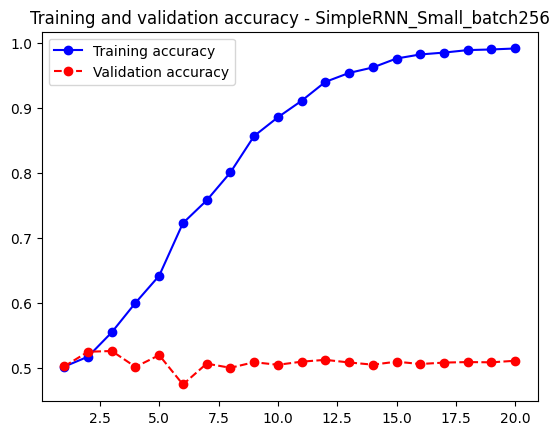

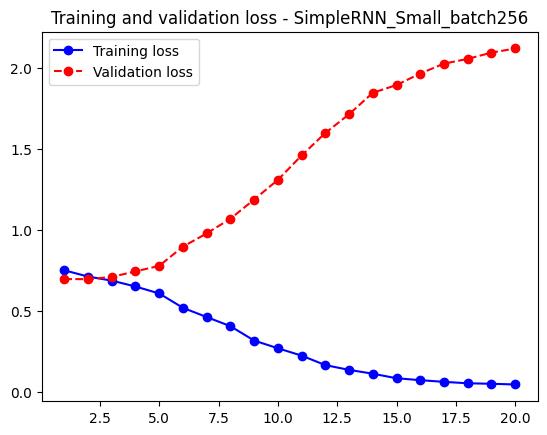


Testing SimpleRNN_Medium with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_43 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_44 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_45 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_46 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5005 - loss: 0.7829

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5004 - loss: 0.7828 - val_accuracy: 0.5268 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4970 - loss: 0.7099 - val_accuracy: 0.5216 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5131 - loss: 0.6938 - val_accuracy: 0.5338 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5244 - loss: 0.6917

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5245 - loss: 0.6917 - val_accuracy: 0.5352 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 5/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5372 - loss: 0.6902

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5372 - loss: 0.6902 - val_accuracy: 0.5536 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5395 - loss: 0.6897 - val_accuracy: 0.5246 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5028 - loss: 0.6939 - val_accuracy: 0.5480 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5218 - loss: 0.6908

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5219 - loss: 0.6908 - val_accuracy: 0.6230 - val_loss: 0.6584 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6369 - loss: 0.6492

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6369 - loss: 0.6492 - val_accuracy: 0.6232 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 10/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6413 - loss: 0.6430

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6413 - loss: 0.6429 - val_accuracy: 0.6230 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 11/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6433 - loss: 0.6376

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6433 - loss: 0.6376 - val_accuracy: 0.6224 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6403 - loss: 0.6379 - val_accuracy: 0.6220 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6453 - loss: 0.6394 - val_accuracy: 0.6222 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6350 - loss: 0.6435 - val_accuracy: 0.6224 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6409 - loss: 0.6382 - val_accuracy: 0.6224 - val_loss: 0.6463 - learning_rate: 5.0000e-04
Epoch 16/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6383 - loss: 0.6427

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6383 - loss: 0.6427 - val_accuracy: 0.6226 - val_loss: 0.6456 - learning_rate: 5.0000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6407 - loss: 0.6396 - val_accuracy: 0.6238 - val_loss: 0.6466 - learning_rate: 5.0000e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6386 - loss: 0.6407 - val_accuracy: 0.6238 - val_loss: 0.6463 - learning_rate: 5.0000e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6417 - loss: 0.6347

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6417 - loss: 0.6347 - val_accuracy: 0.6236 - val_loss: 0.6450 - learning_rate: 5.0000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6446 - loss: 0.6355 - val_accuracy: 0.6254 - val_loss: 0.6495 - learning_rate: 5.0000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6294 - loss: 0.6506


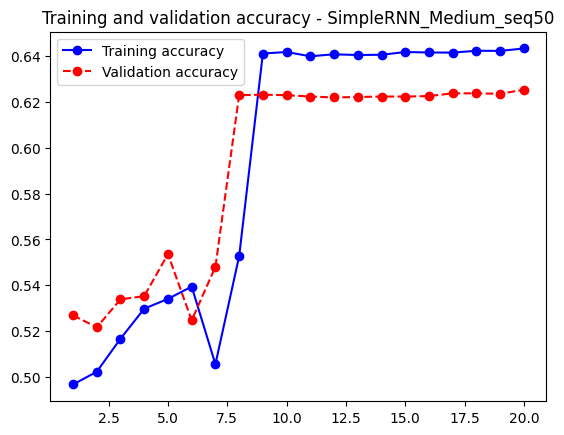

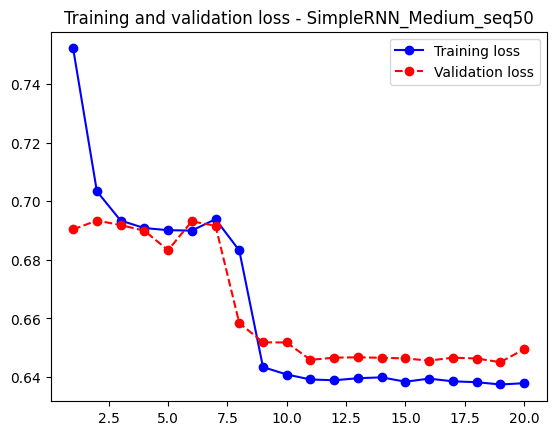


Testing SimpleRNN_Medium with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_47 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_48 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_49 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_50 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5052 - loss: 0.8104

625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.5053 - loss: 0.8103 - val_accuracy: 0.5336 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5047 - loss: 0.7126

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5046 - loss: 0.7126 - val_accuracy: 0.5282 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5054 - loss: 0.6964

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5055 - loss: 0.6964 - val_accuracy: 0.5278 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5132 - loss: 0.6941 - val_accuracy: 0.5290 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5058 - loss: 0.6945 - val_accuracy: 0.5296 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5146 - loss: 0.6932 - val_accuracy: 0.5320 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 7/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5262 - loss: 0.6919

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5262 - loss: 0.6919 - val_accuracy: 0.5326 - val_loss: 0.6911 - learning_rate: 5.0000e-04
Epoch 8/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5247 - loss: 0.6922

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5247 - loss: 0.6922 - val_accuracy: 0.5330 - val_loss: 0.6910 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.5260 - loss: 0.6921 - val_accuracy: 0.5330 - val_loss: 0.6911 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5257 - loss: 0.6921 - val_accuracy: 0.5336 - val_loss: 0.6922 - learning_rate: 5.0000e-04
Epoch 11/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5175 - loss: 0.6923

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5175 - loss: 0.6923 - val_accuracy: 0.5338 - val_loss: 0.6906 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5202 - loss: 0.6917 - val_accuracy: 0.5252 - val_loss: 0.6925 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5042 - loss: 0.6939 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5094 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5055 - loss: 0.6934 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 2.5000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5222 - loss: 0.6929 - val_accuracy: 0.4998 - val_loss: 0.6925 - learning_rate: 2.5000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - a

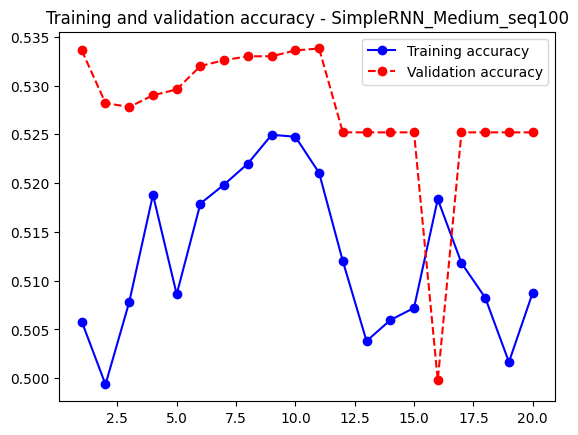

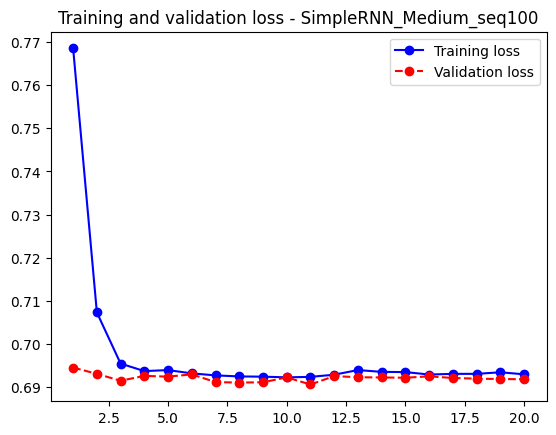


Testing SimpleRNN_Medium with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_51 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_52 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_53 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_54 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5051 - loss: 0.7965

625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5051 - loss: 0.7964 - val_accuracy: 0.4814 - val_loss: 0.7059 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5014 - loss: 0.7079

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5014 - loss: 0.7079 - val_accuracy: 0.5178 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5047 - loss: 0.6974 - val_accuracy: 0.5236 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5117 - loss: 0.6940

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5117 - loss: 0.6940 - val_accuracy: 0.5242 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.5031 - loss: 0.6944 - val_accuracy: 0.4762 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.5033 - loss: 0.6941 - val_accuracy: 0.5046 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.5113 - loss: 0.6937 - val_accuracy: 0.5206 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5108 - loss: 0.6940

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5107 - loss: 0.6940 - val_accuracy: 0.5192 - val_loss: 0.6925 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5084 - loss: 0.6940 - val_accuracy: 0.5198 - val_loss: 0.6936 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5234 - loss: 0.6921 - val_accuracy: 0.5238 - val_loss: 0.6929 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5220 - loss: 0.6919

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5220 - loss: 0.6919 - val_accuracy: 0.5266 - val_loss: 0.6920 - learning_rate: 2.5000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5201 - loss: 0.6925

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5201 - loss: 0.6925 - val_accuracy: 0.5280 - val_loss: 0.6919 - learning_rate: 2.5000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5248 - loss: 0.6915

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5248 - loss: 0.6915 - val_accuracy: 0.5284 - val_loss: 0.6919 - learning_rate: 2.5000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5183 - loss: 0.6918

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5183 - loss: 0.6918 - val_accuracy: 0.5342 - val_loss: 0.6909 - learning_rate: 2.5000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5252 - loss: 0.6911 - val_accuracy: 0.5300 - val_loss: 0.6917 - learning_rate: 2.5000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5315 - loss: 0.6899 - val_accuracy: 0.5234 - val_loss: 0.6938 - learning_rate: 2.5000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5234 - loss: 0.6903

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5234 - loss: 0.6903 - val_accuracy: 0.5338 - val_loss: 0.6900 - learning_rate: 2.5000e-04
Epoch 18/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5306 - loss: 0.6894

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5306 - loss: 0.6894 - val_accuracy: 0.5352 - val_loss: 0.6900 - learning_rate: 2.5000e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5349 - loss: 0.6861 - val_accuracy: 0.5320 - val_loss: 0.6935 - learning_rate: 2.5000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5339 - loss: 0.6851 - val_accuracy: 0.5326 - val_loss: 0.6923 - learning_rate: 2.5000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5232 - loss: 0.6933


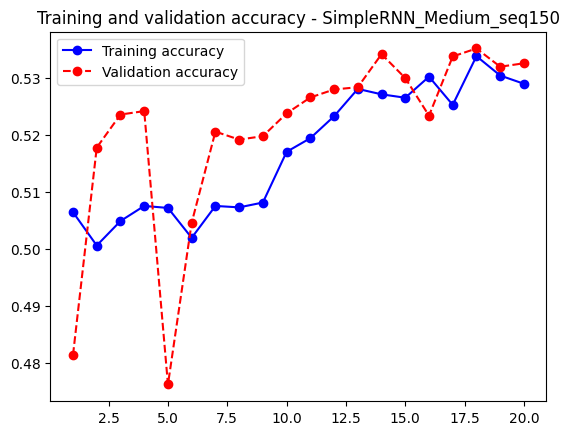

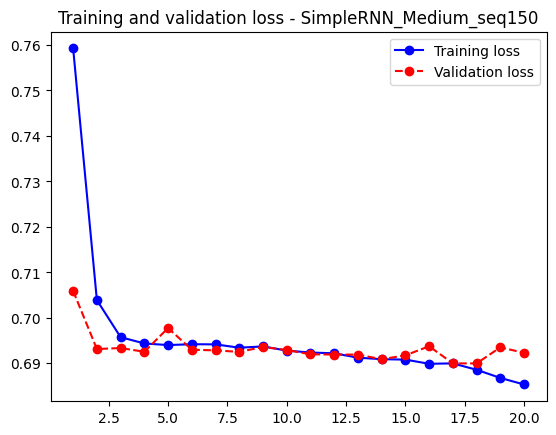


Testing SimpleRNN_Medium with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_55 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_56 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_57 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_58 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4993 - loss: 0.8108

625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.4993 - loss: 0.8107 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.4995 - loss: 0.7102 - val_accuracy: 0.4748 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.4971 - loss: 0.6963 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.5001 - loss: 0.6946 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.5082 - loss: 0.6941 - val_accuracy: 0.4748 - val_loss: 0.6936 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.5060 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5000 - loss

625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.5073 - loss: 0.6934 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 1.2500e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.5154 - loss: 0.6927 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 1.2500e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5114 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 1.2500e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 6.2500e-05
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5147 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 6.2500e-05
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5165 - loss: 0.6928 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 6.2500e-05
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - a

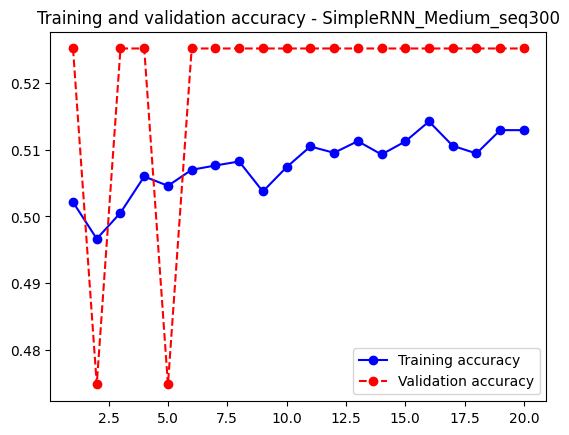

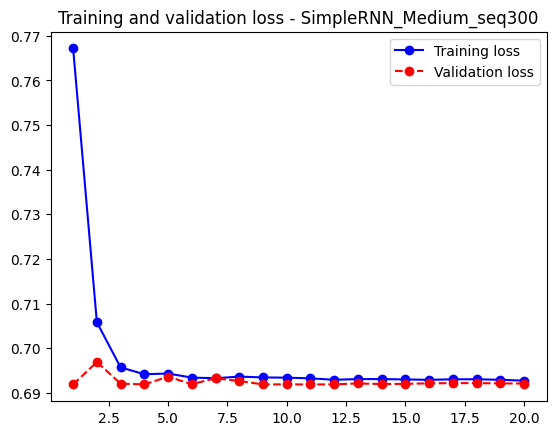


Testing SimpleRNN_Medium with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_59 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_60 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_61 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_62 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4983 - loss: 0.7977

625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.4983 - loss: 0.7977 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.4938 - loss: 0.7107 - val_accuracy: 0.4758 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5027 - loss: 0.6960 - val_accuracy: 0.4758 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5026 - loss: 0.6949 - val_accuracy: 0.4740 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5051 - loss: 0.6941

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5051 - loss: 0.6941 - val_accuracy: 0.5252 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5035 - loss: 0.6936 - val_accuracy: 0.5252 - val_loss: 0.6918 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5081 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5086 - loss: 0.6933 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4952 - loss: 0.6944

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.4952 - loss: 0.6944 - val_accuracy: 0.5262 - val_loss: 0.6917 - learning_rate: 2.5000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5101 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6925 - learning_rate: 2.5000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.5083 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 2.5000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5084 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 1.2500e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5148 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 1.2500e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5166 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 1.2500e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - a

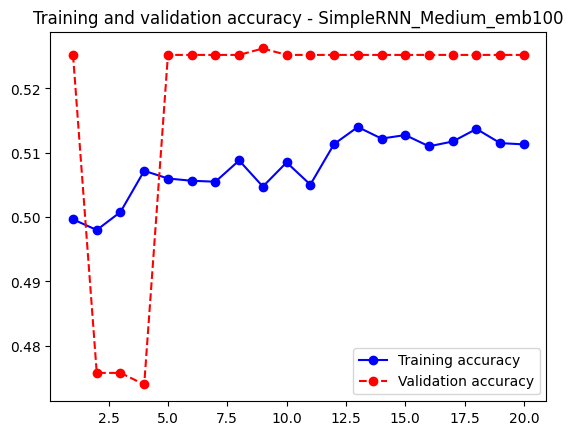

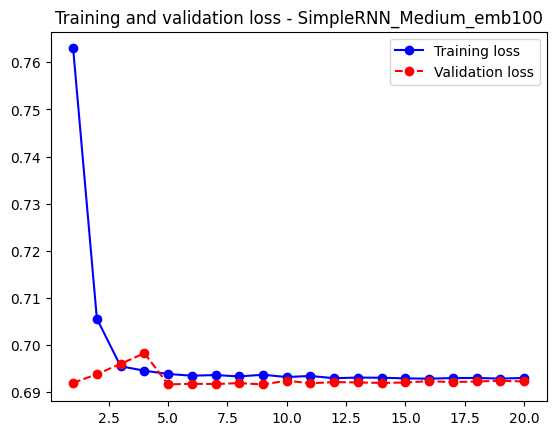


Testing SimpleRNN_Medium with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_63 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_64 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_65 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_66 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4984 - loss: 0.7889

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.4984 - loss: 0.7888 - val_accuracy: 0.4960 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5023 - loss: 0.7072

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5023 - loss: 0.7072 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5032 - loss: 0.6952 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5012 - loss: 0.6949

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5012 - loss: 0.6949 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.4979 - loss: 0.6952 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5039 - loss: 0.6945 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5090 - loss: 0.6940 - val_accuracy: 0.4746 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5059 - loss: 0.6940 - val_accuracy: 0.5254 - val_loss: 0.6924 - learning_rate: 5.0000e-04
Epoch 9/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5073 - loss: 0.6938

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5073 - loss: 0.6938 - val_accuracy: 0.5252 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5051 - loss: 0.6931

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.5254 - val_loss: 0.6916 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5054 - loss: 0.6938

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.5054 - loss: 0.6938 - val_accuracy: 0.5344 - val_loss: 0.6908 - learning_rate: 5.0000e-04
Epoch 12/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5133 - loss: 0.6932

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5133 - loss: 0.6932 - val_accuracy: 0.5396 - val_loss: 0.6892 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5357 - loss: 0.6913

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5356 - loss: 0.6913 - val_accuracy: 0.5546 - val_loss: 0.6858 - learning_rate: 5.0000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5389 - loss: 0.6883 - val_accuracy: 0.5542 - val_loss: 0.6862 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5567 - loss: 0.6831

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5567 - loss: 0.6831 - val_accuracy: 0.5618 - val_loss: 0.6836 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5663 - loss: 0.6804 - val_accuracy: 0.5640 - val_loss: 0.6963 - learning_rate: 5.0000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5696 - loss: 0.6777

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5696 - loss: 0.6777 - val_accuracy: 0.6486 - val_loss: 0.6418 - learning_rate: 5.0000e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5870 - loss: 0.6673 - val_accuracy: 0.5762 - val_loss: 0.6762 - learning_rate: 5.0000e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5599 - loss: 0.6813

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.5599 - loss: 0.6813 - val_accuracy: 0.6618 - val_loss: 0.6404 - learning_rate: 5.0000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6688 - loss: 0.6347

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6689 - loss: 0.6347 - val_accuracy: 0.6698 - val_loss: 0.6330 - learning_rate: 5.0000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6740 - loss: 0.6279


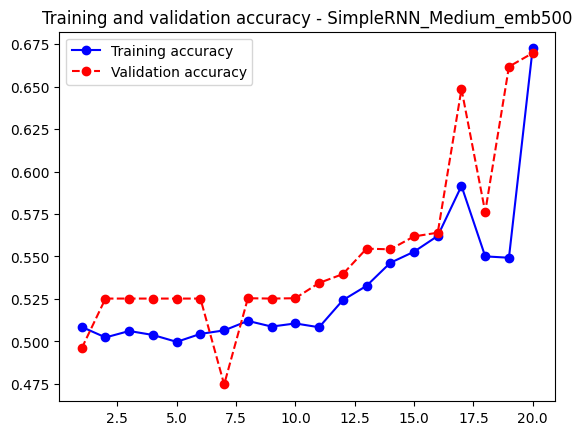

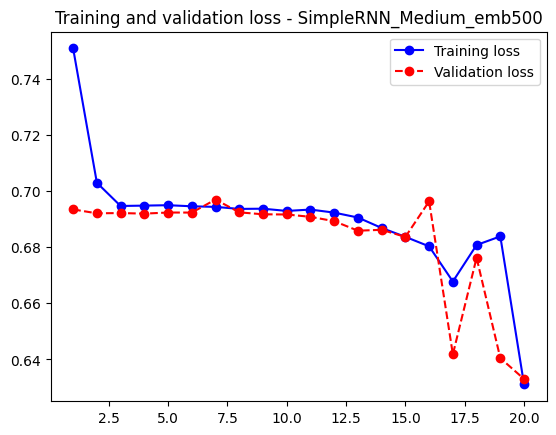


Testing SimpleRNN_Medium with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_67 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_68 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_69 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_70 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5071 - loss: 0.7882

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.5071 - loss: 0.7881 - val_accuracy: 0.5060 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5055 - loss: 0.7093

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.5055 - loss: 0.7093 - val_accuracy: 0.5332 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5133 - loss: 0.6950

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5133 - loss: 0.6950 - val_accuracy: 0.5304 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5043 - loss: 0.6947 - val_accuracy: 0.5318 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5144 - loss: 0.6940 - val_accuracy: 0.5326 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5260 - loss: 0.6927

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5260 - loss: 0.6927 - val_accuracy: 0.5334 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5186 - loss: 0.6933 - val_accuracy: 0.5334 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5229 - loss: 0.6924

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5229 - loss: 0.6924 - val_accuracy: 0.5336 - val_loss: 0.6906 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5223 - loss: 0.6923 - val_accuracy: 0.5328 - val_loss: 0.6914 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5207 - loss: 0.6929 - val_accuracy: 0.5334 - val_loss: 0.6907 - learning_rate: 2.5000e-04
Epoch 11/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5223 - loss: 0.6920

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5223 - loss: 0.6920 - val_accuracy: 0.5342 - val_loss: 0.6906 - learning_rate: 2.5000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5234 - loss: 0.6924 - val_accuracy: 0.5308 - val_loss: 0.6911 - learning_rate: 2.5000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.5268 - loss: 0.6915 - val_accuracy: 0.5328 - val_loss: 0.6908 - learning_rate: 2.5000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5238 - loss: 0.6923

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5238 - loss: 0.6923 - val_accuracy: 0.5332 - val_loss: 0.6905 - learning_rate: 2.5000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5289 - loss: 0.6914

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5289 - loss: 0.6914 - val_accuracy: 0.5360 - val_loss: 0.6903 - learning_rate: 1.2500e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5377 - loss: 0.6904

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5377 - loss: 0.6904 - val_accuracy: 0.5584 - val_loss: 0.6856 - learning_rate: 1.2500e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5443 - loss: 0.6885 - val_accuracy: 0.5038 - val_loss: 0.6918 - learning_rate: 1.2500e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5454 - loss: 0.6845 - val_accuracy: 0.5300 - val_loss: 0.6915 - learning_rate: 1.2500e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5193 - loss: 0.6926 - val_accuracy: 0.5332 - val_loss: 0.6906 - learning_rate: 1.2500e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5294 - loss: 0.6918 - val_accuracy: 0.5328 - val_loss: 0.6906 - learning_rate: 6.2500e-05
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5281 - loss: 0.6917


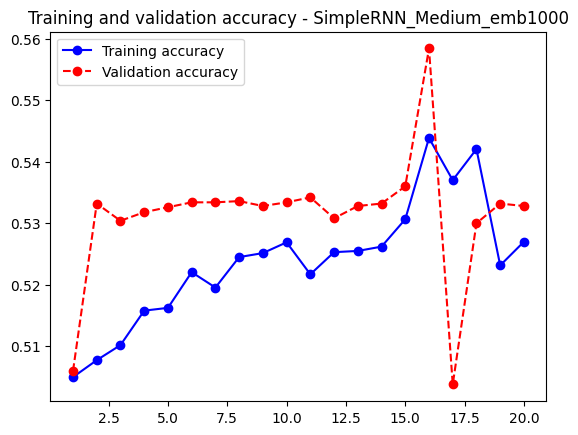

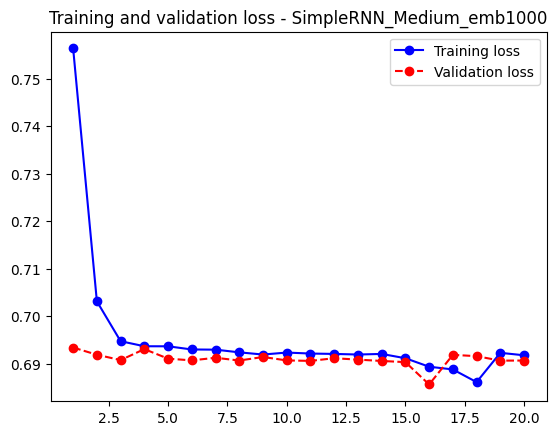


Testing SimpleRNN_Medium with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_71 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_72 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_73 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_74 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5008 - loss: 0.7929

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.5008 - loss: 0.7928 - val_accuracy: 0.5286 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5024 - loss: 0.7074

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.5024 - loss: 0.7074 - val_accuracy: 0.5336 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5242 - loss: 0.6939

625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5241 - loss: 0.6939 - val_accuracy: 0.5316 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5349 - loss: 0.6899

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5349 - loss: 0.6899 - val_accuracy: 0.5482 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5500 - loss: 0.6867 - val_accuracy: 0.5402 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5465 - loss: 0.6882 - val_accuracy: 0.5582 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5441 - loss: 0.6864 - val_accuracy: 0.4948 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5401 - loss: 0.6868

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5401 - loss: 0.6868 - val_accuracy: 0.6226 - val_loss: 0.6676 - learning_rate: 5.0000e-04
Epoch 9/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6068 - loss: 0.6652

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6069 - loss: 0.6652 - val_accuracy: 0.6580 - val_loss: 0.6484 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5752 - loss: 0.6779 - val_accuracy: 0.5578 - val_loss: 0.6850 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.5441 - loss: 0.6879 - val_accuracy: 0.6186 - val_loss: 0.6738 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5160 - loss: 0.6918 - val_accuracy: 0.4972 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5290 - loss: 0.6885 - val_accuracy: 0.4968 - val_loss: 0.6916 - learning_rate: 2.5000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5365 - loss: 0.6866 - val_accuracy: 0.5052 - val_loss: 0.6887 - learning_rate: 2.5000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - a

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.6021 - loss: 0.6677 - val_accuracy: 0.6506 - val_loss: 0.6429 - learning_rate: 1.2500e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6365 - loss: 0.6501

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.6366 - loss: 0.6501 - val_accuracy: 0.6734 - val_loss: 0.6317 - learning_rate: 1.2500e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6714 - loss: 0.6292 - val_accuracy: 0.6678 - val_loss: 0.6364 - learning_rate: 1.2500e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.6777 - loss: 0.6264 - val_accuracy: 0.6618 - val_loss: 0.6392 - learning_rate: 1.2500e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6899 - loss: 0.6130

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6899 - loss: 0.6130 - val_accuracy: 0.6782 - val_loss: 0.6179 - learning_rate: 1.2500e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6757 - loss: 0.6197


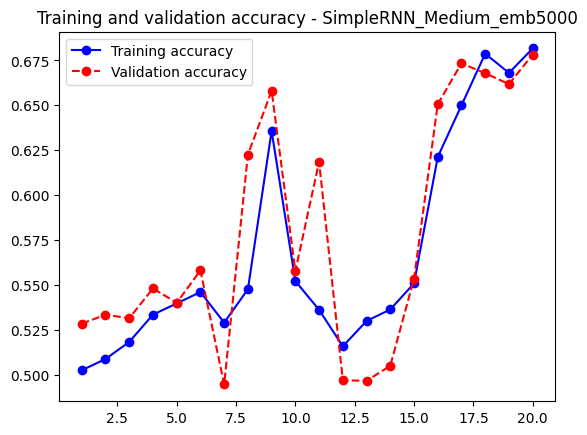

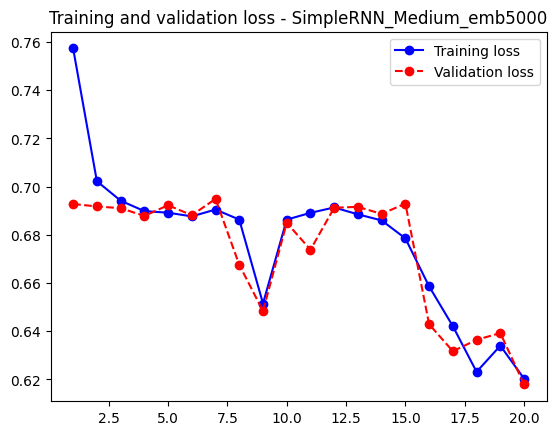


Testing SimpleRNN_Medium with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_75 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_76 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_77 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_78 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4999 - loss: 0.7973

625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.4999 - loss: 0.7972 - val_accuracy: 0.5346 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5081 - loss: 0.7069

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5081 - loss: 0.7069 - val_accuracy: 0.5308 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5031 - loss: 0.6967

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5031 - loss: 0.6967 - val_accuracy: 0.5266 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5069 - loss: 0.6942 - val_accuracy: 0.5326 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5151 - loss: 0.6936 - val_accuracy: 0.5312 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5150 - loss: 0.6932 - val_accuracy: 0.5410 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5204 - loss: 0.6930 - val_accuracy: 0.5356 - val_loss: 0.6899 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5172 - loss: 0.6930 - val_accuracy: 0.5412 - val_loss: 0.6902 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5258 - loss:

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.5258 - loss: 0.6916 - val_accuracy: 0.5496 - val_loss: 0.6882 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5426 - loss: 0.6895

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5426 - loss: 0.6895 - val_accuracy: 0.6024 - val_loss: 0.6763 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5986 - loss: 0.6723

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5986 - loss: 0.6723 - val_accuracy: 0.6218 - val_loss: 0.6625 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6239 - loss: 0.6597

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6239 - loss: 0.6597 - val_accuracy: 0.6364 - val_loss: 0.6541 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6278 - loss: 0.6594 - val_accuracy: 0.5990 - val_loss: 0.6757 - learning_rate: 5.0000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5961 - loss: 0.6698

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5962 - loss: 0.6698 - val_accuracy: 0.6416 - val_loss: 0.6502 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6349 - loss: 0.6553 - val_accuracy: 0.5566 - val_loss: 0.6833 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5526 - loss: 0.6834 - val_accuracy: 0.5440 - val_loss: 0.6872 - learning_rate: 5.0000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5524 - loss: 0.6848 - val_accuracy: 0.6138 - val_loss: 0.6623 - learning_rate: 5.0000e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5757 - loss: 0.6755 - val_accuracy: 0.5872 - val_loss: 0.6785 - learning_rate: 2.5000e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5804 - loss: 0.6793 - val_accuracy: 0.6244 - val_loss: 0.6641 - learning_rate: 2.5000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - a

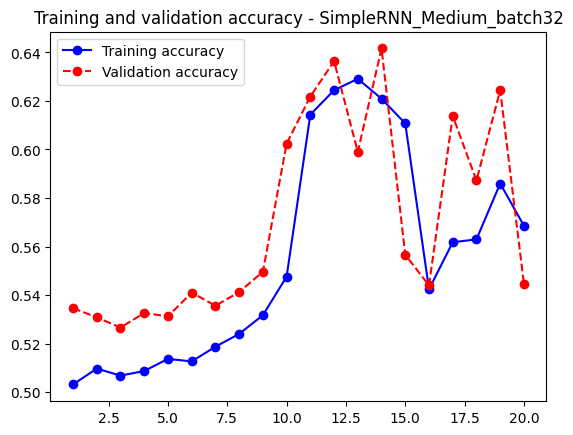

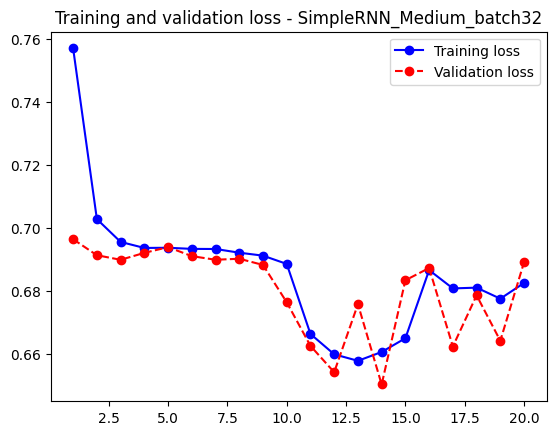


Testing SimpleRNN_Medium with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_45 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_79 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_80 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_81 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_82 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4894 - loss: 0.8077

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.4894 - loss: 0.8075 - val_accuracy: 0.5276 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5025 - loss: 0.7277 - val_accuracy: 0.5268 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5165 - loss: 0.7035 - val_accuracy: 0.5268 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5072 - loss: 0.6987

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5073 - loss: 0.6987 - val_accuracy: 0.5332 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5140 - loss: 0.6957 - val_accuracy: 0.5258 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 6/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5210 - loss: 0.6928

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5209 - loss: 0.6928 - val_accuracy: 0.5344 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5251 - loss: 0.6922

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5250 - loss: 0.6922 - val_accuracy: 0.5386 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5356 - loss: 0.6904

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5356 - loss: 0.6904 - val_accuracy: 0.5694 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5337 - loss: 0.6890 - val_accuracy: 0.5650 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5614 - loss: 0.6830 - val_accuracy: 0.5642 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5578 - loss: 0.6815 - val_accuracy: 0.5634 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5628 - loss: 0.6789 - val_accuracy: 0.5636 - val_loss: 0.6826 - learning_rate: 5.0000e-04
Epoch 13/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5682 - loss: 0.6792

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5681 - loss: 0.6792 - val_accuracy: 0.5634 - val_loss: 0.6805 - learning_rate: 5.0000e-04
Epoch 14/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5608 - loss: 0.6771 - val_accuracy: 0.5634 - val_loss: 0.6814 - learning_rate: 5.0000e-04
Epoch 15/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5558 - loss: 0.6793 - val_accuracy: 0.5632 - val_loss: 0.6835 - learning_rate: 5.0000e-04
Epoch 16/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5573 - loss: 0.6791 - val_accuracy: 0.5630 - val_loss: 0.6814 - learning_rate: 5.0000e-04
Epoch 17/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5595 - loss: 0.6787 - val_accuracy: 0.5630 - val_loss: 0.6815 - learning_rate: 2.5000e-04
Epoch 18/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5585 - loss: 0.6778 - val_accuracy: 0.5626 - val_loss: 0.6815 - learning_rate: 2.5000e-04
Epoch 19/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - ac

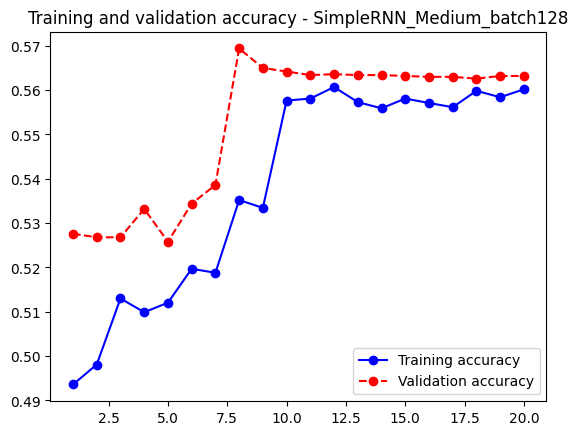

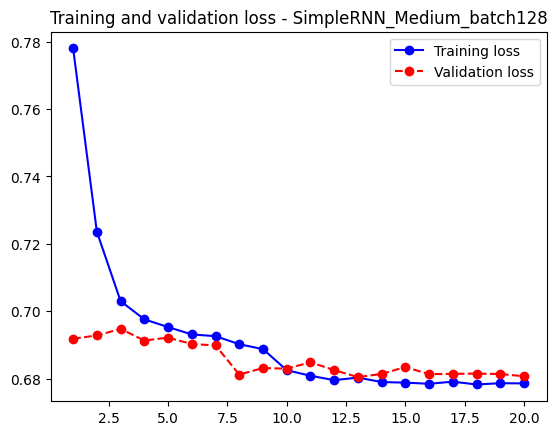


Testing SimpleRNN_Medium with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_83 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_84 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_85 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_86 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5043 - loss: 0.8011

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.5043 - loss: 0.8009 - val_accuracy: 0.5334 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5028 - loss: 0.7501

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5028 - loss: 0.7500 - val_accuracy: 0.5338 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5113 - loss: 0.7217

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5112 - loss: 0.7216 - val_accuracy: 0.5280 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5102 - loss: 0.7106 - val_accuracy: 0.5338 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5054 - loss: 0.7048 - val_accuracy: 0.5246 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5077 - loss: 0.6988 - val_accuracy: 0.5208 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5047 - loss: 0.6976

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5046 - loss: 0.6976 - val_accuracy: 0.5240 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5117 - loss: 0.6967 - val_accuracy: 0.5276 - val_loss: 0.6912 - learning_rate: 5.0000e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5024 - loss: 0.6960 - val_accuracy: 0.5274 - val_loss: 0.6926 - learning_rate: 5.0000e-04
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5163 - loss: 0.6941 - val_accuracy: 0.5308 - val_loss: 0.6914 - learning_rate: 5.0000e-04
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5143 - loss: 0.6929 - val_accuracy: 0.5320 - val_loss: 0.6914 - learning_rate: 2.5000e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5195 - loss: 0.6928 - val_accuracy: 0.5322 - val_loss: 0.6919 - learning_rate: 2.5000e-04
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5131 - loss:

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5131 - loss: 0.6934 - val_accuracy: 0.5402 - val_loss: 0.6897 - learning_rate: 2.5000e-04
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5221 - loss: 0.6920 - val_accuracy: 0.5184 - val_loss: 0.6942 - learning_rate: 2.5000e-04
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5276 - loss: 0.6919 - val_accuracy: 0.5328 - val_loss: 0.6909 - learning_rate: 2.5000e-04
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5104 - loss: 0.6937 - val_accuracy: 0.5312 - val_loss: 0.6910 - learning_rate: 2.5000e-04
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5226 - loss: 0.6928 - val_accuracy: 0.5324 - val_loss: 0.6903 - learning_rate: 1.2500e-04
Epoch 18/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5189 - loss: 0.6920 - val_accuracy: 0.5366 - val_loss: 0.6901 - learning_rate: 1.2500e-04
Epoch 19/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5227 - los

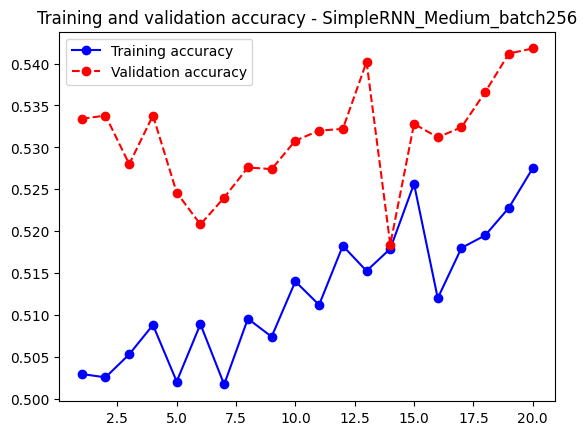

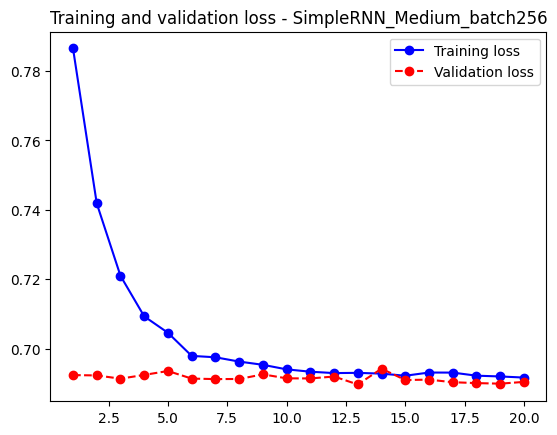


Testing LSTM_Small with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_47 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6554 - loss: 0.6170

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6557 - loss: 0.6168 - val_accuracy: 0.7452 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7567 - loss: 0.5273

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7567 - loss: 0.5273 - val_accuracy: 0.7724 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8140 - loss: 0.4269

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8140 - loss: 0.4269 - val_accuracy: 0.8258 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8550 - loss: 0.3310

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8550 - loss: 0.3310 - val_accuracy: 0.8376 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8706 - loss: 0.2968 - val_accuracy: 0.8384 - val_loss: 0.3711 - learning_rate: 0.0010
Epoch 6/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8839 - loss: 0.2726

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8839 - loss: 0.2726 - val_accuracy: 0.8384 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 7/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8902 - loss: 0.2597

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8901 - loss: 0.2597 - val_accuracy: 0.8416 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 8/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8994 - loss: 0.2390

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8994 - loss: 0.2390 - val_accuracy: 0.8374 - val_loss: 0.3538 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9112 - loss: 0.2164 - val_accuracy: 0.8386 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9230 - loss: 0.1957 - val_accuracy: 0.8382 - val_loss: 0.4281 - learning_rate: 0.0010
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9326 - loss: 0.1761 - val_accuracy: 0.8372 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9451 - loss: 0.1505 - val_accuracy: 0.8370 - val_loss: 0.4903 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9592 - loss: 0.1192 - val_accuracy: 0.8390 - val_loss: 0.5473 - learning_rate: 5.0000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9662 - los

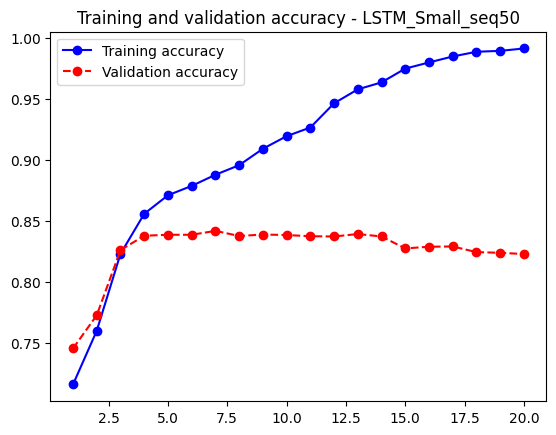

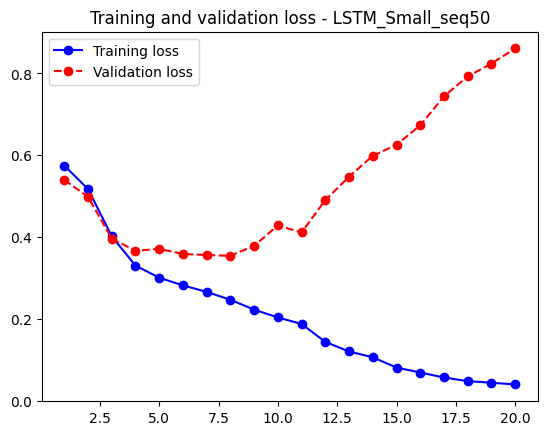


Testing LSTM_Small with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_48 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5212 - loss: 0.6955

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5213 - loss: 0.6955 - val_accuracy: 0.5388 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6306 - loss: 0.6410

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6310 - loss: 0.6407 - val_accuracy: 0.8138 - val_loss: 0.4274 - learning_rate: 0.0010
Epoch 3/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8492 - loss: 0.3653

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8493 - loss: 0.3652 - val_accuracy: 0.8470 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8863 - loss: 0.2868 - val_accuracy: 0.8590 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8964 - loss: 0.2569 - val_accuracy: 0.8464 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9161 - loss: 0.2195

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9161 - loss: 0.2195 - val_accuracy: 0.8608 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9227 - loss: 0.2090 - val_accuracy: 0.8592 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9346 - loss: 0.1764 - val_accuracy: 0.8634 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9449 - loss: 0.1585 - val_accuracy: 0.8554 - val_loss: 0.3872 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9578 - loss: 0.1223 - val_accuracy: 0.8534 - val_loss: 0.4602 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9649 - loss: 0.1035 - val_accuracy: 0.8530 - val_loss: 0.4888 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9678 - los

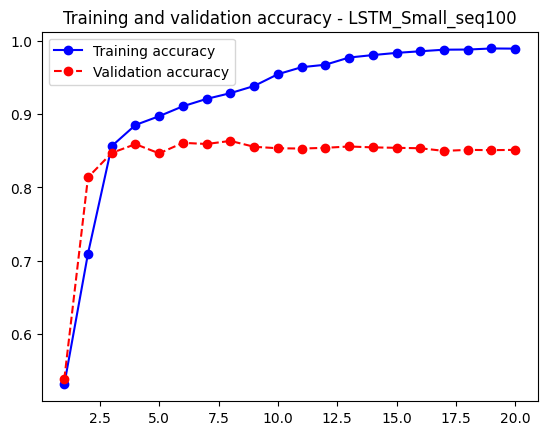

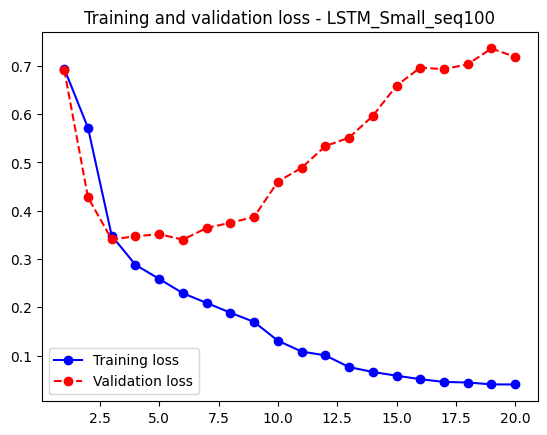


Testing LSTM_Small with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_49 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4992 - loss: 0.6964

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4992 - loss: 0.6964 - val_accuracy: 0.5310 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5336 - loss: 0.6910

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5336 - loss: 0.6910 - val_accuracy: 0.5320 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5816 - loss: 0.6634

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5818 - loss: 0.6633 - val_accuracy: 0.7824 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8329 - loss: 0.3986

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8329 - loss: 0.3985 - val_accuracy: 0.8522 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8838 - loss: 0.2881

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8838 - loss: 0.2881 - val_accuracy: 0.8600 - val_loss: 0.3321 - learning_rate: 0.0010
Epoch 6/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9028 - loss: 0.2534

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9028 - loss: 0.2534 - val_accuracy: 0.8624 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9140 - loss: 0.2202 - val_accuracy: 0.8618 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9287 - loss: 0.1869 - val_accuracy: 0.8658 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9324 - loss: 0.1820 - val_accuracy: 0.8678 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9455 - loss: 0.1506 - val_accuracy: 0.8656 - val_loss: 0.3929 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9545 - loss: 0.1312 - val_accuracy: 0.8660 - val_loss: 0.3997 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9602 - l

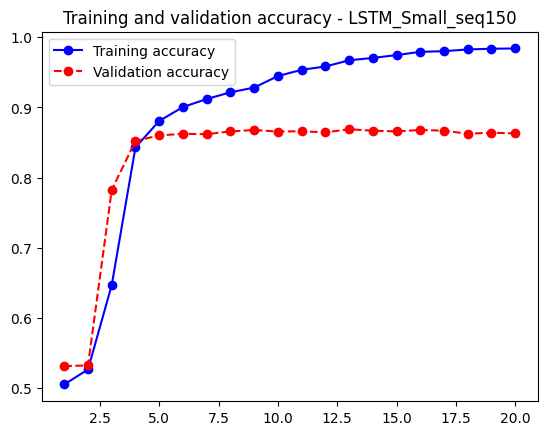

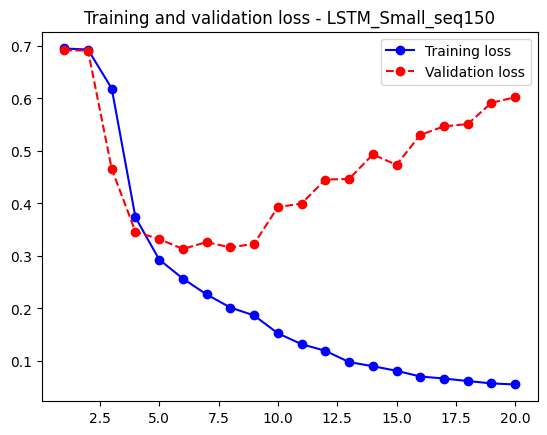


Testing LSTM_Small with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5017 - loss: 0.6970

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5017 - loss: 0.6970 - val_accuracy: 0.5252 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5070 - loss: 0.6935

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5070 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5127 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5113 - loss: 0.6930

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5113 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5071 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.5153 - loss: 0.6927 - val_accuracy: 0.5252 - val_loss: 0.6924 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5172 - loss: 0.6927 - val_accuracy: 0.5252 - val_loss: 0.6924 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5137 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 2.5000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.51

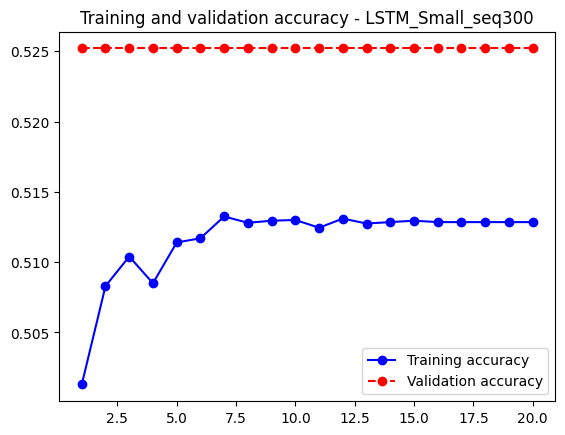

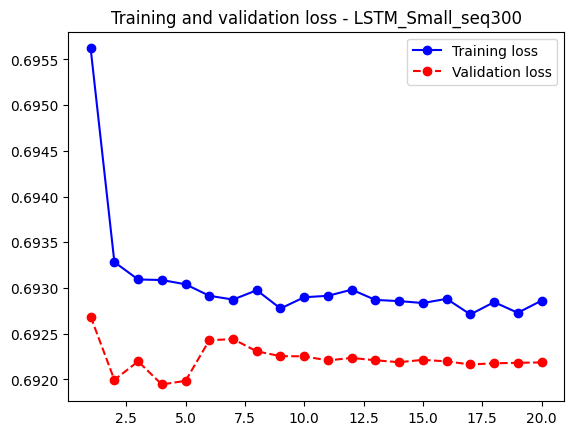


Testing LSTM_Small with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_51 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5178 - loss: 0.6921

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5178 - loss: 0.6921 - val_accuracy: 0.5512 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6297 - loss: 0.6439

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6298 - loss: 0.6438 - val_accuracy: 0.6738 - val_loss: 0.6170 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7100 - loss: 0.5744

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7101 - loss: 0.5743 - val_accuracy: 0.7280 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7624 - loss: 0.5099 - val_accuracy: 0.6908 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7187 - loss: 0.5477 - val_accuracy: 0.6728 - val_loss: 0.6164 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6926 - loss: 0.5832 - val_accuracy: 0.6796 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 7/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7136 - loss: 0.5387

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7136 - loss: 0.5386 - val_accuracy: 0.7896 - val_loss: 0.5177 - learning_rate: 5.0000e-04
Epoch 8/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7769 - loss: 0.4884

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7770 - loss: 0.4883 - val_accuracy: 0.8104 - val_loss: 0.4335 - learning_rate: 5.0000e-04
Epoch 9/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8443 - loss: 0.4036

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8443 - loss: 0.4035 - val_accuracy: 0.8374 - val_loss: 0.3780 - learning_rate: 5.0000e-04
Epoch 10/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8647 - loss: 0.3494

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8647 - loss: 0.3493 - val_accuracy: 0.8394 - val_loss: 0.3598 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8779 - loss: 0.3158

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8779 - loss: 0.3158 - val_accuracy: 0.8512 - val_loss: 0.3383 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8855 - loss: 0.2940 - val_accuracy: 0.8550 - val_loss: 0.3389 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8957 - loss: 0.2737

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8957 - loss: 0.2737 - val_accuracy: 0.8542 - val_loss: 0.3357 - learning_rate: 5.0000e-04
Epoch 14/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9013 - loss: 0.2619

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9013 - loss: 0.2619 - val_accuracy: 0.8544 - val_loss: 0.3239 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9024 - loss: 0.2500 - val_accuracy: 0.8518 - val_loss: 0.3448 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9020 - loss: 0.2475 - val_accuracy: 0.8568 - val_loss: 0.3271 - learning_rate: 5.0000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9164 - loss: 0.2252 - val_accuracy: 0.8620 - val_loss: 0.3410 - learning_rate: 5.0000e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9228 - loss: 0.2067 - val_accuracy: 0.8638 - val_loss: 0.3439 - learning_rate: 2.5000e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9252 - loss: 0.2070 - val_accuracy: 0.8634 - val_loss: 0.3634 - learning_rate: 2.5000e-04
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - a

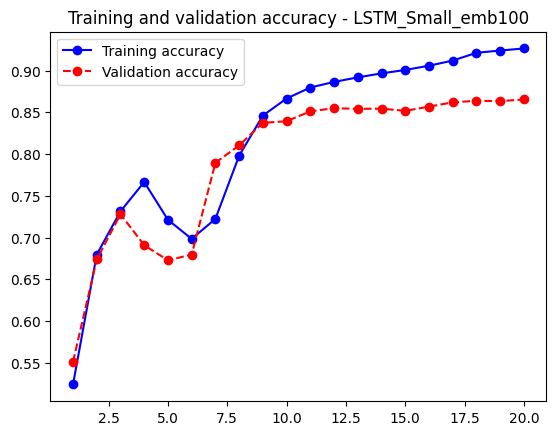

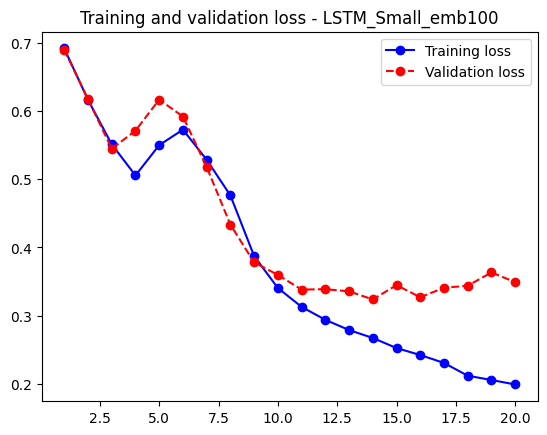


Testing LSTM_Small with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_52 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5226 - loss: 0.6910

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5226 - loss: 0.6910 - val_accuracy: 0.5538 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5837 - loss: 0.6604

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5838 - loss: 0.6603 - val_accuracy: 0.7950 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7816 - loss: 0.4911

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7816 - loss: 0.4911 - val_accuracy: 0.8190 - val_loss: 0.4396 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8581 - loss: 0.3814

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8581 - loss: 0.3813 - val_accuracy: 0.8320 - val_loss: 0.3780 - learning_rate: 0.0010
Epoch 5/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8857 - loss: 0.2904

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8857 - loss: 0.2904 - val_accuracy: 0.8550 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8991 - loss: 0.2627 - val_accuracy: 0.8558 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9073 - loss: 0.2450 - val_accuracy: 0.8592 - val_loss: 0.3659 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9112 - loss: 0.2232 - val_accuracy: 0.8630 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9307 - loss: 0.1860 - val_accuracy: 0.8576 - val_loss: 0.3671 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9393 - loss: 0.1742 - val_accuracy: 0.8576 - val_loss: 0.3920 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9465 - los

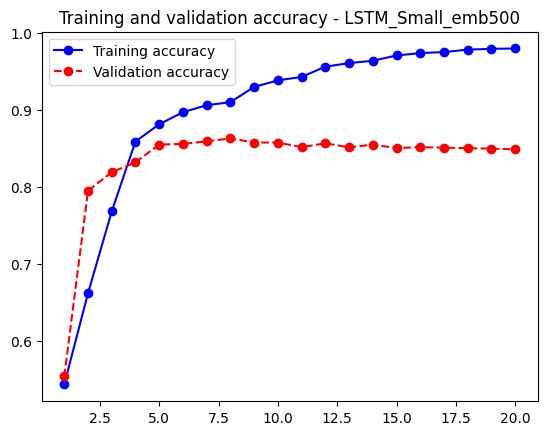

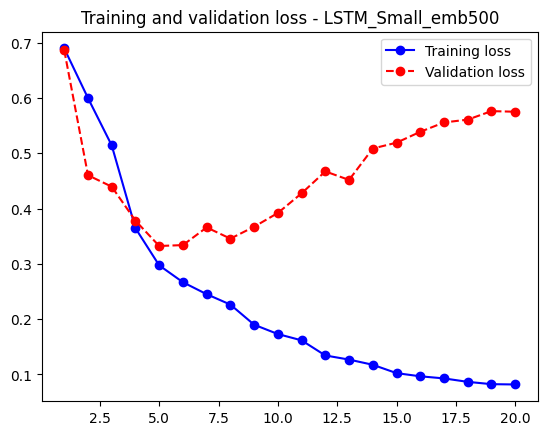


Testing LSTM_Small with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_53 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5204 - loss: 0.6958

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5205 - loss: 0.6958 - val_accuracy: 0.6232 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6883 - loss: 0.6037

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6883 - loss: 0.6036 - val_accuracy: 0.8292 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8516 - loss: 0.3491

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8516 - loss: 0.3491 - val_accuracy: 0.8546 - val_loss: 0.3345 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8882 - loss: 0.2803 - val_accuracy: 0.8544 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9009 - loss: 0.2427

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9009 - loss: 0.2427 - val_accuracy: 0.8544 - val_loss: 0.3325 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9194 - loss: 0.2040 - val_accuracy: 0.8566 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9274 - loss: 0.1883 - val_accuracy: 0.8588 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9368 - loss: 0.1708 - val_accuracy: 0.8562 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9505 - loss: 0.1371 - val_accuracy: 0.8572 - val_loss: 0.4356 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9625 - loss: 0.1113 - val_accuracy: 0.8602 - val_loss: 0.4915 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9713 - lo

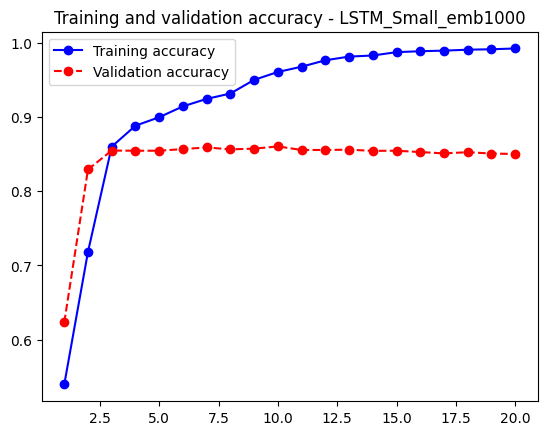

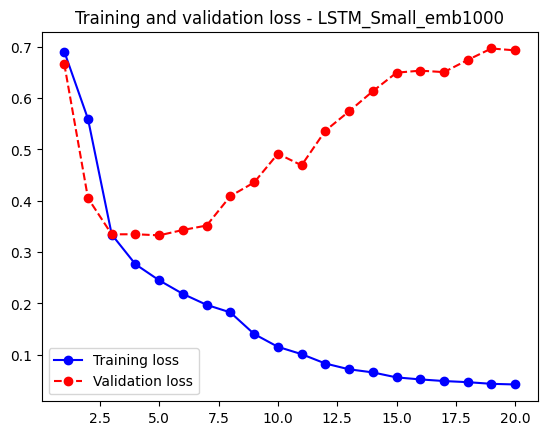


Testing LSTM_Small with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_54 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5393 - loss: 0.6900

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5395 - loss: 0.6899 - val_accuracy: 0.7804 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8254 - loss: 0.4095

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.8254 - loss: 0.4094 - val_accuracy: 0.8508 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8801 - loss: 0.2999

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8801 - loss: 0.3000 - val_accuracy: 0.8512 - val_loss: 0.3455 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8888 - loss: 0.2810 - val_accuracy: 0.8496 - val_loss: 0.3557 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9038 - loss: 0.2477 - val_accuracy: 0.8538 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9128 - loss: 0.2269 - val_accuracy: 0.8568 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9240 - loss: 0.1956 - val_accuracy: 0.8550 - val_loss: 0.3692 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9406 - loss: 0.1583 - val_accuracy: 0.8530 - val_loss: 0.4271 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9497 - loss

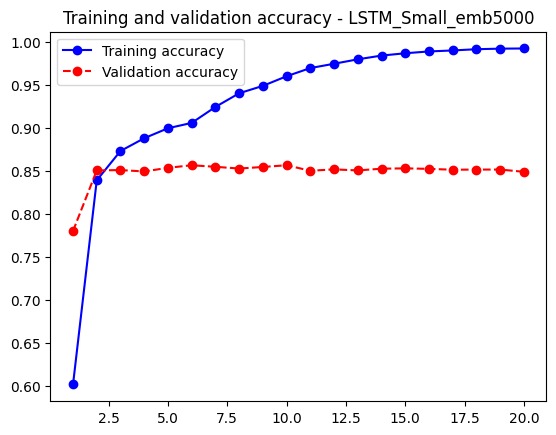

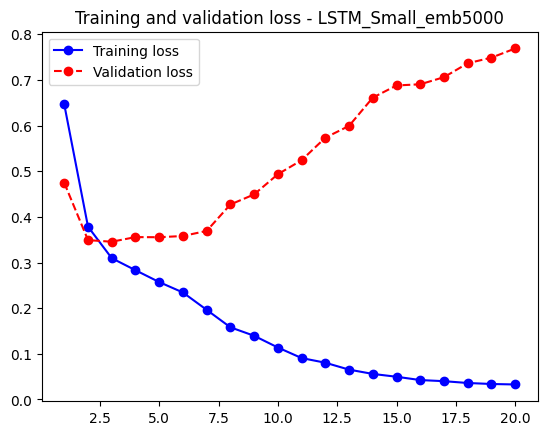


Testing LSTM_Small with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_55 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5257 - loss: 0.6910

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5259 - loss: 0.6909 - val_accuracy: 0.6974 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 2/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6936 - loss: 0.6020

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6935 - loss: 0.6021 - val_accuracy: 0.6382 - val_loss: 0.6054 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7268 - loss: 0.5479

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7271 - loss: 0.5476 - val_accuracy: 0.8136 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 4/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8362 - loss: 0.4076

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8363 - loss: 0.4075 - val_accuracy: 0.8344 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8788 - loss: 0.3040

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8788 - loss: 0.3040 - val_accuracy: 0.8510 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8914 - loss: 0.2759 - val_accuracy: 0.8486 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9062 - loss: 0.2474 - val_accuracy: 0.8494 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9169 - loss: 0.2216 - val_accuracy: 0.8486 - val_loss: 0.3587 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9280 - loss: 0.1950 - val_accuracy: 0.8554 - val_loss: 0.3475 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9405 - loss: 0.1645 - val_accuracy: 0.8590 - val_loss: 0.3982 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9502 - lo

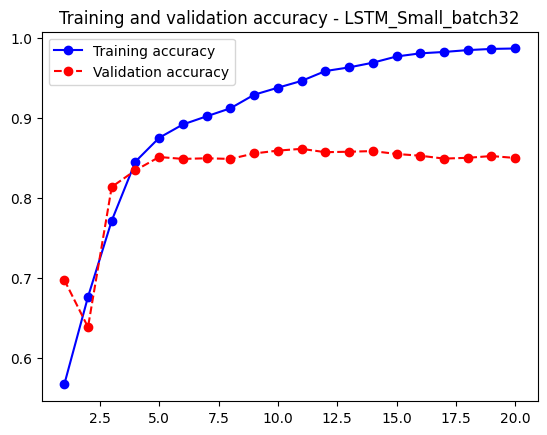

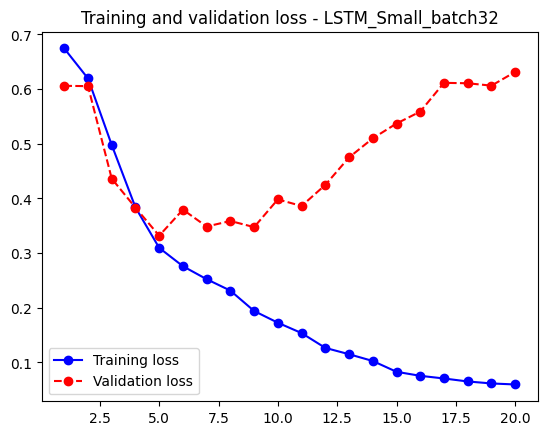


Testing LSTM_Small with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_56 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5164 - loss: 0.6945

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5165 - loss: 0.6945 - val_accuracy: 0.5328 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5675 - loss: 0.6802 - val_accuracy: 0.5370 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5163 - loss: 0.6967

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5165 - loss: 0.6967 - val_accuracy: 0.5796 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 4/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7085 - loss: 0.5616

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7094 - loss: 0.5605 - val_accuracy: 0.8386 - val_loss: 0.3693 - learning_rate: 0.0010
Epoch 5/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8595 - loss: 0.3408

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8596 - loss: 0.3406 - val_accuracy: 0.8576 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8979 - loss: 0.2702

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8979 - loss: 0.2703 - val_accuracy: 0.8602 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9045 - loss: 0.2463 - val_accuracy: 0.8594 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9188 - loss: 0.2164 - val_accuracy: 0.8618 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9295 - loss: 0.1963 - val_accuracy: 0.8528 - val_loss: 0.3511 - learning_rate: 0.0010
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9360 - loss: 0.1749 - val_accuracy: 0.8584 - val_loss: 0.3737 - learning_rate: 5.0000e-04
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9467 - loss: 0.1561 - val_accuracy: 0.8548 - val_loss: 0.4301 - learning_rate: 5.0000e-04
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9529 - loss: 0.

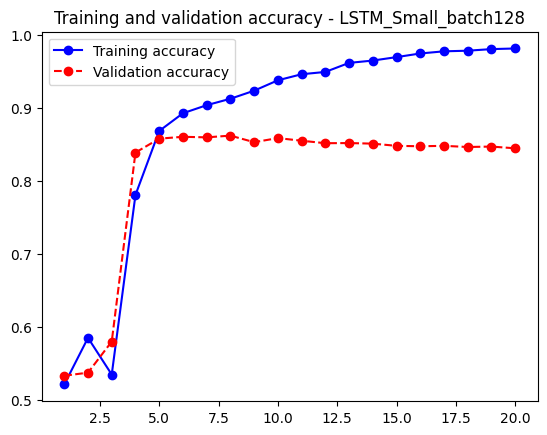

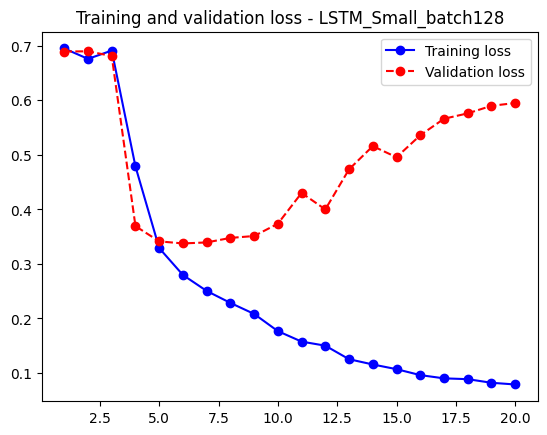


Testing LSTM_Small with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_57 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5193 - loss: 0.6938

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5200 - loss: 0.6936 - val_accuracy: 0.5738 - val_loss: 0.6749 - learning_rate: 0.0010
Epoch 2/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6554 - loss: 0.6276

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6561 - loss: 0.6273 - val_accuracy: 0.6972 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7138 - loss: 0.5896 - val_accuracy: 0.6922 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 4/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7032 - loss: 0.5995

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7040 - loss: 0.5988 - val_accuracy: 0.7354 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7414 - loss: 0.5632 - val_accuracy: 0.7058 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7247 - loss: 0.5600 - val_accuracy: 0.5902 - val_loss: 0.6452 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5796 - loss: 0.6499 - val_accuracy: 0.5732 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5651 - loss: 0.6640 - val_accuracy: 0.5776 - val_loss: 0.6657 - learning_rate: 5.0000e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5691 - loss: 0.6581 - val_accuracy: 0.5982 - val_loss: 0.6541 - learning_rate: 5.0000e-04
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5867 - loss: 0.6528 - val_accur

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6968 - loss: 0.6045 - val_accuracy: 0.7674 - val_loss: 0.5516 - learning_rate: 2.5000e-04
Epoch 14/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7874 - loss: 0.5274

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7875 - loss: 0.5270 - val_accuracy: 0.7694 - val_loss: 0.5076 - learning_rate: 2.5000e-04
Epoch 15/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8149 - loss: 0.4613

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8150 - loss: 0.4608 - val_accuracy: 0.8038 - val_loss: 0.4476 - learning_rate: 2.5000e-04
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8341 - loss: 0.4069

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8342 - loss: 0.4067 - val_accuracy: 0.8372 - val_loss: 0.3897 - learning_rate: 2.5000e-04
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8537 - loss: 0.3657

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8538 - loss: 0.3656 - val_accuracy: 0.8366 - val_loss: 0.3870 - learning_rate: 2.5000e-04
Epoch 18/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8718 - loss: 0.3331

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8718 - loss: 0.3332 - val_accuracy: 0.8364 - val_loss: 0.3839 - learning_rate: 2.5000e-04
Epoch 19/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8805 - loss: 0.3159

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8805 - loss: 0.3160 - val_accuracy: 0.8438 - val_loss: 0.3597 - learning_rate: 2.5000e-04
Epoch 20/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8810 - loss: 0.3045 - val_accuracy: 0.8458 - val_loss: 0.3657 - learning_rate: 2.5000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8569 - loss: 0.3520


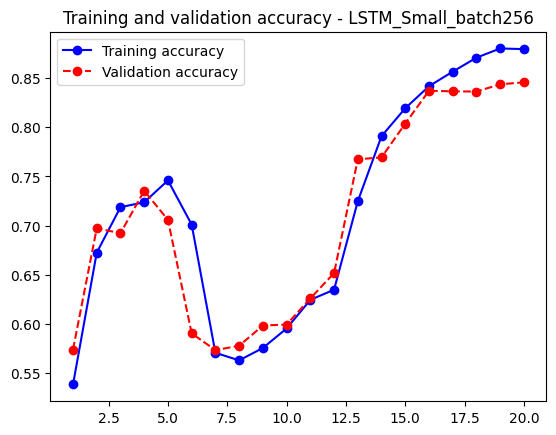

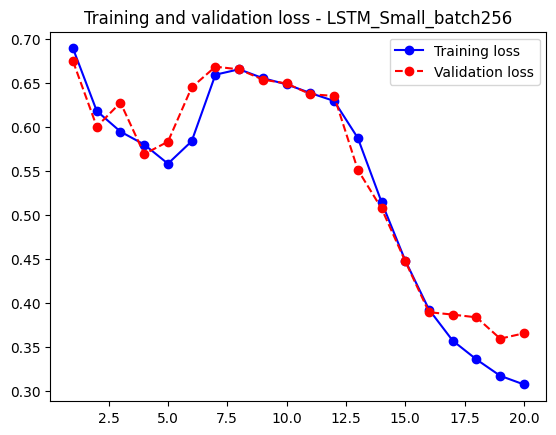


Testing LSTM_Medium with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_58 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6464 - loss: 0.6208

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6465 - loss: 0.6207 - val_accuracy: 0.7842 - val_loss: 0.4744 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8315 - loss: 0.4060 - val_accuracy: 0.7582 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8312 - loss: 0.3830

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8313 - loss: 0.3829 - val_accuracy: 0.8356 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 4/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8607 - loss: 0.3279

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8607 - loss: 0.3279 - val_accuracy: 0.8286 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8702 - loss: 0.3035 - val_accuracy: 0.8380 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8835 - loss: 0.2779 - val_accuracy: 0.8352 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8746 - loss: 0.2895 - val_accuracy: 0.8398 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9003 - loss: 0.2428 - val_accuracy: 0.8394 - val_loss: 0.3921 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9085 - loss: 0.2192 - val_accuracy: 0.8422 - val_loss: 0.3928 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9185 - loss:

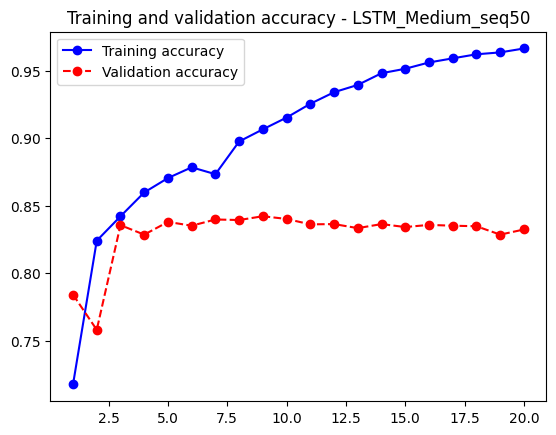

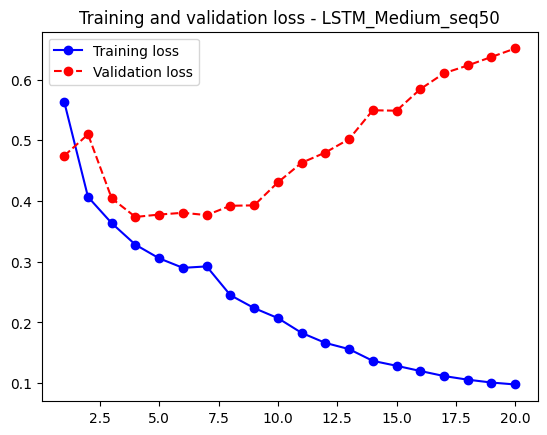


Testing LSTM_Medium with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_59 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5344 - loss: 0.6923

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5344 - loss: 0.6923 - val_accuracy: 0.6680 - val_loss: 0.6346 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6497 - loss: 0.6337

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6497 - loss: 0.6337 - val_accuracy: 0.6306 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.5689 - loss: 0.6690 - val_accuracy: 0.5650 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6599 - loss: 0.6217

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6600 - loss: 0.6216 - val_accuracy: 0.7662 - val_loss: 0.5150 - learning_rate: 0.0010
Epoch 5/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7355 - loss: 0.5399

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7356 - loss: 0.5398 - val_accuracy: 0.8128 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 6/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8428 - loss: 0.3755

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8428 - loss: 0.3755 - val_accuracy: 0.8324 - val_loss: 0.3747 - learning_rate: 0.0010
Epoch 7/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8711 - loss: 0.3260

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8711 - loss: 0.3259 - val_accuracy: 0.8396 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 8/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8828 - loss: 0.2926

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8828 - loss: 0.2927 - val_accuracy: 0.8446 - val_loss: 0.3536 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8930 - loss: 0.2708 - val_accuracy: 0.8528 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9047 - loss: 0.2520

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9047 - loss: 0.2521 - val_accuracy: 0.8512 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9127 - loss: 0.2282 - val_accuracy: 0.8504 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9198 - loss: 0.2150 - val_accuracy: 0.8508 - val_loss: 0.3689 - learning_rate: 0.0010
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9226 - loss: 0.2030 - val_accuracy: 0.8472 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9368 - loss: 0.1780 - val_accuracy: 0.8498 - val_loss: 0.3949 - learning_rate: 5.0000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9484 - loss: 0.1564 - val_accuracy: 0.8464 - val_loss: 0.3925 - learning_rate: 5.0000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9552 

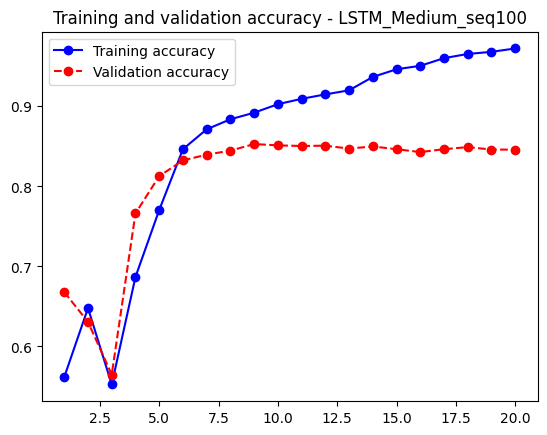

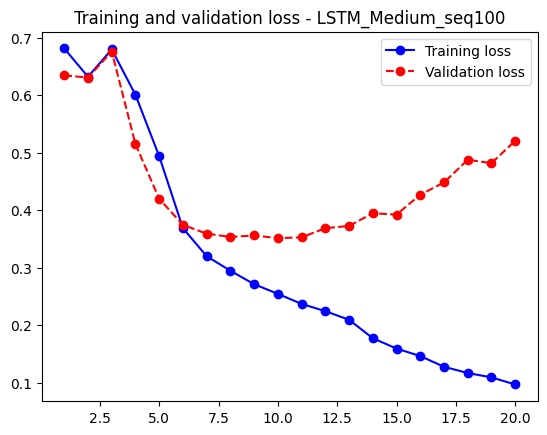


Testing LSTM_Medium with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_60 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5077 - loss: 0.6970

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.5077 - loss: 0.6970 - val_accuracy: 0.5288 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5352 - loss: 0.6908 - val_accuracy: 0.5292 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5204 - loss: 0.6905 - val_accuracy: 0.5324 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5348 - loss: 0.6815 - val_accuracy: 0.5376 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6097 - loss: 0.6497

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6097 - loss: 0.6497 - val_accuracy: 0.6924 - val_loss: 0.5994 - learning_rate: 5.0000e-04
Epoch 6/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7465 - loss: 0.5516

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7466 - loss: 0.5515 - val_accuracy: 0.7848 - val_loss: 0.5041 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8229 - loss: 0.4186 - val_accuracy: 0.7898 - val_loss: 0.5446 - learning_rate: 5.0000e-04
Epoch 8/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8192 - loss: 0.4321

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8193 - loss: 0.4320 - val_accuracy: 0.8428 - val_loss: 0.3614 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8823 - loss: 0.3009

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8823 - loss: 0.3009 - val_accuracy: 0.8554 - val_loss: 0.3388 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8947 - loss: 0.2703 - val_accuracy: 0.8600 - val_loss: 0.3479 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9037 - loss: 0.2467 - val_accuracy: 0.8586 - val_loss: 0.3518 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9145 - loss: 0.2299 - val_accuracy: 0.8630 - val_loss: 0.3623 - learning_rate: 5.0000e-04
Epoch 13/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9286 - loss: 0.2001

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9286 - loss: 0.2001 - val_accuracy: 0.8712 - val_loss: 0.3207 - learning_rate: 2.5000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9318 - loss: 0.1853 - val_accuracy: 0.8702 - val_loss: 0.3646 - learning_rate: 2.5000e-04
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9377 - loss: 0.1739 - val_accuracy: 0.8716 - val_loss: 0.3630 - learning_rate: 2.5000e-04
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9446 - loss: 0.1619 - val_accuracy: 0.8670 - val_loss: 0.3760 - learning_rate: 2.5000e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9494 - loss: 0.1477 - val_accuracy: 0.8724 - val_loss: 0.4043 - learning_rate: 1.2500e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9546 - loss: 0.1358 - val_accuracy: 0.8706 - val_loss: 0.3907 - learning_rate: 1.2500e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - a

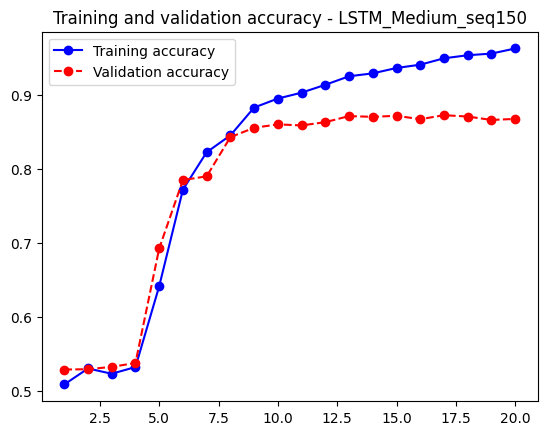

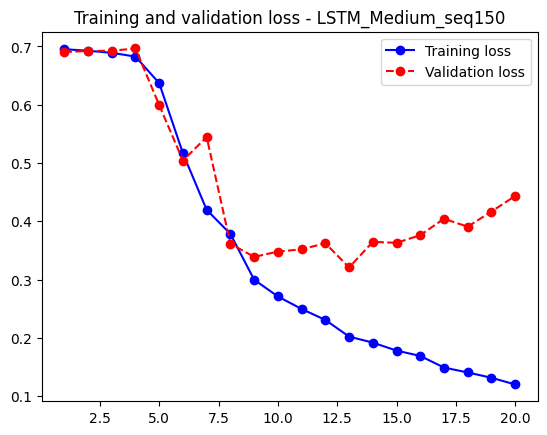


Testing LSTM_Medium with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_61 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5004 - loss: 0.6972

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5004 - loss: 0.6972 - val_accuracy: 0.4748 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5065 - loss: 0.6934

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5065 - loss: 0.6934 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5064 - loss: 0.6933 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5141 - loss: 0.6926 - val_accuracy: 0.5252 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 6/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5053 - loss: 0.6932

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5054 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5149 - loss: 0.6928 - val_accuracy: 0.5252 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 8/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5040 - loss: 0.6933

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5041 - loss: 0.6933 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5077 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5081 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 2.5000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5141 - loss: 0.6929 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 2.5000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5106 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 2.5000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5156 - loss: 0.6927 - val_accuracy: 0.5252 - val_loss: 0.6922 - learning_rate: 1.2500e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - ac

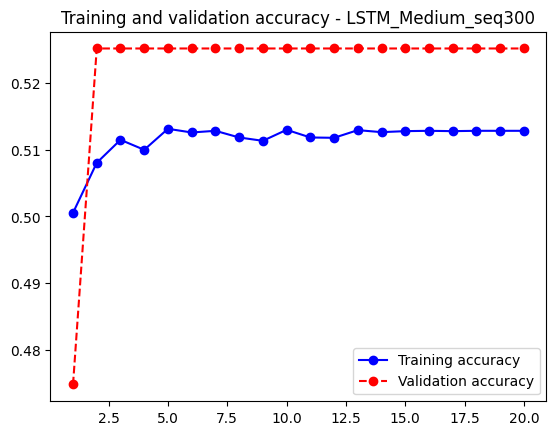

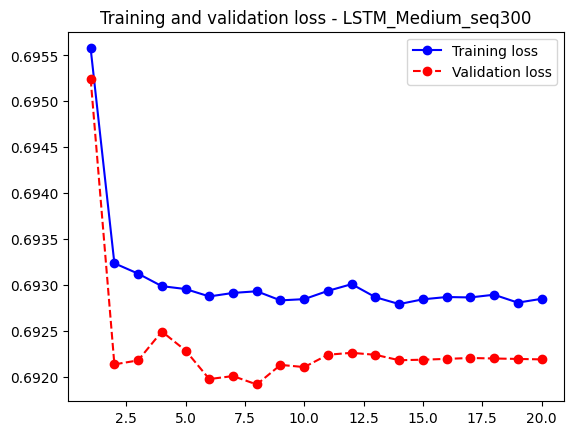


Testing LSTM_Medium with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_62 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5150 - loss: 0.6930

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5151 - loss: 0.6930 - val_accuracy: 0.5988 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6085 - loss: 0.6582

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6086 - loss: 0.6582 - val_accuracy: 0.6502 - val_loss: 0.6221 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6487 - loss: 0.6151 - val_accuracy: 0.4746 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5178 - loss: 0.6908 - val_accuracy: 0.5252 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5115 - loss: 0.6928 - val_accuracy: 0.5252 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5113 - loss: 0.6934 - val_accuracy: 0.5252 - val_loss: 0.6911 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.4983 - loss: 0.6937 - val_accuracy: 0.5252 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5127 - loss

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6026 - loss: 0.6917 - val_accuracy: 0.6922 - val_loss: 0.5926 - learning_rate: 1.2500e-04
Epoch 13/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7135 - loss: 0.5813

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7135 - loss: 0.5813 - val_accuracy: 0.6986 - val_loss: 0.5806 - learning_rate: 1.2500e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7089 - loss: 0.5750

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7089 - loss: 0.5750 - val_accuracy: 0.7196 - val_loss: 0.5244 - learning_rate: 1.2500e-04
Epoch 15/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7540 - loss: 0.5236

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7540 - loss: 0.5236 - val_accuracy: 0.7598 - val_loss: 0.4990 - learning_rate: 1.2500e-04
Epoch 16/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7685 - loss: 0.4844

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7685 - loss: 0.4843 - val_accuracy: 0.7818 - val_loss: 0.4728 - learning_rate: 1.2500e-04
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7880 - loss: 0.4532

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7880 - loss: 0.4532 - val_accuracy: 0.7990 - val_loss: 0.4471 - learning_rate: 1.2500e-04
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8145 - loss: 0.4259 - val_accuracy: 0.7948 - val_loss: 0.4492 - learning_rate: 1.2500e-04
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8080 - loss: 0.4322

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8080 - loss: 0.4322 - val_accuracy: 0.8196 - val_loss: 0.4097 - learning_rate: 1.2500e-04
Epoch 20/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8305 - loss: 0.3979

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8305 - loss: 0.3979 - val_accuracy: 0.8150 - val_loss: 0.3979 - learning_rate: 1.2500e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8097 - loss: 0.4035


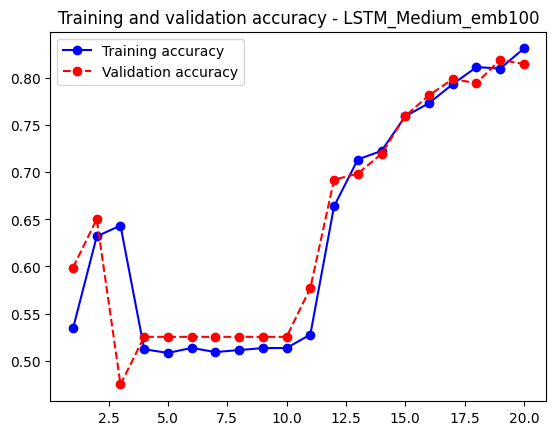

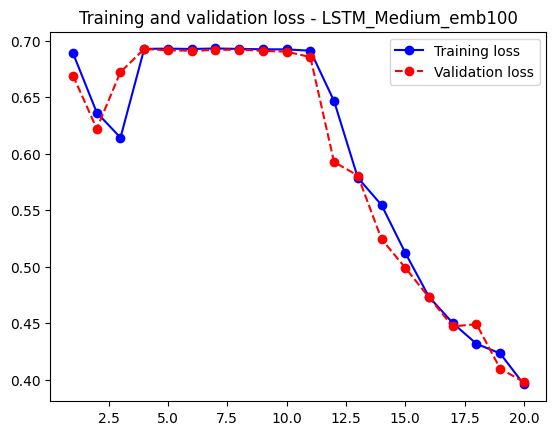


Testing LSTM_Medium with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_63 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5547 - loss: 0.6781

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5548 - loss: 0.6781 - val_accuracy: 0.6962 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6758 - loss: 0.6264 - val_accuracy: 0.7030 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7103 - loss: 0.5976

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7103 - loss: 0.5975 - val_accuracy: 0.7414 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7366 - loss: 0.5499

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7367 - loss: 0.5499 - val_accuracy: 0.7962 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 5/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8418 - loss: 0.3806

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8418 - loss: 0.3806 - val_accuracy: 0.8378 - val_loss: 0.3636 - learning_rate: 0.0010
Epoch 6/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8781 - loss: 0.3144

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8781 - loss: 0.3143 - val_accuracy: 0.8494 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 7/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8884 - loss: 0.2829

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8884 - loss: 0.2829 - val_accuracy: 0.8586 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9003 - loss: 0.2558 - val_accuracy: 0.8546 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9132 - loss: 0.2314 - val_accuracy: 0.8504 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9199 - loss: 0.2151 - val_accuracy: 0.8630 - val_loss: 0.3271 - learning_rate: 0.0010
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9351 - loss: 0.1858 - val_accuracy: 0.8566 - val_loss: 0.3497 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9396 - loss: 0.1708 - val_accuracy: 0.8586 - val_loss: 0.3813 - learning_rate: 5.0000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9517 - 

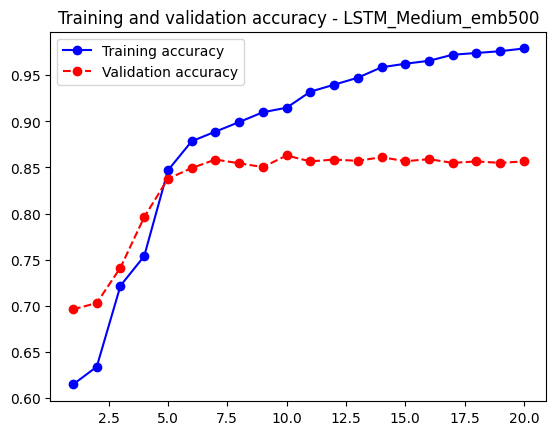

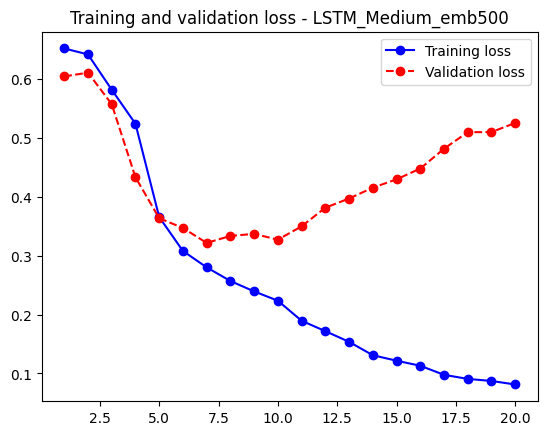


Testing LSTM_Medium with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_64 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5488 - loss: 0.6849

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5490 - loss: 0.6849 - val_accuracy: 0.6902 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6636 - loss: 0.6046

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6638 - loss: 0.6044 - val_accuracy: 0.8126 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8496 - loss: 0.3688

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8496 - loss: 0.3688 - val_accuracy: 0.8330 - val_loss: 0.3671 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8741 - loss: 0.3065

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8741 - loss: 0.3065 - val_accuracy: 0.8494 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8947 - loss: 0.2673 - val_accuracy: 0.8508 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9060 - loss: 0.2372 - val_accuracy: 0.8572 - val_loss: 0.3587 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9203 - loss: 0.2080 - val_accuracy: 0.8542 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9310 - loss: 0.1852 - val_accuracy: 0.8548 - val_loss: 0.3825 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9482 - loss: 0.1494 - val_accuracy: 0.8488 - val_loss: 0.4506 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9568 - los

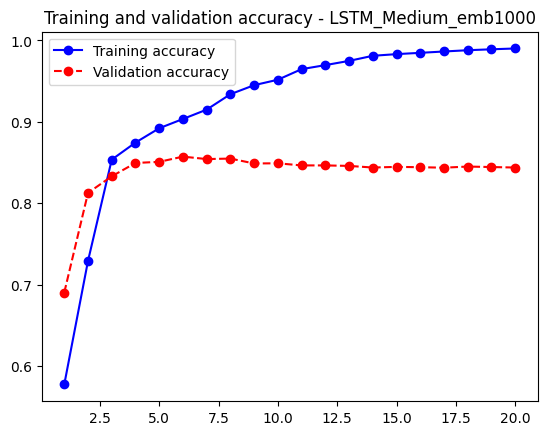

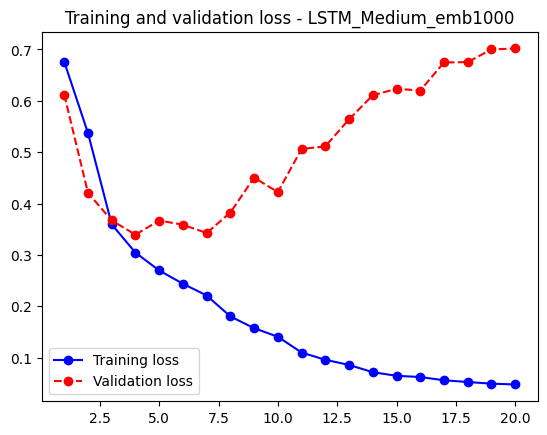


Testing LSTM_Medium with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_65 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5741 - loss: 0.6640

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5742 - loss: 0.6639 - val_accuracy: 0.8224 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8456 - loss: 0.3610

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8456 - loss: 0.3610 - val_accuracy: 0.8460 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8824 - loss: 0.2907 - val_accuracy: 0.8504 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8937 - loss: 0.2633

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8936 - loss: 0.2633 - val_accuracy: 0.8514 - val_loss: 0.3361 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9064 - loss: 0.2392 - val_accuracy: 0.8516 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9154 - loss: 0.2172

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9153 - loss: 0.2172 - val_accuracy: 0.8598 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9247 - loss: 0.1989 - val_accuracy: 0.8528 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9370 - loss: 0.1727 - val_accuracy: 0.8546 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9330 - loss: 0.1727 - val_accuracy: 0.8548 - val_loss: 0.3853 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9523 - loss: 0.1371 - val_accuracy: 0.8532 - val_loss: 0.4288 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9673 - loss: 0.1041 - val_accuracy: 0.8508 - val_loss: 0.4592 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9714 - l

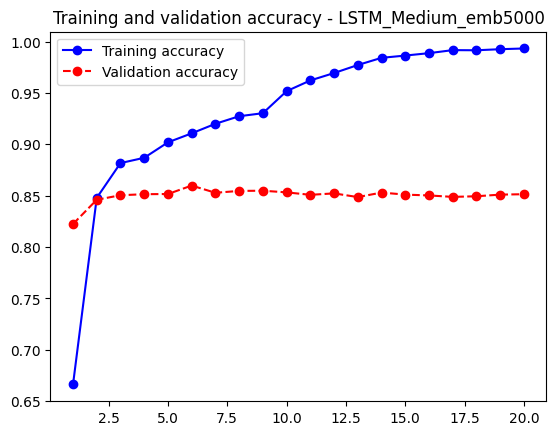

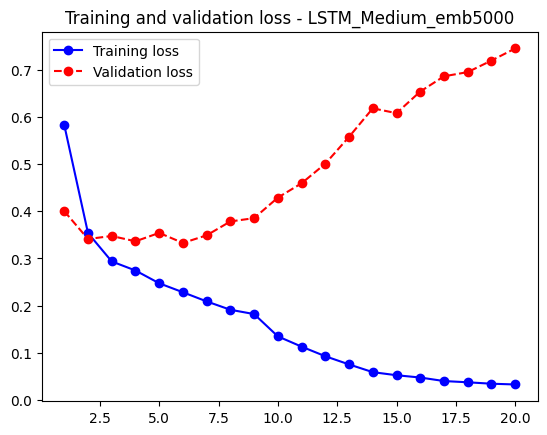


Testing LSTM_Medium with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_66 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5304 - loss: 0.6946

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5305 - loss: 0.6946 - val_accuracy: 0.5642 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5990 - loss: 0.6581

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5991 - loss: 0.6580 - val_accuracy: 0.8070 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 3/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8389 - loss: 0.3944

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8390 - loss: 0.3942 - val_accuracy: 0.8478 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8824 - loss: 0.2912

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8824 - loss: 0.2912 - val_accuracy: 0.8518 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9006 - loss: 0.2535

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9006 - loss: 0.2535 - val_accuracy: 0.8514 - val_loss: 0.3461 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9130 - loss: 0.2220 - val_accuracy: 0.8568 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9252 - loss: 0.1977 - val_accuracy: 0.8514 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9312 - loss: 0.1804 - val_accuracy: 0.8560 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9523 - loss: 0.1361 - val_accuracy: 0.8536 - val_loss: 0.4338 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9605 - loss: 0.1132 - val_accuracy: 0.8482 - val_loss: 0.4663 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9661 - lo

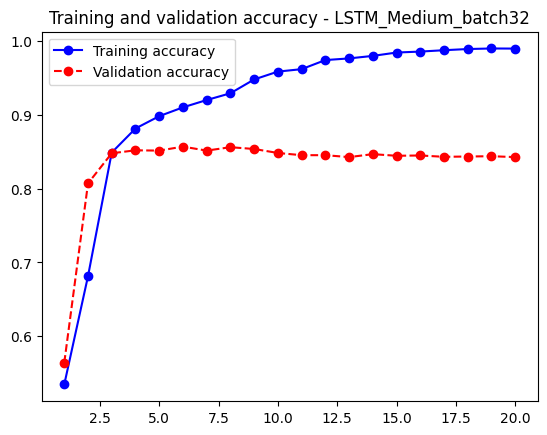

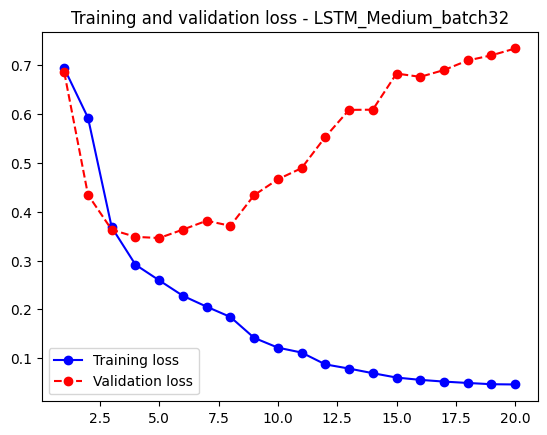


Testing LSTM_Medium with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_67 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5413 - loss: 0.6917

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5413 - loss: 0.6917 - val_accuracy: 0.5342 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 2/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5260 - loss: 0.6909

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5262 - loss: 0.6908 - val_accuracy: 0.6020 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 3/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7360 - loss: 0.5494

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7369 - loss: 0.5482 - val_accuracy: 0.8422 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 4/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8798 - loss: 0.3098

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8798 - loss: 0.3097 - val_accuracy: 0.8590 - val_loss: 0.3293 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8959 - loss: 0.2685 - val_accuracy: 0.8590 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9060 - loss: 0.2410 - val_accuracy: 0.8596 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9141 - loss: 0.2262 - val_accuracy: 0.8612 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9303 - loss: 0.1915 - val_accuracy: 0.8558 - val_loss: 0.3894 - learning_rate: 5.0000e-04
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9411 - loss: 0.1640 - val_accuracy: 0.8582 - val_loss: 0.4209 - learning_rate: 5.0000e-04
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9454 - loss: 0.15

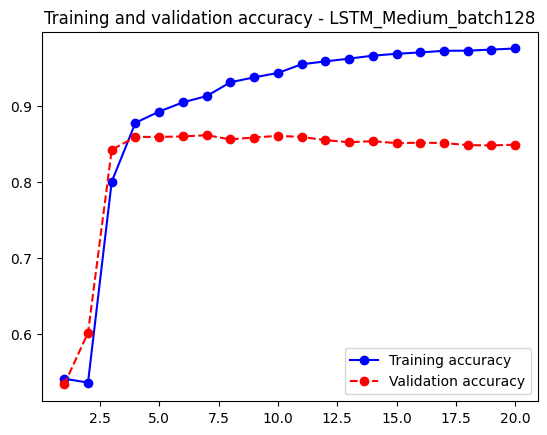

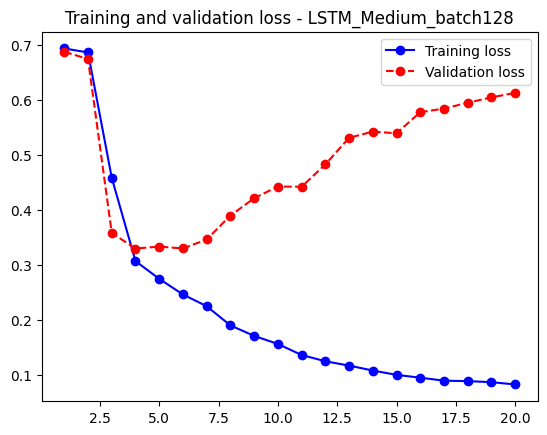


Testing LSTM_Medium with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_68 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5270 - loss: 0.6885

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5276 - loss: 0.6883 - val_accuracy: 0.6748 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 2/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7193 - loss: 0.6125

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7190 - loss: 0.6126 - val_accuracy: 0.6638 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 3/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6801 - loss: 0.6225

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6807 - loss: 0.6221 - val_accuracy: 0.7060 - val_loss: 0.5996 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7100 - loss: 0.5899 - val_accuracy: 0.6186 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6697 - loss: 0.6251 - val_accuracy: 0.7072 - val_loss: 0.6206 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6568 - loss: 0.6385 - val_accuracy: 0.5692 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5402 - loss: 0.6779 - val_accuracy: 0.5726 - val_loss: 0.6719 - learning_rate: 5.0000e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5574 - loss: 0.6743 - val_accuracy: 0.5804 - val_loss: 0.6662 - learning_rate: 5.0000e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5929 - loss: 0.6612 - val_accura

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6785 - loss: 0.6071 - val_accuracy: 0.7038 - val_loss: 0.5802 - learning_rate: 2.5000e-04
Epoch 12/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7029 - loss: 0.5872

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7032 - loss: 0.5868 - val_accuracy: 0.7230 - val_loss: 0.5645 - learning_rate: 2.5000e-04
Epoch 13/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7248 - loss: 0.5587

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7250 - loss: 0.5584 - val_accuracy: 0.7418 - val_loss: 0.5370 - learning_rate: 2.5000e-04
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7447 - loss: 0.5252

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7448 - loss: 0.5251 - val_accuracy: 0.7698 - val_loss: 0.5081 - learning_rate: 2.5000e-04
Epoch 15/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7826 - loss: 0.4849

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7825 - loss: 0.4850 - val_accuracy: 0.7658 - val_loss: 0.4997 - learning_rate: 2.5000e-04
Epoch 16/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7797 - loss: 0.4820

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7799 - loss: 0.4818 - val_accuracy: 0.7752 - val_loss: 0.4889 - learning_rate: 2.5000e-04
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7918 - loss: 0.4766 - val_accuracy: 0.7606 - val_loss: 0.4898 - learning_rate: 2.5000e-04
Epoch 18/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7874 - loss: 0.4628 - val_accuracy: 0.7578 - val_loss: 0.5039 - learning_rate: 2.5000e-04
Epoch 19/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7940 - loss: 0.4444

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7941 - loss: 0.4441 - val_accuracy: 0.7686 - val_loss: 0.4637 - learning_rate: 2.5000e-04
Epoch 20/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8108 - loss: 0.4175 - val_accuracy: 0.7480 - val_loss: 0.5155 - learning_rate: 2.5000e-04
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7478 - loss: 0.5103


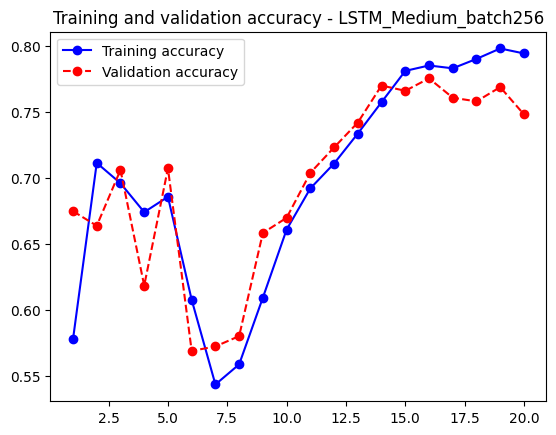

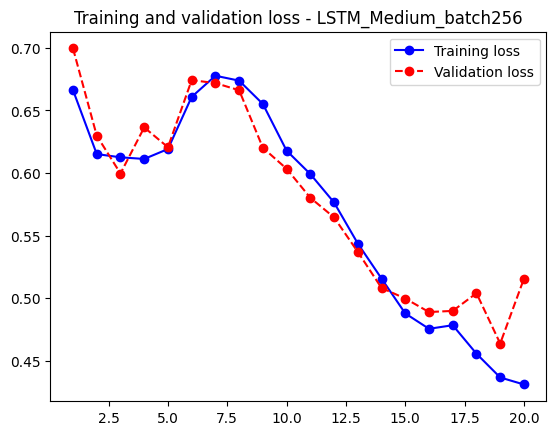


Testing GRU_Small with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_69 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5968 - loss: 0.6447

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5976 - loss: 0.6439 - val_accuracy: 0.8344 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 2/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8623 - loss: 0.3253

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8623 - loss: 0.3254 - val_accuracy: 0.8482 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8820 - loss: 0.2806 - val_accuracy: 0.8484 - val_loss: 0.3525 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8989 - loss: 0.2524 - val_accuracy: 0.8432 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9147 - loss: 0.2127 - val_accuracy: 0.8440 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9296 - loss: 0.1801 - val_accuracy: 0.8474 - val_loss: 0.4474 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9514 - loss: 0.1356 - val_accuracy: 0.8362 - val_loss: 0.4825 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9616 - loss: 0.

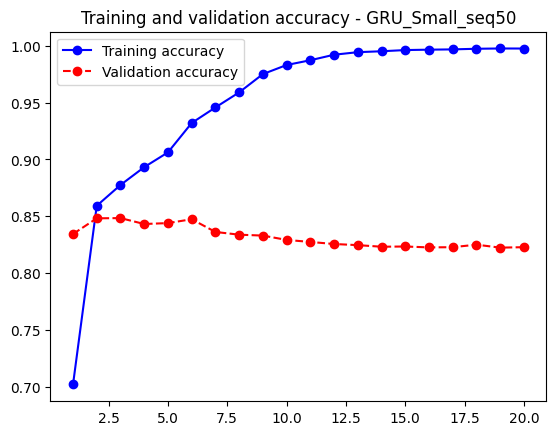

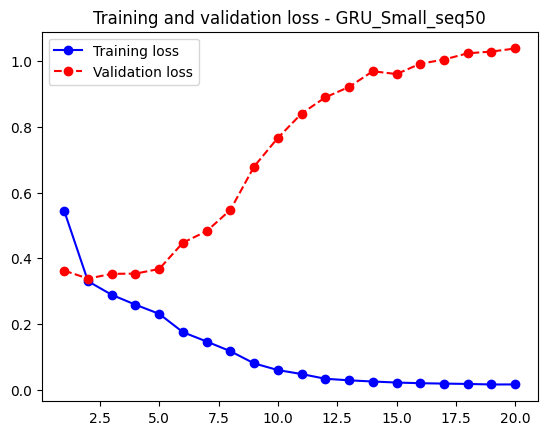


Testing GRU_Small with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_70 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5195 - loss: 0.6963

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5195 - loss: 0.6963 - val_accuracy: 0.5516 - val_loss: 0.6843 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6643 - loss: 0.5969

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6646 - loss: 0.5965 - val_accuracy: 0.8404 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 3/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8821 - loss: 0.2885

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8821 - loss: 0.2885 - val_accuracy: 0.8598 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9064 - loss: 0.2392

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9063 - loss: 0.2393 - val_accuracy: 0.8664 - val_loss: 0.3024 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9227 - loss: 0.2029 - val_accuracy: 0.8636 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9375 - loss: 0.1735 - val_accuracy: 0.8630 - val_loss: 0.3534 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9536 - loss: 0.1301 - val_accuracy: 0.8580 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9706 - loss: 0.0906 - val_accuracy: 0.8576 - val_loss: 0.4823 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9844 - loss: 0.0586 - val_accuracy: 0.8544 - val_loss: 0.5691 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9874 - los

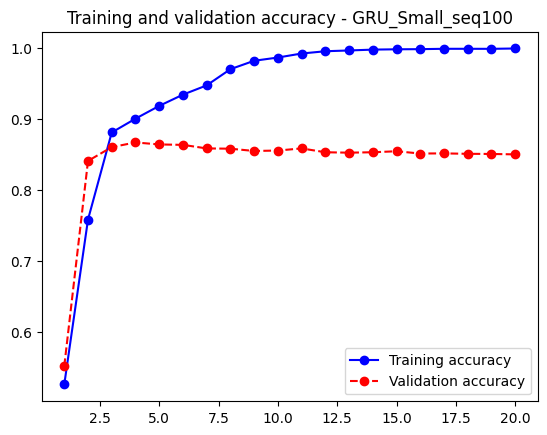

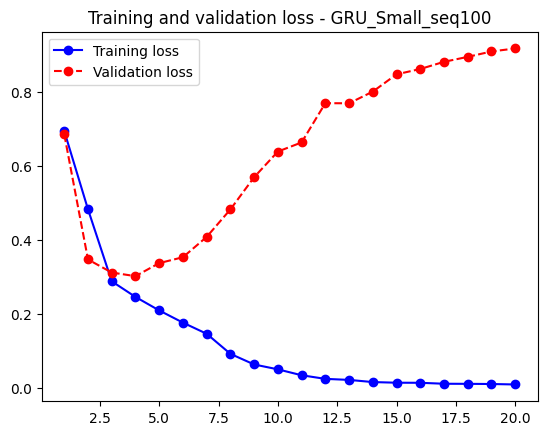


Testing GRU_Small with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_71 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4976 - loss: 0.6984

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4976 - loss: 0.6984 - val_accuracy: 0.4788 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5148 - loss: 0.6937

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.5148 - loss: 0.6937 - val_accuracy: 0.5284 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5241 - loss: 0.6883 - val_accuracy: 0.5272 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5393 - loss: 0.6733

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5393 - loss: 0.6733 - val_accuracy: 0.6472 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7636 - loss: 0.4836

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7637 - loss: 0.4834 - val_accuracy: 0.8608 - val_loss: 0.3167 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8992 - loss: 0.2540

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8992 - loss: 0.2540 - val_accuracy: 0.8658 - val_loss: 0.3025 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9219 - loss: 0.2032 - val_accuracy: 0.8652 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9469 - loss: 0.1526 - val_accuracy: 0.8650 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9570 - loss: 0.1264 - val_accuracy: 0.8620 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9754 - loss: 0.0816 - val_accuracy: 0.8624 - val_loss: 0.4894 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9878 - loss: 0.0515 - val_accuracy: 0.8632 - val_loss: 0.4893 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9902 - l

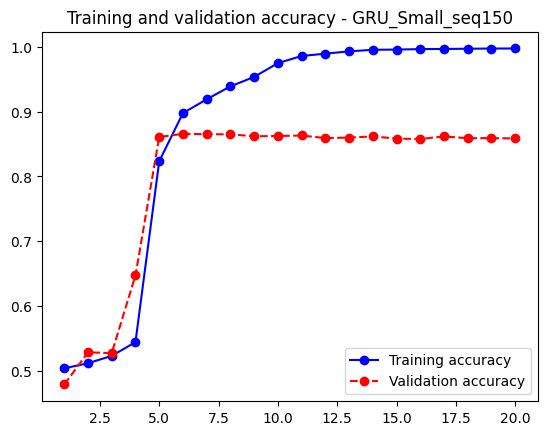

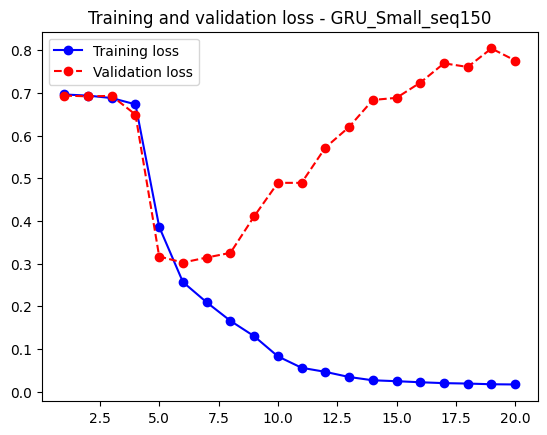


Testing GRU_Small with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_72 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4991 - loss: 0.6984

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.4991 - loss: 0.6984 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5023 - loss: 0.6952 - val_accuracy: 0.5252 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.5000 - loss: 0.6946 - val_accuracy: 0.5252 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5020 - loss: 0.6944 - val_accuracy: 0.5252 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.4985 - loss: 0.6937 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5117 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6929 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5076 - loss

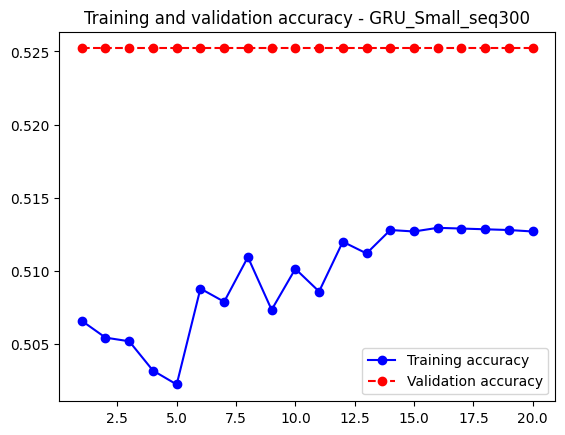

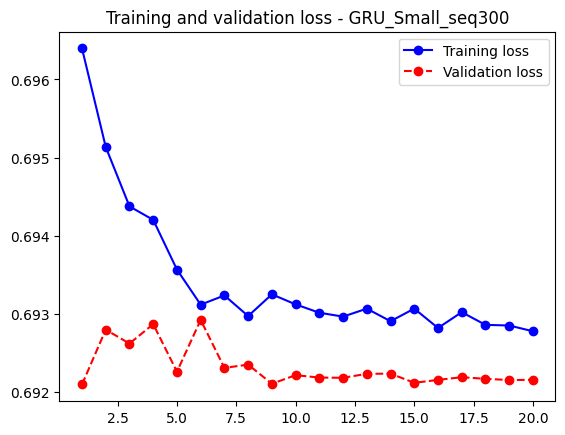


Testing GRU_Small with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_73 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5096 - loss: 0.6935

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5097 - loss: 0.6935 - val_accuracy: 0.5504 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5731 - loss: 0.6753

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5733 - loss: 0.6752 - val_accuracy: 0.6618 - val_loss: 0.6267 - learning_rate: 0.0010
Epoch 3/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5987 - loss: 0.6489

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5991 - loss: 0.6486 - val_accuracy: 0.7908 - val_loss: 0.4421 - learning_rate: 0.0010
Epoch 4/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8453 - loss: 0.3703

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8454 - loss: 0.3701 - val_accuracy: 0.8544 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 5/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8840 - loss: 0.2828

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8840 - loss: 0.2828 - val_accuracy: 0.8670 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9028 - loss: 0.2533 - val_accuracy: 0.8636 - val_loss: 0.3210 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9086 - loss: 0.2305 - val_accuracy: 0.8584 - val_loss: 0.3396 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9145 - loss: 0.2164 - val_accuracy: 0.8632 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9274 - loss: 0.1937 - val_accuracy: 0.8608 - val_loss: 0.3361 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9312 - loss: 0.1807 - val_accuracy: 0.8608 - val_loss: 0.3678 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9385 - lo

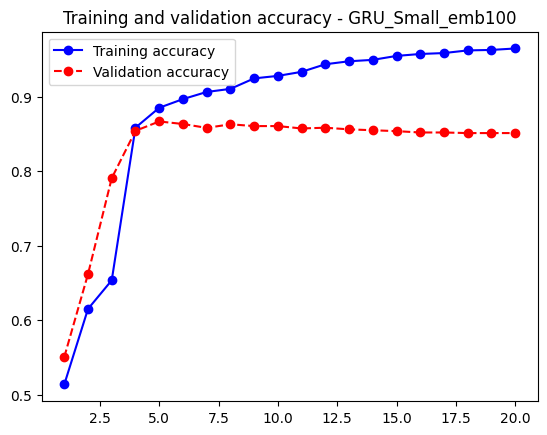

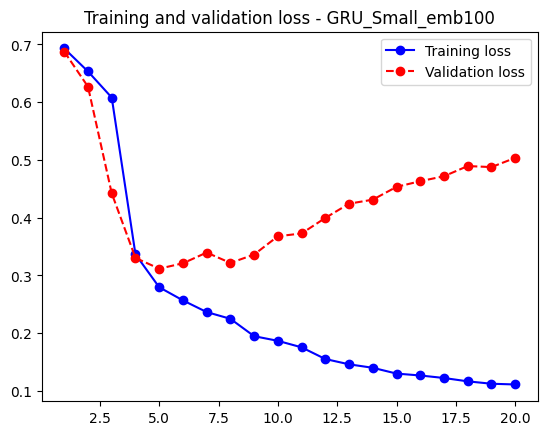


Testing GRU_Small with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_74 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5158 - loss: 0.6943

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5158 - loss: 0.6943 - val_accuracy: 0.5486 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6360 - loss: 0.6151

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6365 - loss: 0.6146 - val_accuracy: 0.8426 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8797 - loss: 0.2883

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8797 - loss: 0.2883 - val_accuracy: 0.8580 - val_loss: 0.3145 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9039 - loss: 0.2422

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9039 - loss: 0.2423 - val_accuracy: 0.8646 - val_loss: 0.3045 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9176 - loss: 0.2107 - val_accuracy: 0.8580 - val_loss: 0.3222 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9364 - loss: 0.1731 - val_accuracy: 0.8636 - val_loss: 0.3300 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9450 - loss: 0.1489 - val_accuracy: 0.8582 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9621 - loss: 0.1135 - val_accuracy: 0.8558 - val_loss: 0.4542 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9756 - loss: 0.0807 - val_accuracy: 0.8498 - val_loss: 0.5372 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9793 - los

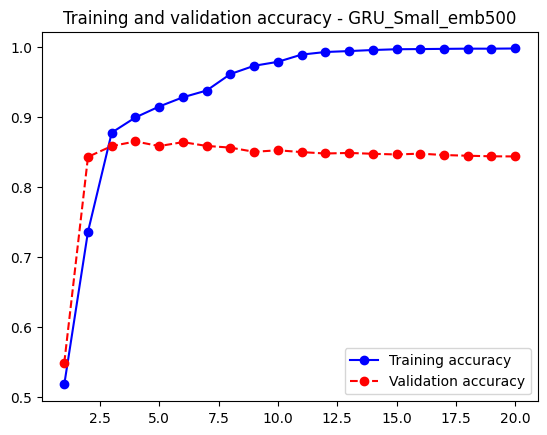

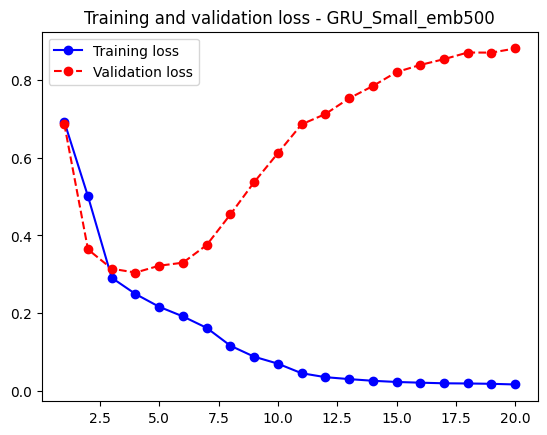


Testing GRU_Small with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_75 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5210 - loss: 0.6954

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5210 - loss: 0.6954 - val_accuracy: 0.5434 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5701 - loss: 0.6752

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5703 - loss: 0.6751 - val_accuracy: 0.8238 - val_loss: 0.3918 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8582 - loss: 0.3428

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8582 - loss: 0.3428 - val_accuracy: 0.8596 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8933 - loss: 0.2562 - val_accuracy: 0.8634 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9127 - loss: 0.2164 - val_accuracy: 0.8594 - val_loss: 0.3299 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9351 - loss: 0.1714 - val_accuracy: 0.8588 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9540 - loss: 0.1292 - val_accuracy: 0.8586 - val_loss: 0.4122 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9711 - loss: 0.0896 - val_accuracy: 0.8570 - val_loss: 0.4858 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9767 - loss

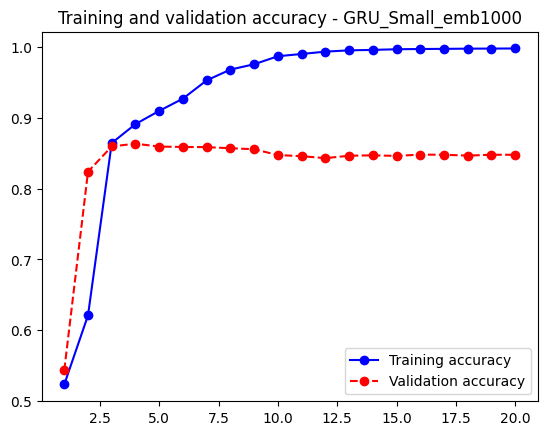

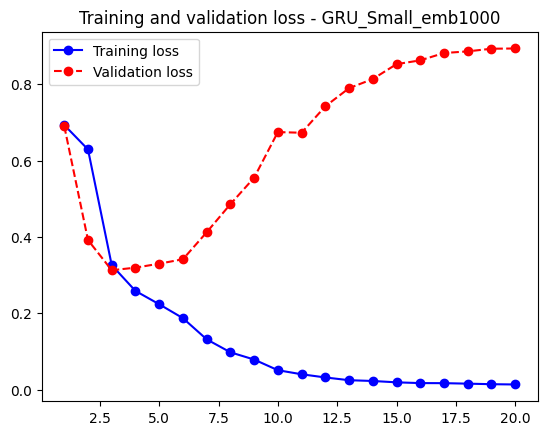


Testing GRU_Small with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_76 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_22 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5089 - loss: 0.7053

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5090 - loss: 0.7053 - val_accuracy: 0.4964 - val_loss: 0.6892 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6945 - loss: 0.5573

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6950 - loss: 0.5567 - val_accuracy: 0.8484 - val_loss: 0.3286 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8859 - loss: 0.2852

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8859 - loss: 0.2852 - val_accuracy: 0.8600 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9053 - loss: 0.2340 - val_accuracy: 0.8620 - val_loss: 0.3219 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9242 - loss: 0.1971 - val_accuracy: 0.8590 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9357 - loss: 0.1751 - val_accuracy: 0.8628 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9460 - loss: 0.1450 - val_accuracy: 0.8606 - val_loss: 0.4037 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9696 - loss: 0.0959 - val_accuracy: 0.8606 - val_loss: 0.4575 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9772 - loss

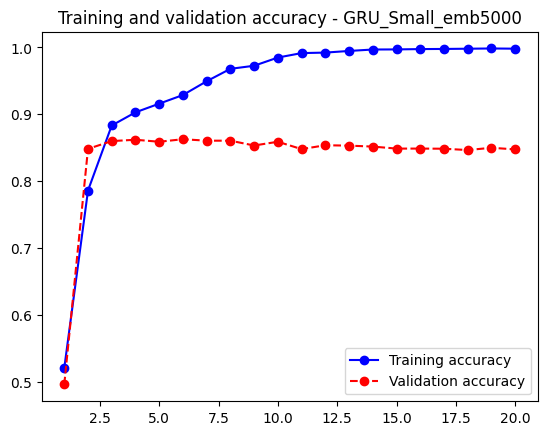

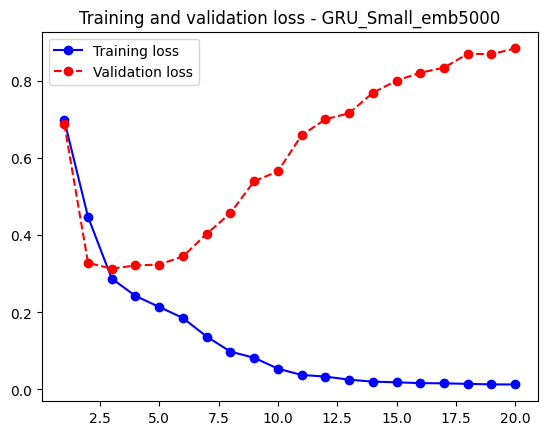


Testing GRU_Small with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_77 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5091 - loss: 0.6964

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5091 - loss: 0.6964 - val_accuracy: 0.5550 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 2/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5931 - loss: 0.6597

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5934 - loss: 0.6594 - val_accuracy: 0.8318 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8673 - loss: 0.3250

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8673 - loss: 0.3249 - val_accuracy: 0.8502 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 4/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8969 - loss: 0.2563

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8969 - loss: 0.2564 - val_accuracy: 0.8604 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 5/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9177 - loss: 0.2139

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9177 - loss: 0.2139 - val_accuracy: 0.8564 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9357 - loss: 0.1749 - val_accuracy: 0.8602 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9431 - loss: 0.1559 - val_accuracy: 0.8610 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9606 - loss: 0.1178 - val_accuracy: 0.8502 - val_loss: 0.4255 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9775 - loss: 0.0779 - val_accuracy: 0.8466 - val_loss: 0.5427 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9878 - loss: 0.0482 - val_accuracy: 0.8518 - val_loss: 0.6190 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9905 - lo

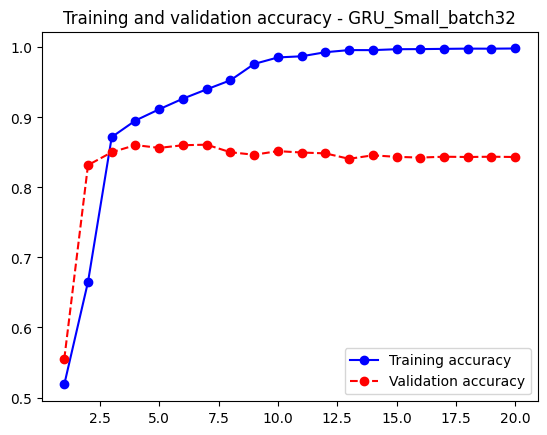

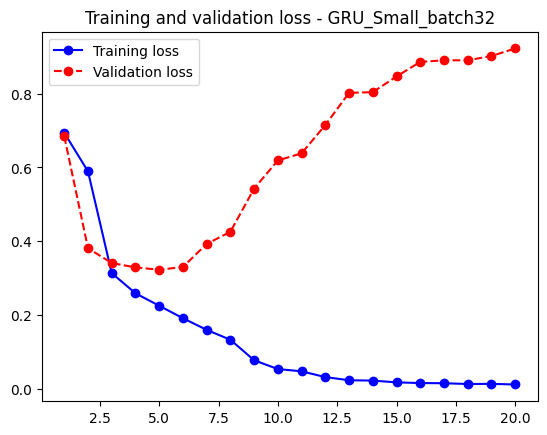


Testing GRU_Small with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_78 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_27 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5147 - loss: 0.6946

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5147 - loss: 0.6946 - val_accuracy: 0.5418 - val_loss: 0.6892 - learning_rate: 0.0010
Epoch 2/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5415 - loss: 0.6856

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5418 - loss: 0.6855 - val_accuracy: 0.5856 - val_loss: 0.6864 - learning_rate: 0.0010
Epoch 3/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6159 - loss: 0.6506

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6166 - loss: 0.6499 - val_accuracy: 0.7664 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 4/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8066 - loss: 0.4397

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8068 - loss: 0.4393 - val_accuracy: 0.8280 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 5/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8583 - loss: 0.3360

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8584 - loss: 0.3359 - val_accuracy: 0.8434 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 6/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8859 - loss: 0.2855

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8859 - loss: 0.2855 - val_accuracy: 0.8530 - val_loss: 0.3518 - learning_rate: 0.0010
Epoch 7/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9002 - loss: 0.2474

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9001 - loss: 0.2475 - val_accuracy: 0.8590 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9044 - loss: 0.2341 - val_accuracy: 0.8592 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9149 - loss: 0.2116 - val_accuracy: 0.8496 - val_loss: 0.3891 - learning_rate: 0.0010
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9293 - loss: 0.1831 - val_accuracy: 0.8582 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9397 - loss: 0.1629 - val_accuracy: 0.8542 - val_loss: 0.4180 - learning_rate: 5.0000e-04
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9521 - loss: 0.1375 - val_accuracy: 0.8512 - val_loss: 0.4592 - learning_rate: 5.0000e-04
Epoch 13/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9571 - loss: 0

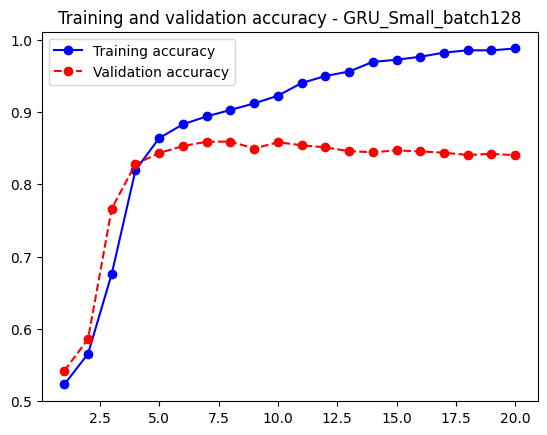

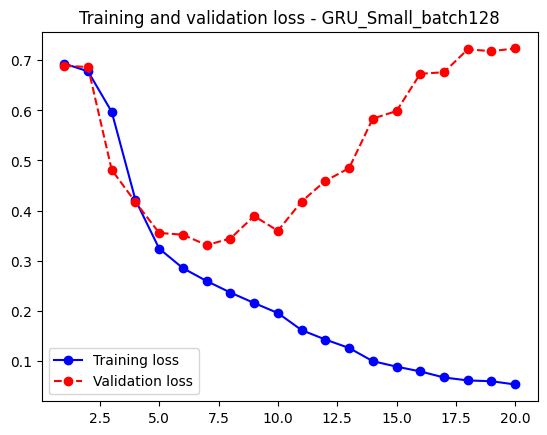


Testing GRU_Small with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_79 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5168 - loss: 0.6949

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5168 - loss: 0.6949 - val_accuracy: 0.5356 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5383 - loss: 0.6900

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5384 - loss: 0.6900 - val_accuracy: 0.5498 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 3/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5623 - loss: 0.6760

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5625 - loss: 0.6759 - val_accuracy: 0.6124 - val_loss: 0.6578 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7564 - loss: 0.5414

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7565 - loss: 0.5412 - val_accuracy: 0.7888 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8353 - loss: 0.4149

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8354 - loss: 0.4146 - val_accuracy: 0.8414 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 6/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8771 - loss: 0.3023

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8771 - loss: 0.3023 - val_accuracy: 0.8504 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 7/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8938 - loss: 0.2674

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8938 - loss: 0.2675 - val_accuracy: 0.8552 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9059 - loss: 0.2389 - val_accuracy: 0.8512 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9148 - loss: 0.2244 - val_accuracy: 0.8562 - val_loss: 0.3537 - learning_rate: 0.0010
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9244 - loss: 0.2008 - val_accuracy: 0.8600 - val_loss: 0.3558 - learning_rate: 0.0010
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9381 - loss: 0.1710 - val_accuracy: 0.8586 - val_loss: 0.3784 - learning_rate: 5.0000e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9491 - loss: 0.1484 - val_accuracy: 0.8586 - val_loss: 0.4171 - learning_rate: 5.0000e-04
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9550 - loss: 0.1344 - val_ac

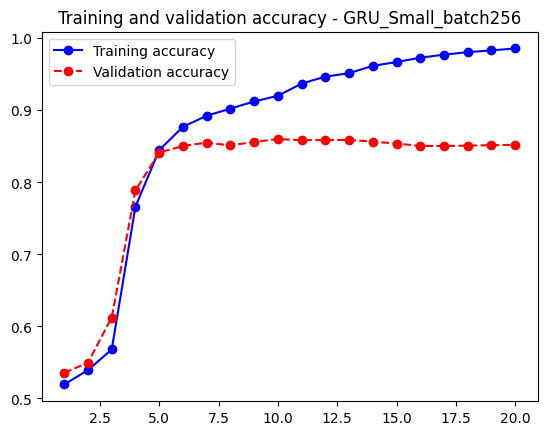

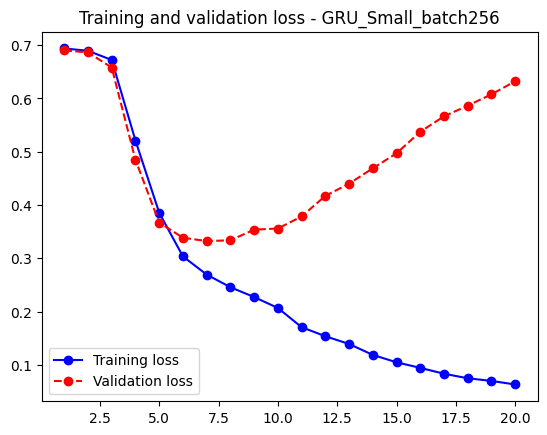


Testing GRU_Medium with sequence length = 50 (embedding dim = 1000, batch size = 32)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_80 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5901 - loss: 0.6522

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5903 - loss: 0.6521 - val_accuracy: 0.8084 - val_loss: 0.4216 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8351 - loss: 0.3834

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8351 - loss: 0.3834 - val_accuracy: 0.8254 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 3/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8622 - loss: 0.3243

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8622 - loss: 0.3243 - val_accuracy: 0.8434 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8789 - loss: 0.2863 - val_accuracy: 0.8358 - val_loss: 0.3864 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8928 - loss: 0.2597

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8928 - loss: 0.2597 - val_accuracy: 0.8444 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9036 - loss: 0.2347 - val_accuracy: 0.8508 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9159 - loss: 0.2131 - val_accuracy: 0.8456 - val_loss: 0.3992 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9293 - loss: 0.1873 - val_accuracy: 0.8408 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9465 - loss: 0.1481 - val_accuracy: 0.8390 - val_loss: 0.5023 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9569 - loss: 0.1225 - val_accuracy: 0.8344 - val_loss: 0.5457 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9671 - lo

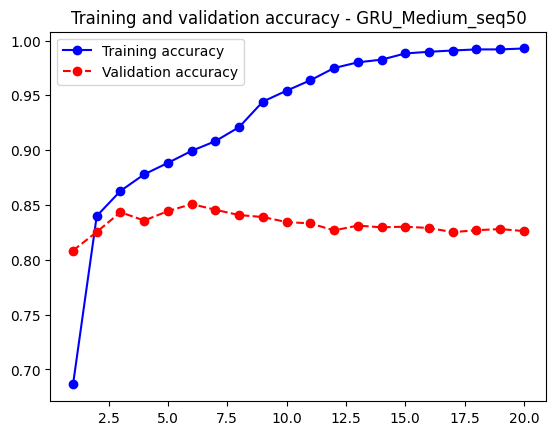

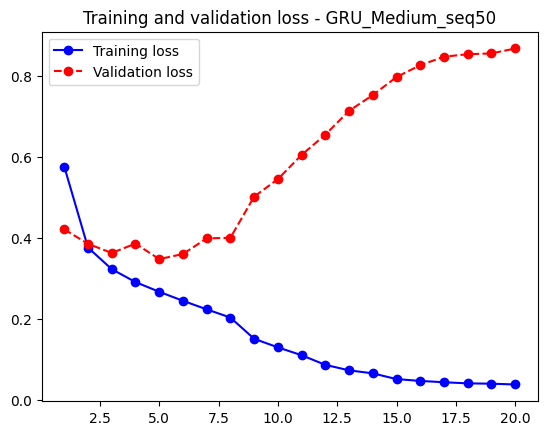


Testing GRU_Medium with sequence length = 100 (embedding dim = 1000, batch size = 32)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_81 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_34 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_35 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_36 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5046 - loss: 0.6961

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5047 - loss: 0.6961 - val_accuracy: 0.5574 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6902 - loss: 0.5756

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6905 - loss: 0.5752 - val_accuracy: 0.8454 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8789 - loss: 0.2935

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8789 - loss: 0.2935 - val_accuracy: 0.8414 - val_loss: 0.3349 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8992 - loss: 0.2545 - val_accuracy: 0.8574 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9171 - loss: 0.2099 - val_accuracy: 0.8514 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9313 - loss: 0.1841 - val_accuracy: 0.8628 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9566 - loss: 0.1316 - val_accuracy: 0.8600 - val_loss: 0.4448 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9695 - loss: 0.0965 - val_accuracy: 0.8590 - val_loss: 0.5227 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9784 - loss

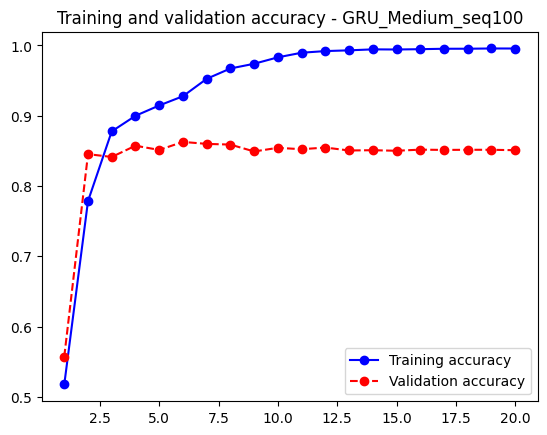

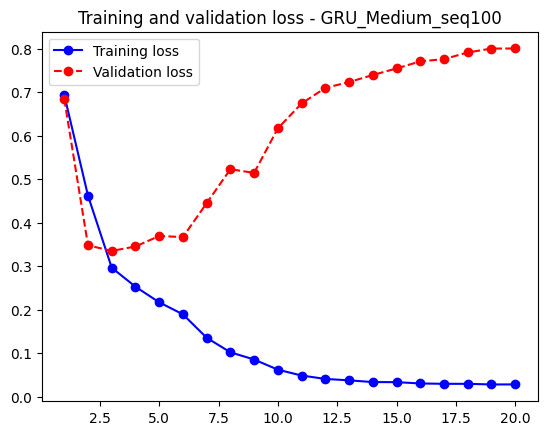


Testing GRU_Medium with sequence length = 150 (embedding dim = 1000, batch size = 32)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_82 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_38 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_39 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_40 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5015 - loss: 0.6971

625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.5015 - loss: 0.6971 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5079 - loss: 0.6948 - val_accuracy: 0.5218 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5079 - loss: 0.6942

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5079 - loss: 0.6942 - val_accuracy: 0.5246 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5069 - loss: 0.6936 - val_accuracy: 0.4834 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5237 - loss: 0.6899 - val_accuracy: 0.5298 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.5346 - loss: 0.6771 - val_accuracy: 0.5294 - val_loss: 0.6985 - learning_rate: 0.0010
Epoch 7/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6299 - loss: 0.6040

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6303 - loss: 0.6037 - val_accuracy: 0.8288 - val_loss: 0.3947 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8834 - loss: 0.3010

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.8834 - loss: 0.3009 - val_accuracy: 0.8574 - val_loss: 0.3338 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9141 - loss: 0.2292 - val_accuracy: 0.8540 - val_loss: 0.3691 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9340 - loss: 0.1851 - val_accuracy: 0.8614 - val_loss: 0.3715 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9514 - loss: 0.1499 - val_accuracy: 0.8620 - val_loss: 0.3980 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9655 - loss: 0.1166 - val_accuracy: 0.8578 - val_loss: 0.4895 - learning_rate: 2.5000e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.9761 - loss: 0.0913 - val_accuracy: 0.8498 - val_loss: 0.5372 - learning_rate: 2.5000e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - ac

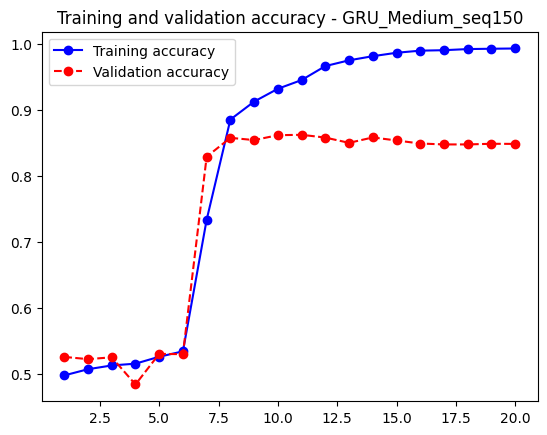

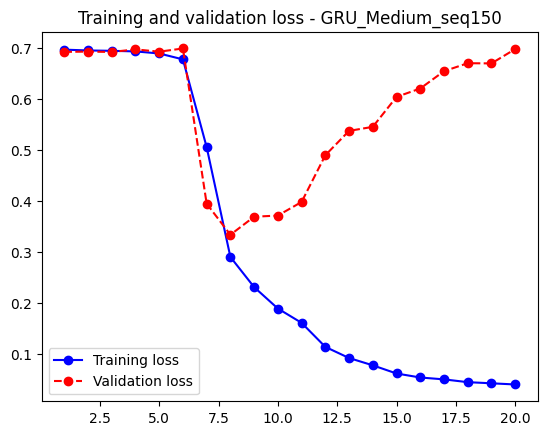


Testing GRU_Medium with sequence length = 300 (embedding dim = 1000, batch size = 32)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_83 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_42 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_43 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5043 - loss: 0.6964

625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.5043 - loss: 0.6964 - val_accuracy: 0.4748 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5017 - loss: 0.6964

625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.5017 - loss: 0.6964 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5045 - loss: 0.6943 - val_accuracy: 0.4748 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5094 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5118 - loss: 0.6935

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5118 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.5057 - loss: 0.6935 - val_accuracy: 0.5252 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5059 - loss: 0.6932 - val_accuracy: 0.5252 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.5195 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.5110 - loss: 0.6930 - val_accuracy: 0.5252 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.5094 - loss: 0.6931 - val_accuracy: 0.5252 - val_loss: 0.6921 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.5119 - lo

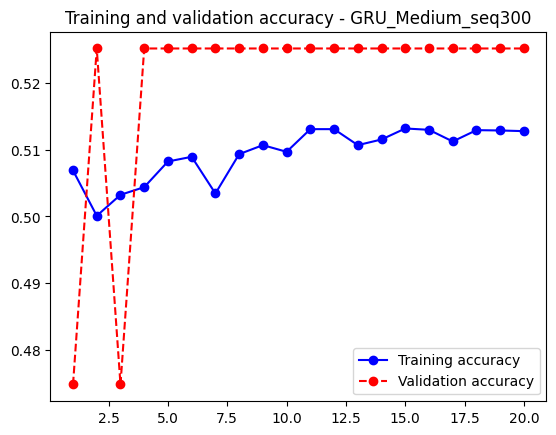

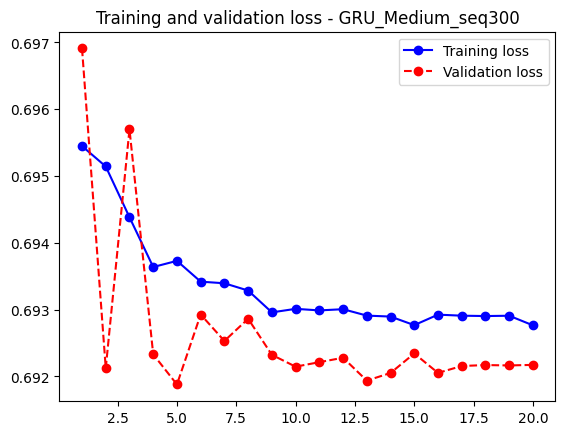


Testing GRU_Medium with embedding dim = 100 (sequence length = 100, batch size = 32)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_84 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_46 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_47 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5086 - loss: 0.6940

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5087 - loss: 0.6939 - val_accuracy: 0.5664 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5452 - loss: 0.6926

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5452 - loss: 0.6926 - val_accuracy: 0.7684 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6677 - loss: 0.5926

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6678 - loss: 0.5925 - val_accuracy: 0.8422 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8716 - loss: 0.3126

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8716 - loss: 0.3126 - val_accuracy: 0.8566 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 5/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8875 - loss: 0.2739

625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8875 - loss: 0.2739 - val_accuracy: 0.8594 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8995 - loss: 0.2489 - val_accuracy: 0.8588 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9065 - loss: 0.2338 - val_accuracy: 0.8568 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9149 - loss: 0.2182 - val_accuracy: 0.8576 - val_loss: 0.3274 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9274 - loss: 0.1889 - val_accuracy: 0.8570 - val_loss: 0.3702 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9336 - loss: 0.1786 - val_accuracy: 0.8532 - val_loss: 0.3894 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9413 - lo

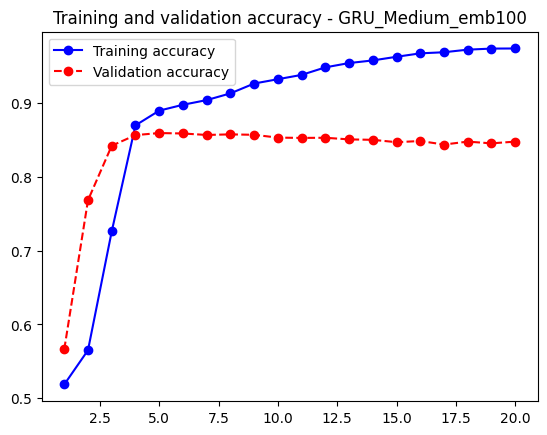

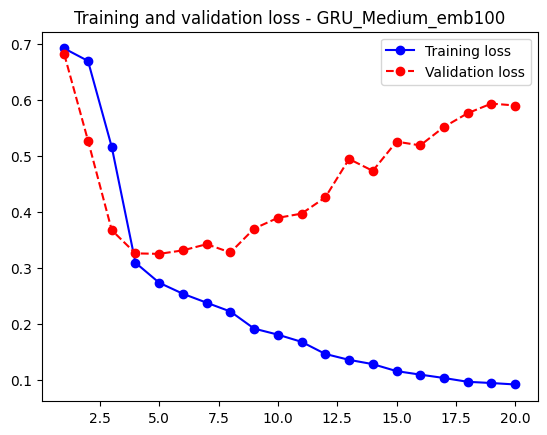


Testing GRU_Medium with embedding dim = 500 (sequence length = 100, batch size = 32)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_85 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_50 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_51 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5184 - loss: 0.6931

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5184 - loss: 0.6931 - val_accuracy: 0.5738 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6253 - loss: 0.6211

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6256 - loss: 0.6208 - val_accuracy: 0.8198 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8516 - loss: 0.3539

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8516 - loss: 0.3539 - val_accuracy: 0.8508 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8867 - loss: 0.2864

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8867 - loss: 0.2864 - val_accuracy: 0.8562 - val_loss: 0.3369 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8981 - loss: 0.2603

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8981 - loss: 0.2603 - val_accuracy: 0.8594 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 6/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9144 - loss: 0.2288

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9144 - loss: 0.2288 - val_accuracy: 0.8560 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9204 - loss: 0.2035 - val_accuracy: 0.8566 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9361 - loss: 0.1731 - val_accuracy: 0.8540 - val_loss: 0.3612 - learning_rate: 0.0010
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9480 - loss: 0.1490 - val_accuracy: 0.8506 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9600 - loss: 0.1215 - val_accuracy: 0.8534 - val_loss: 0.5473 - learning_rate: 5.0000e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9718 - loss: 0.0918 - val_accuracy: 0.8492 - val_loss: 0.5698 - learning_rate: 5.0000e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9778 - l

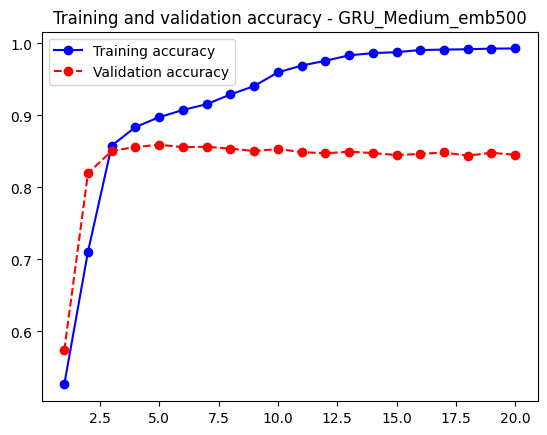

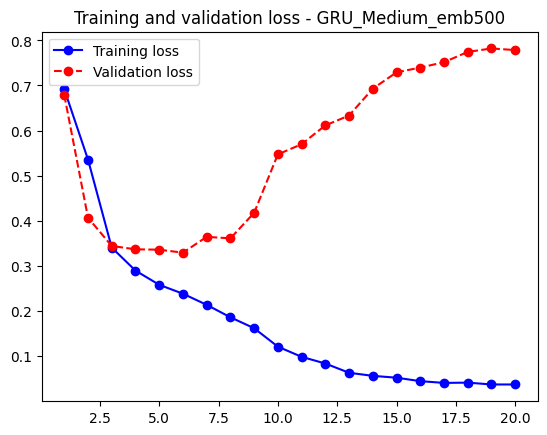


Testing GRU_Medium with embedding dim = 1000 (sequence length = 100, batch size = 32)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_86 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_54 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_55 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_57 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5138 - loss: 0.6950

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.5138 - loss: 0.6950 - val_accuracy: 0.5664 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6781 - loss: 0.5711

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6784 - loss: 0.5707 - val_accuracy: 0.8490 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.8775 - loss: 0.2929 - val_accuracy: 0.8468 - val_loss: 0.3455 - learning_rate: 0.0010
Epoch 4/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9029 - loss: 0.2489

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9029 - loss: 0.2489 - val_accuracy: 0.8644 - val_loss: 0.3191 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9195 - loss: 0.2117 - val_accuracy: 0.8580 - val_loss: 0.3325 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9362 - loss: 0.1748 - val_accuracy: 0.8642 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9478 - loss: 0.1473 - val_accuracy: 0.8556 - val_loss: 0.4170 - learning_rate: 0.0010
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9679 - loss: 0.1008 - val_accuracy: 0.8536 - val_loss: 0.4696 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9798 - loss: 0.0737 - val_accuracy: 0.8518 - val_loss: 0.5640 - learning_rate: 5.0000e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9854 - los

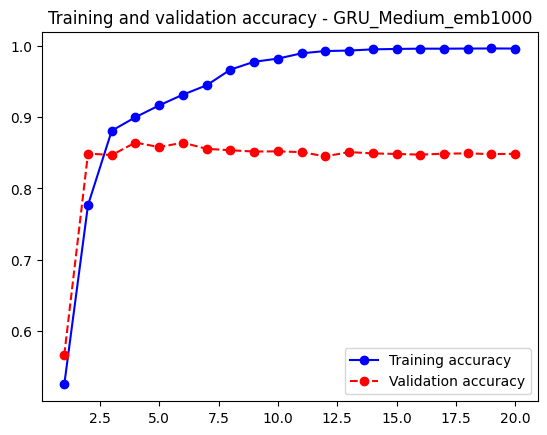

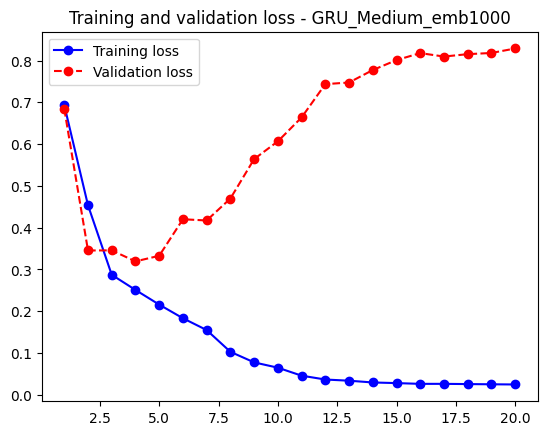


Testing GRU_Medium with embedding dim = 5000 (sequence length = 100, batch size = 32)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_87 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_58 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_59 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_60 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5487 - loss: 0.6827

625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5490 - loss: 0.6825 - val_accuracy: 0.8350 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8603 - loss: 0.3442

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.8603 - loss: 0.3441 - val_accuracy: 0.8582 - val_loss: 0.3617 - learning_rate: 0.0010
Epoch 3/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8943 - loss: 0.2696

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.8943 - loss: 0.2696 - val_accuracy: 0.8614 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9144 - loss: 0.2201 - val_accuracy: 0.8634 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9263 - loss: 0.1902 - val_accuracy: 0.8516 - val_loss: 0.3788 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9355 - loss: 0.1776 - val_accuracy: 0.8550 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9524 - loss: 0.1346 - val_accuracy: 0.8574 - val_loss: 0.4536 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9734 - loss: 0.0837 - val_accuracy: 0.8562 - val_loss: 0.4808 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9785 - loss

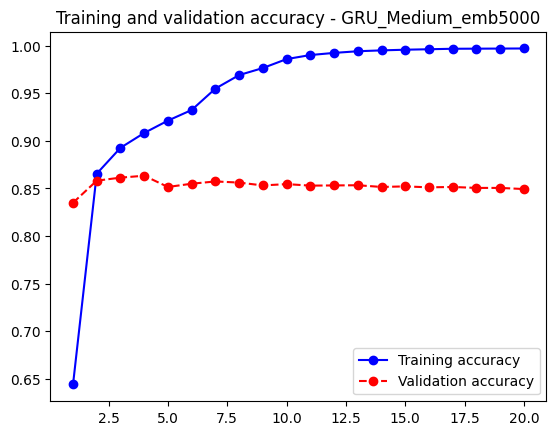

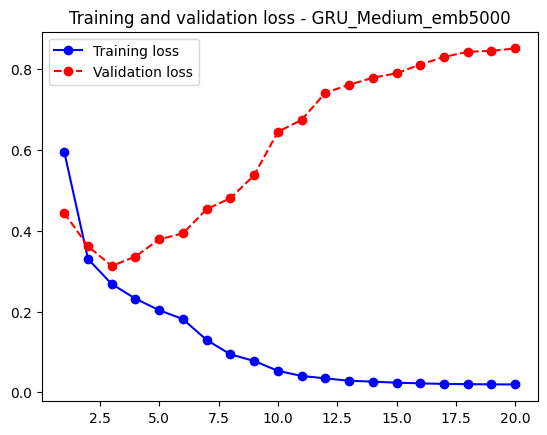


Testing GRU_Medium with batch size = 32 (sequence length = 100, embedding dim = 1000)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_88 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_62 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_63 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_64 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_65 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5086 - loss: 0.6965

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5086 - loss: 0.6965 - val_accuracy: 0.4918 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5936 - loss: 0.6507

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5937 - loss: 0.6506 - val_accuracy: 0.8134 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8647 - loss: 0.3233

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8647 - loss: 0.3233 - val_accuracy: 0.8598 - val_loss: 0.3271 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9001 - loss: 0.2524 - val_accuracy: 0.8510 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9194 - loss: 0.2127 - val_accuracy: 0.8666 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9345 - loss: 0.1756 - val_accuracy: 0.8580 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9580 - loss: 0.1268 - val_accuracy: 0.8634 - val_loss: 0.4149 - learning_rate: 5.0000e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9705 - loss: 0.0965 - val_accuracy: 0.8574 - val_loss: 0.4429 - learning_rate: 5.0000e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9813 - loss

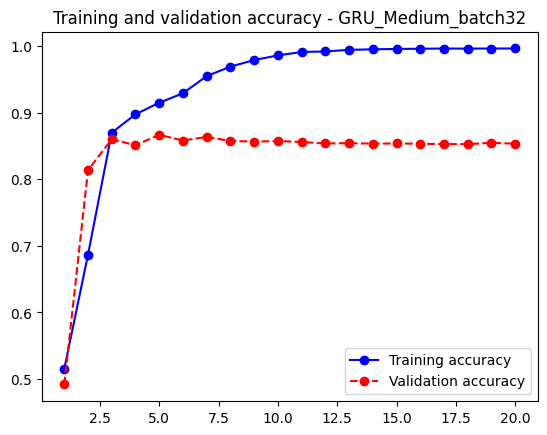

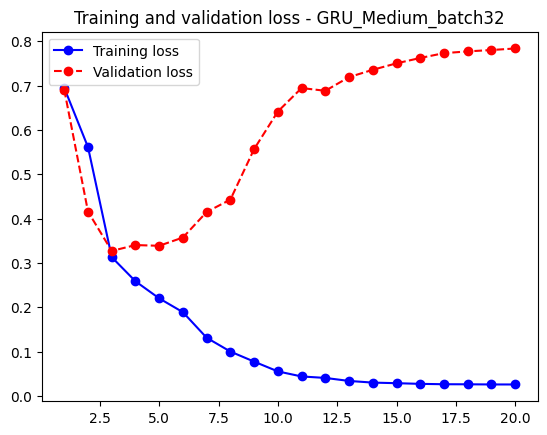


Testing GRU_Medium with batch size = 128 (sequence length = 100, embedding dim = 1000)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_89 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_66 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_67 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_68 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_69 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5131 - loss: 0.6950

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.5132 - loss: 0.6950 - val_accuracy: 0.4928 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5462 - loss: 0.6889

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5463 - loss: 0.6889 - val_accuracy: 0.5754 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 3/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6981 - loss: 0.5693

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6991 - loss: 0.5680 - val_accuracy: 0.8364 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8810 - loss: 0.2937

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8810 - loss: 0.2938 - val_accuracy: 0.8572 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8963 - loss: 0.2604 - val_accuracy: 0.8584 - val_loss: 0.3472 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9199 - loss: 0.2141 - val_accuracy: 0.8458 - val_loss: 0.3958 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9233 - loss: 0.1998 - val_accuracy: 0.8532 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9447 - loss: 0.1636 - val_accuracy: 0.8594 - val_loss: 0.4271 - learning_rate: 5.0000e-04
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9586 - loss: 0.1257 - val_accuracy: 0.8514 - val_loss: 0.4158 - learning_rate: 5.0000e-04
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9622 - loss: 

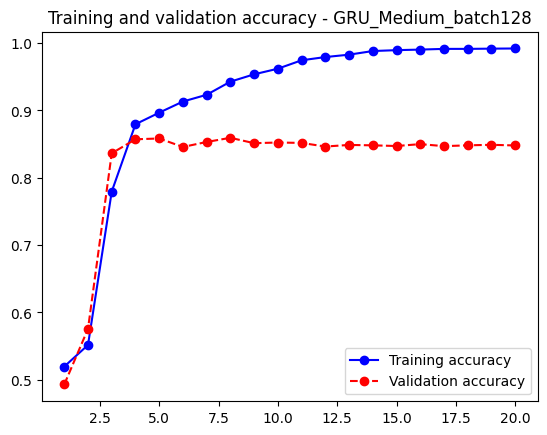

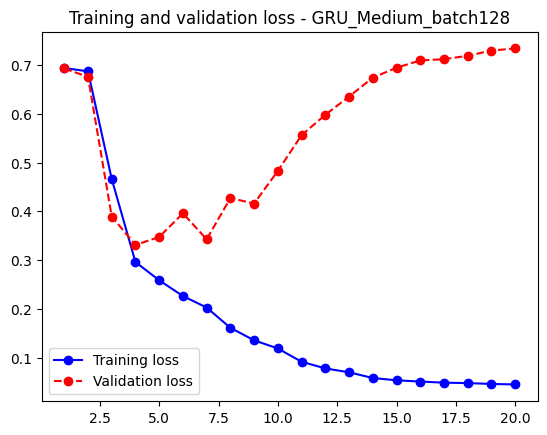


Testing GRU_Medium with batch size = 256 (sequence length = 100, embedding dim = 1000)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_90 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_70 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_71 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_72 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_232 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_73 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_233 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5142 - loss: 0.6942

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5142 - loss: 0.6942 - val_accuracy: 0.5328 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5382 - loss: 0.6890 - val_accuracy: 0.4962 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5746 - loss: 0.6684

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5750 - loss: 0.6682 - val_accuracy: 0.7514 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7793 - loss: 0.5025

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7797 - loss: 0.5019 - val_accuracy: 0.8394 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8671 - loss: 0.3237

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8672 - loss: 0.3236 - val_accuracy: 0.8442 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8945 - loss: 0.2702

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8944 - loss: 0.2702 - val_accuracy: 0.8552 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9059 - loss: 0.2383 - val_accuracy: 0.8582 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9156 - loss: 0.2251 - val_accuracy: 0.8544 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9275 - loss: 0.1934 - val_accuracy: 0.8528 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9417 - loss: 0.1648 - val_accuracy: 0.8558 - val_loss: 0.4030 - learning_rate: 5.0000e-04
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9481 - loss: 0.1490 - val_accuracy: 0.8492 - val_loss: 0.4256 - learning_rate: 5.0000e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9603 - loss: 0.1263 - val_acc

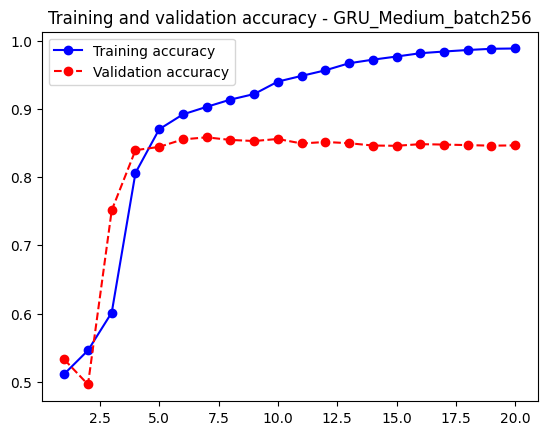

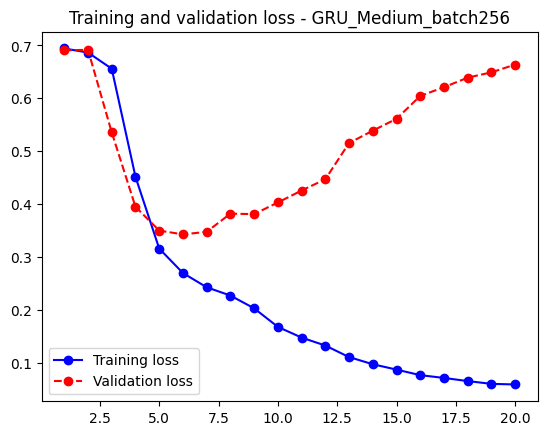


Final Results:
SimpleRNN_Small_seq50: Loss = 0.5668, Accuracy = 0.7110
SimpleRNN_Small_seq100: Loss = 0.6028, Accuracy = 0.7041
SimpleRNN_Small_seq150: Loss = 0.6928, Accuracy = 0.5152
SimpleRNN_Small_seq300: Loss = 0.6929, Accuracy = 0.5137
SimpleRNN_Small_emb100: Loss = 0.6063, Accuracy = 0.6729
SimpleRNN_Small_emb500: Loss = 0.6182, Accuracy = 0.6584
SimpleRNN_Small_emb1000: Loss = 0.7592, Accuracy = 0.5476
SimpleRNN_Small_emb5000: Loss = 0.7365, Accuracy = 0.6566
SimpleRNN_Small_batch32: Loss = 0.8109, Accuracy = 0.5374
SimpleRNN_Small_batch128: Loss = 1.6230, Accuracy = 0.5085
SimpleRNN_Small_batch256: Loss = 2.0755, Accuracy = 0.5121
SimpleRNN_Medium_seq50: Loss = 0.6487, Accuracy = 0.6303
SimpleRNN_Medium_seq100: Loss = 0.6930, Accuracy = 0.5137
SimpleRNN_Medium_seq150: Loss = 0.6926, Accuracy = 0.5266
SimpleRNN_Medium_seq300: Loss = 0.6928, Accuracy = 0.5137
SimpleRNN_Medium_emb100: Loss = 0.6927, Accuracy = 0.5137
SimpleRNN_Medium_emb500: Loss = 0.6291, Accuracy = 0.6732
Simp

In [ ]:
median_seq_length = 100
median_embedding_dim = 1000
median_batch_size = 32

seq_length_list = [50, 100, 150, 300]
embedding_dim_list = [100, 500, 1000, 5000]
batch_size_list = [32, 128, 256]

configs = get_configurations()
results = {}

for model_name, config in configs.items():
    # Test varying sequence length
    for seq_length in seq_length_list:
        print(f"\nTesting {model_name} with sequence length = {seq_length} (embedding dim = {median_embedding_dim}, batch size = {median_batch_size})")
        x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, max_sequence_length, seq_length)
        model = build_rnn(config, max_sequence_length, seq_length, median_embedding_dim)

        model.summary()
        checkpoint = ModelCheckpoint(f"{model_name}_seq{seq_length}.h5", save_best_only=True, monitor='val_loss', mode='min')
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min', min_lr=1e-7)

        history = model.fit(
            x_train_int, y_train,
            epochs=20,
            batch_size=median_batch_size,
            validation_split=0.2,
            callbacks=[checkpoint, lr_scheduler],
            verbose=1
        )

        result = model.evaluate(x_test_int, y_test)
        results[f"{model_name}_seq{seq_length}"] = result
        plot(history, f"{model_name}_seq{seq_length}")

    # Test varying embedding dimension
    for embedding_dim in embedding_dim_list:
        print(f"\nTesting {model_name} with embedding dim = {embedding_dim} (sequence length = {median_seq_length}, batch size = {median_batch_size})")
        x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, max_sequence_length, median_seq_length)
        model = build_rnn(config, max_sequence_length, median_seq_length, embedding_dim)

        model.summary()
        checkpoint = ModelCheckpoint(f"{model_name}_emb{embedding_dim}.h5", save_best_only=True, monitor='val_loss', mode='min')
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min', min_lr=1e-7)

        history = model.fit(
            x_train_int, y_train,
            epochs=20,
            batch_size=median_batch_size,
            validation_split=0.2,
            callbacks=[checkpoint, lr_scheduler],
            verbose=1
        )

        result = model.evaluate(x_test_int, y_test)
        results[f"{model_name}_emb{embedding_dim}"] = result
        plot(history, f"{model_name}_emb{embedding_dim}")

    # Test varying batch size
    for batch_size in batch_size_list:
        print(f"\nTesting {model_name} with batch size = {batch_size} (sequence length = {median_seq_length}, embedding dim = {median_embedding_dim})")
        x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, max_sequence_length, median_seq_length)
        model = build_rnn(config, max_sequence_length, median_seq_length, median_embedding_dim)

        model.summary()
        checkpoint = ModelCheckpoint(f"{model_name}_batch{batch_size}.h5", save_best_only=True, monitor='val_loss', mode='min')
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min', min_lr=1e-7)

        history = model.fit(
            x_train_int, y_train,
            epochs=20,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[checkpoint, lr_scheduler],
            verbose=1
        )

        result = model.evaluate(x_test_int, y_test)
        results[f"{model_name}_batch{batch_size}"] = result
        plot(history, f"{model_name}_batch{batch_size}")

print("\nFinal Results:")
for name, result in results.items():
    print(f"{name}: Loss = {result[0]:.4f}, Accuracy = {result[1]:.4f}")


## **RESULTS**

In [ ]:

data = {
    'Model': ['SimpleRNN_Small_seq50', 'SimpleRNN_Small_seq100', 'SimpleRNN_Small_seq150', 'SimpleRNN_Small_seq300',
              'SimpleRNN_Small_emb100', 'SimpleRNN_Small_emb500', 'SimpleRNN_Small_emb1000', 'SimpleRNN_Small_emb5000',
              'SimpleRNN_Small_batch32', 'SimpleRNN_Small_batch128', 'SimpleRNN_Small_batch256',
              'SimpleRNN_Medium_seq50', 'SimpleRNN_Medium_seq100', 'SimpleRNN_Medium_seq150', 'SimpleRNN_Medium_seq300',
              'SimpleRNN_Medium_emb100', 'SimpleRNN_Medium_emb500', 'SimpleRNN_Medium_emb1000', 'SimpleRNN_Medium_emb5000',
              'SimpleRNN_Medium_batch32', 'SimpleRNN_Medium_batch128', 'SimpleRNN_Medium_batch256',
              'LSTM_Small_seq50', 'LSTM_Small_seq100', 'LSTM_Small_seq150', 'LSTM_Small_seq300',
              'LSTM_Small_emb100', 'LSTM_Small_emb500', 'LSTM_Small_emb1000', 'LSTM_Small_emb5000',
              'LSTM_Small_batch32', 'LSTM_Small_batch128', 'LSTM_Small_batch256',
              'LSTM_Medium_seq50', 'LSTM_Medium_seq100', 'LSTM_Medium_seq150', 'LSTM_Medium_seq300',
              'LSTM_Medium_emb100', 'LSTM_Medium_emb500', 'LSTM_Medium_emb1000', 'LSTM_Medium_emb5000',
              'LSTM_Medium_batch32', 'LSTM_Medium_batch128', 'LSTM_Medium_batch256',
              'GRU_Small_seq50', 'GRU_Small_seq100', 'GRU_Small_seq150', 'GRU_Small_seq300',
              'GRU_Small_emb100', 'GRU_Small_emb500', 'GRU_Small_emb1000', 'GRU_Small_emb5000',
              'GRU_Small_batch32', 'GRU_Small_batch128', 'GRU_Small_batch256',
              'GRU_Medium_seq50', 'GRU_Medium_seq100', 'GRU_Medium_seq150', 'GRU_Medium_seq300',
              'GRU_Medium_emb100', 'GRU_Medium_emb500', 'GRU_Medium_emb1000', 'GRU_Medium_emb5000',
              'GRU_Medium_batch32', 'GRU_Medium_batch128', 'GRU_Medium_batch256'],
    'Accuracy': [0.7110, 0.7041, 0.5152, 0.5137, 0.6729, 0.6584, 0.5476, 0.6566, 0.5374, 0.5085, 0.5121,
                 0.6303, 0.5137, 0.5266, 0.5137, 0.5137, 0.6732, 0.5302, 0.6758, 0.5440, 0.5583, 0.5360,
                 0.8265, 0.8577, 0.8677, 0.5137, 0.8650, 0.8538, 0.8510, 0.8514, 0.8514, 0.8511, 0.8536,
                 0.8271, 0.8555, 0.8702, 0.5137, 0.8102, 0.8605, 0.8566, 0.8610, 0.8542, 0.8568, 0.7462,
                 0.8238, 0.8555, 0.8658, 0.5137, 0.8594, 0.8510, 0.8544, 0.8562, 0.8564, 0.8525, 0.8534,
                 0.8259, 0.8530, 0.8576, 0.5137, 0.8553, 0.8543, 0.8579, 0.8568, 0.8586, 0.8526, 0.8504]
}

df = pd.DataFrame(data)


### ***Which models obtain the 84% of accuracy?***


In [ ]:
high_perf_models = df[df['Accuracy'] > 0.84].sort_values(by='Accuracy', ascending=False)
print(high_perf_models)
count_high_perf_models = len(high_perf_models)
print(f"Number of models with accuracy > 0.84: {count_high_perf_models}")

                   Model  Accuracy
35    LSTM_Medium_seq150    0.8702
24     LSTM_Small_seq150    0.8677
46      GRU_Small_seq150    0.8658
26     LSTM_Small_emb100    0.8650
40   LSTM_Medium_emb5000    0.8610
38    LSTM_Medium_emb500    0.8605
48      GRU_Small_emb100    0.8594
63    GRU_Medium_batch32    0.8586
61    GRU_Medium_emb1000    0.8579
23     LSTM_Small_seq100    0.8577
57     GRU_Medium_seq150    0.8576
42  LSTM_Medium_batch128    0.8568
62    GRU_Medium_emb5000    0.8568
39   LSTM_Medium_emb1000    0.8566
52     GRU_Small_batch32    0.8564
51     GRU_Small_emb5000    0.8562
45      GRU_Small_seq100    0.8555
34    LSTM_Medium_seq100    0.8555
59     GRU_Medium_emb100    0.8553
50     GRU_Small_emb1000    0.8544
60     GRU_Medium_emb500    0.8543
41   LSTM_Medium_batch32    0.8542
27     LSTM_Small_emb500    0.8538
32   LSTM_Small_batch256    0.8536
54    GRU_Small_batch256    0.8534
56     GRU_Medium_seq100    0.8530
64   GRU_Medium_batch128    0.8526
53    GRU_Small_batc

The analysis of models achieving over 84% accuracy reveals several important patterns:

* LSTM and GRU outperform SimpleRNN

* Sequence length and embedding size matter because many of the top models use:

   * A sequence length of 150 (seq150)

   * Embedding dimensions of 500 or higher

So we can guess that longer sequences help capture more contextual information and richer embeddings improve the quality of input representations.

* Models labeled as medium are frequently among the best results.

Some of the most successful configurations include:

LSTM_Medium_seq150 (87.02% accuracy)

LSTM_Small_seq150 (86.77%)

GRU_Small_seq150 (86.58%)

LSTM_Small_emb100 (86.50%)

LSTM_Medium_emb5000 (86.10%)

### ***Which RNN type works the best?***

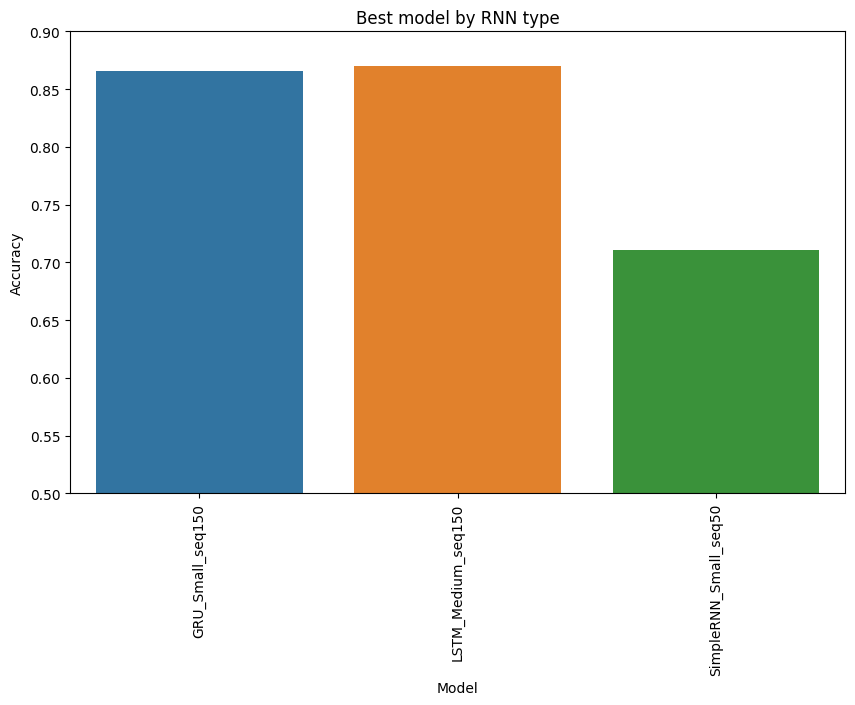

In [ ]:
best_models = df.groupby(df['Model'].str.split('_').str[0]).apply(lambda g: g.loc[g['Accuracy'].idxmax()])
plt.figure(figsize=(10, 6))
sns.barplot(data=best_models, x="Model", y="Accuracy", hue="Model")
plt.title("Best model by RNN type")
plt.xticks(rotation=90)
plt.ylim(0.5, 0.9)
plt.show()


Notably, LSTM models appear most frequently among the top-performing models, with several configurations achieving accuracy levels above 86%. For instance, LSTM_Medium_seq150 reaches an accuracy of 87.02%, the highest among all models. GRU models also show strong performance, especially when combined with longer sequences and higher embedding sizes. For these reasons, LSTM would be the best RNN type for this purpose.

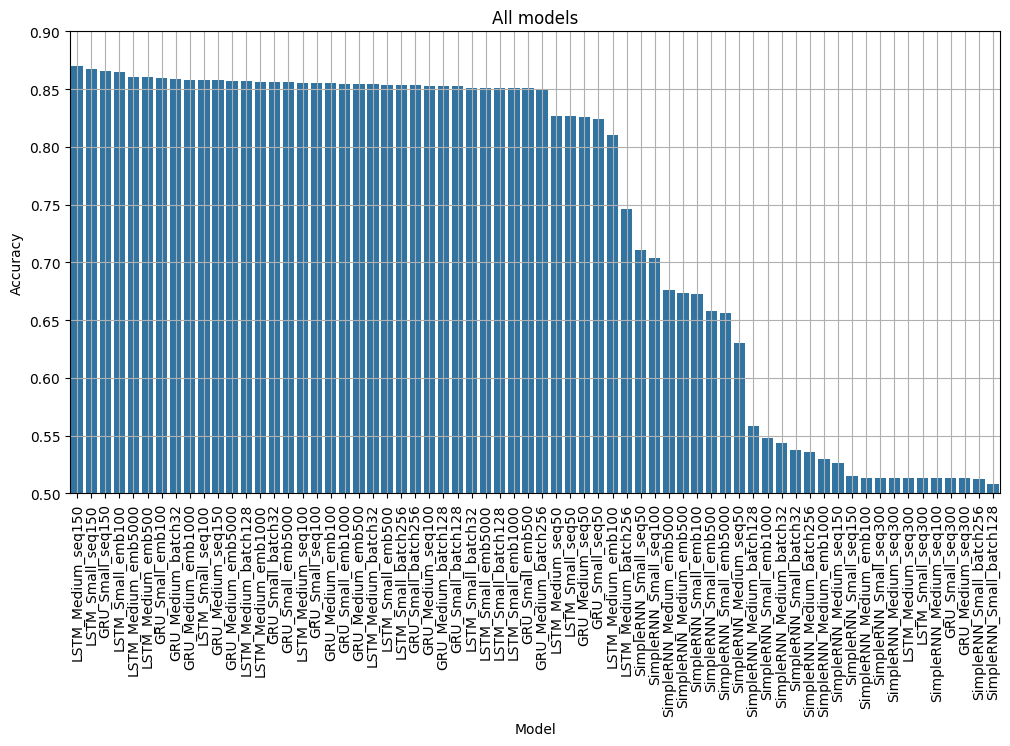

In [ ]:
df_sorted = df.sort_values("Accuracy", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=df_sorted)
plt.xticks(rotation=90)
plt.title("All models")
plt.ylim(0.5, 0.9)
plt.grid(True)
plt.show()


### ***Impact of the sequence length***

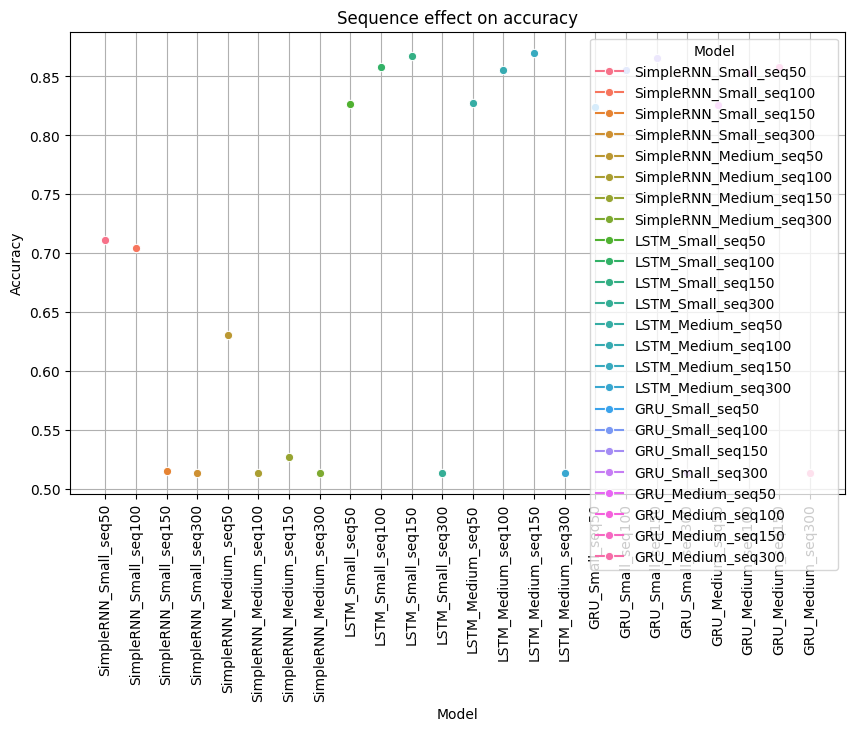

In [ ]:

seq_df = df[df["Model"].str.contains("seq")]
plt.figure(figsize=(10, 6))
sns.lineplot(data=seq_df, x="Model", y="Accuracy", hue="Model", marker="o")
plt.title("Sequence effect on accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


 * For instance LSTM_Medium_seq150 achieved the highest accuracy while LSTM_Small_seq150 and GRU_Small_seq150 also performed exceptionally well reaching 86.77 percent and 86.58 percent respectively.  
 * In contrast, models trained on shorter sequences like 50 or 100 generally scored lower for example LSTM_Small_seq50 and GRU_Small_seq50 only reached 82.65 percent and 82.38 percent respectively and several models with a sequence length of 100 such as SimpleRNN_Medium_seq100 hovered around 51.37 percent suggesting poor learning capability in simpler RNN architectures.
 * However, very long sequences like 300 do not yield further benefits and may even harm performance models like SimpleRNN_Small_seq300 SimpleRNN_Medium_seq300 and LSTM_Medium_seq300 all achieved approximately 51 percent indicating overfitting.
 * This effect is particularly pronounced in SimpleRNNs which are known to struggle with long-term dependencies.
 These results suggest that the optimal sequence length lies around 150.


### ***Impact of the embedding size***

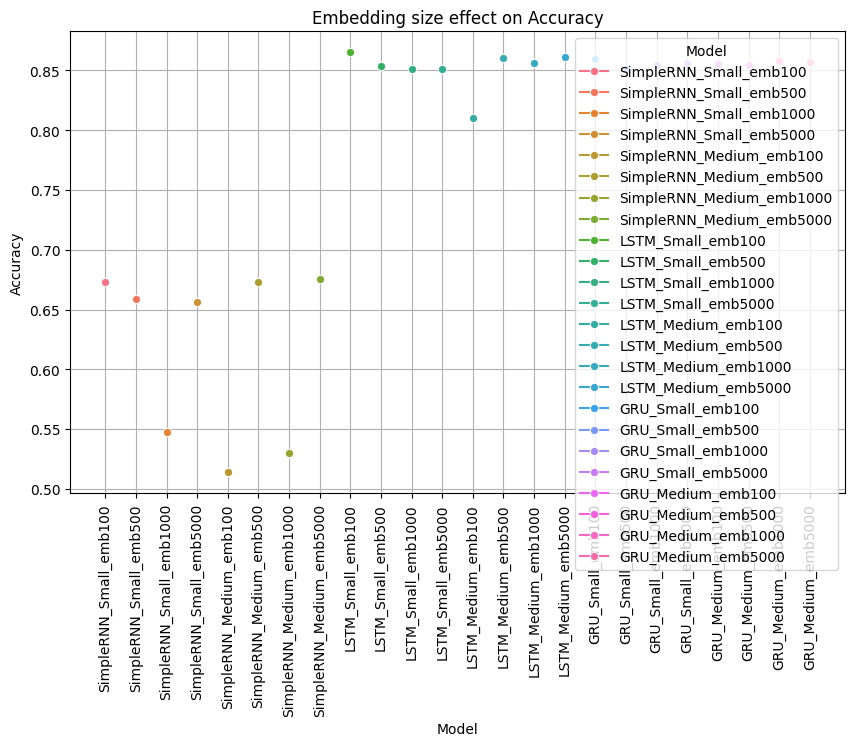

In [ ]:

emb_df = df[df["Model"].str.contains("emb")]
plt.figure(figsize=(10, 6))
sns.lineplot(data=emb_df, x="Model", y="Accuracy", hue="Model", marker="o")
plt.title("Embedding size effect on Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


* Models with an embedding size of 1000 or 5000 often performed better indicating that richer representations improve learning: LSTM_Medium_emb1000 achieved 85.66 percent accuracy and GRU_Medium_emb1000 reached 85.79.
*  SimpleRNN_Medium_emb100 and GRU_Small_emb100 obtained 51.37 and 85.94  respectively while GRU_Small_emb100 performed well for its size.
* LSTM_Small_emb100 and SimpleRNN_Small_emb100 only scored 86.50  and 67.29  respectively
* this suggests that while very large embeddings offer potential gains even moderate sizes like 500 may be sufficient.

### ***Impact of the batch size***

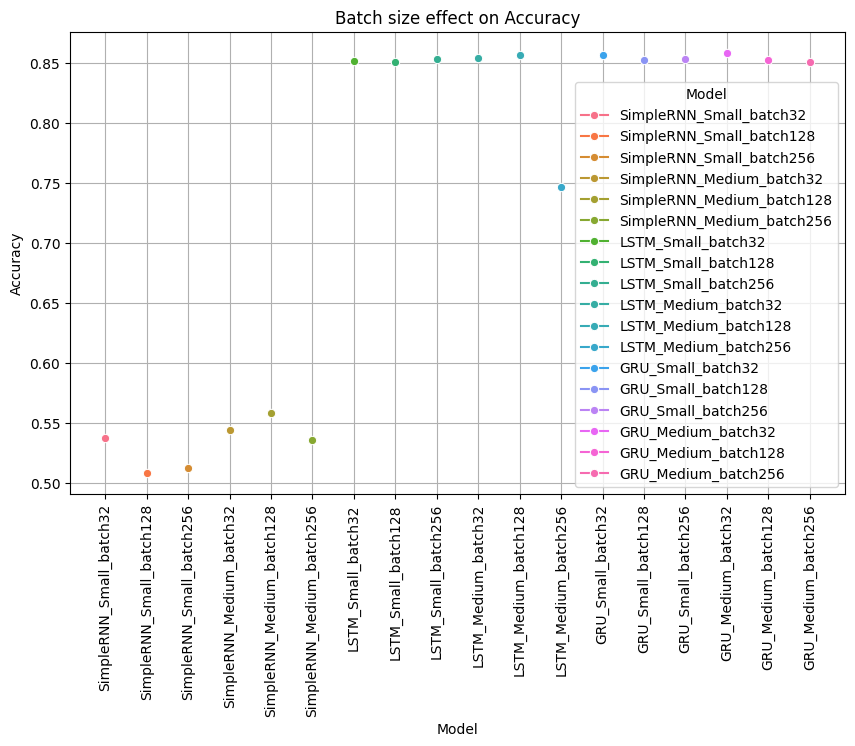

In [ ]:
batch_df = df[df["Model"].str.contains("batch")]
plt.figure(figsize=(10, 6))
sns.lineplot(data=batch_df, x="Model", y="Accuracy", hue="Model", marker="o")
plt.title("Batch size effect on Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


* Larger batch sizes such as 128 and 256 tend to result in higher accuracy across different RNN types. Models like LSTM_Medium_batch128 and GRU_Medium_batch128 achieved 85.68% and 85.68% accuracy, respectively.
* Additionally, models with batch size 32, such as LSTM_Medium_batch32 and GRU_Small_batch32, achieved competitive results with accuracies of 85.42% and 85.64%, indicating that smaller batch sizes can still be effective, particularly when combined with deeper architectures.
